In [115]:
# -*- coding: utf-8 -*-
# Copyright 2019 the HERA Project
# Licensed under the MIT License


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
plt.rcParams.update({'font.size': 14})

from copy import deepcopy
import argparse
import os
import linsolve

from hera_cal import utils
from hera_cal import version
from hera_cal.noise import predict_noise_variance_from_autos
from hera_cal.datacontainer import DataContainer
from hera_cal.utils import split_pol, conj_pol, split_bl, reverse_bl, join_bl, join_pol, comply_pol
from hera_cal.io import HERAData, HERACal, write_cal, save_redcal_meta
from hera_cal.apply_cal import calibrate_in_place

## Importing functions
from hera_cal.redcal import _get_pol_load_list, filter_reds, redundantly_calibrate, expand_omni_sol,get_pos_reds ,add_pol_reds


### Fixing degenaracies


import hera_pspec as hp
import hera_cal as hc
from hera_sim import io

## Classification
from sklearn.cluster import KMeans

# import uvtools
# import hera_cal as hc
# import hera_pspec as hp
# from pyuvdata import UVCal, UVData
# import pyuvdata.utils as uvutils




SEC_PER_DAY = 86400.
IDEALIZED_BL_TOL = 1e-8  # bl_error_tol for redcal.get_reds when using antenna positions calculated from reds


In [116]:
print('Module:','  Version')
print('hera_cal: ',hc.__version__)
#print('hera_sim: ',io.__version__)
print('hera_pspec: ',hp.__version__)
print('numpy: ',np.__version__)
print('pandas: ',pd.__version__)

import hera_sim
print('hera_sim: ', hera_sim.__version__)

Module:   Version
hera_cal:  3.0
hera_pspec:  0.2.0
numpy:  1.19.2
pandas:  1.1.3
hera_sim:  0.3.0


In [117]:
hera_spec = [6,17]
abc = np.arange(hera_spec[0], hera_spec[1]+1)
N_antennas = abc[-1] + 2*(sum(abc[:-1]))
N_antennas

259

In [145]:
# filename = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.uvh5"


filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"
gain_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"
filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"
noise_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_n.uvh5"


# filename = "../non-redundant-pipeline/calibration_10_10_10/viscatBC_stretch0.01_g_cal.uvh5"
# gain_filename = "../non-redundant-pipeline/calibration_10_10_10/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/calibration_10_10_10//viscatBC_stretch0.01.uvh5"
# noise_filename = "../non-redundant-pipeline/calibration_10_10_10/viscatBC_stretch0.01_n.uvh5"


c_data = HERAData(filename)
c_data.read()


noise_file = HERAData(noise_filename)
noise_file.read()

hd = HERAData(gain_filename)
hd.read()

true_data = HERAData(filename2)
true_data.read()

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


(<hera_cal.datacontainer.DataContainer at 0x7f507ac55d90>,
 <hera_cal.datacontainer.DataContainer at 0x7f5084b9c7f0>)

In [146]:
red_base = hd.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)

n = red_base[0][0]  
n = np.array(n)     ## Saving a list of redundant baselines in an array.


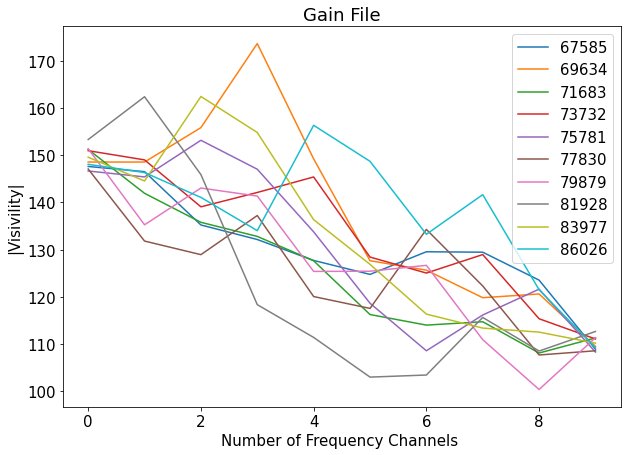

In [147]:
plt.figure(figsize=(10,7))

for i in range(len(n)):
    plt.plot( np.abs(hd.get_data(n[i])[1]) , label='{}'.format(n[i]))

plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visivility|')
plt.title('Gain File')
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.savefig('../non-redundant-pipeline/gain_file(100).png')
plt.show()


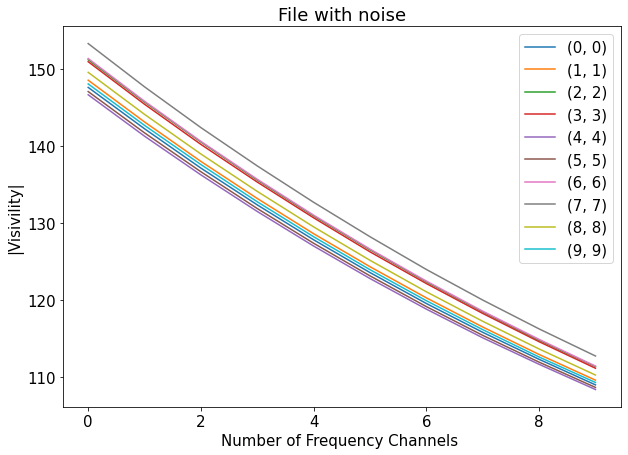

In [148]:
plt.figure(figsize=(10,7))

for i in range(len(n)):
    plt.plot( np.abs(noise_file.get_data(n[i])[1]) , label='{}'.format(noise_file.baseline_to_antnums(n[i])))

plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visivility|')
plt.title('File with noise')
plt.legend()
plt.rcParams.update({'font.size': 15})
plt.savefig('../non-redundant-pipeline/calibration_10_10_10/noise_file.png' , bbox_inches='tight')
plt.show()


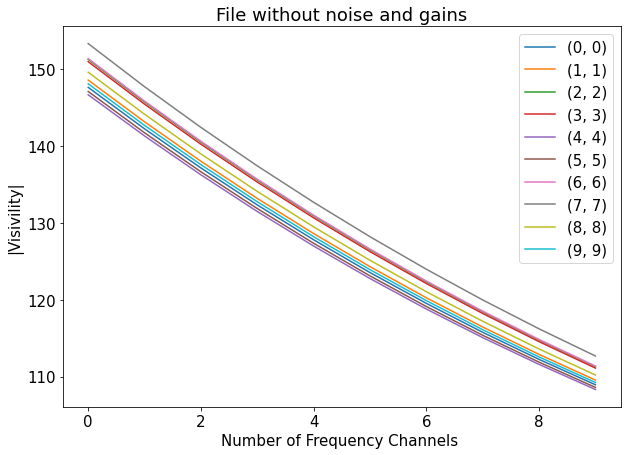

In [149]:
plt.figure(figsize=(10,7))

for i in range(len(n)):
    plt.plot( np.abs(true_data.get_data(n[i])[1]) , label='{}'.format(true_data.baseline_to_antnums(n[i])))

plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visivility|')
plt.title('File without noise and gains')
plt.legend()
plt.rcParams.update({'font.size': 15})
# plt.savefig('../non-redundant-pipeline/calibration_10_10_10/No_noise_gains_file.png' , bbox_inches='tight')

plt.show()


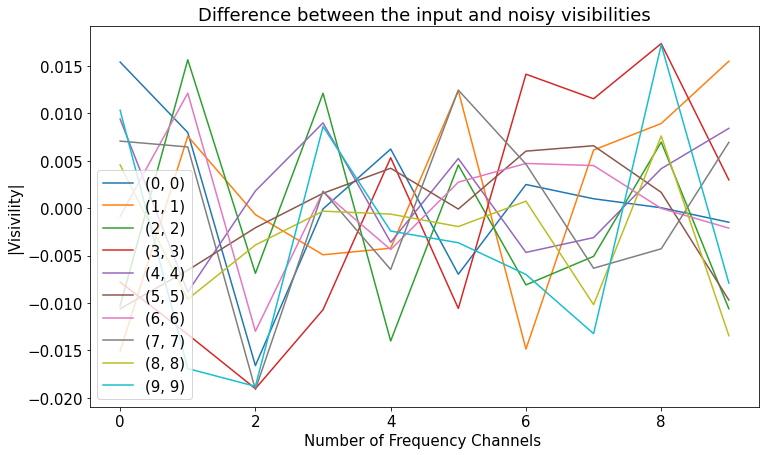

In [150]:
plt.figure(figsize=(12,7))

diff_noise_true = []
for i in range(len(n)):
    time_sample = 0
    
    diff = np.real(noise_file.get_data(n[i])) - np.real(true_data.get_data(n[i])) 
    
    plt.plot( diff[time_sample] , label='{}'.format(true_data.baseline_to_antnums(n[i])))

    diff_noise_true.append(diff)
    
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visivility|')

plt.legend()
plt.title('Difference between the input and noisy visibilities')
plt.rcParams.update({'font.size': 15})
# plt.savefig('../non-redundant-pipeline/calibration_10_10_10/noise_diff_file.png', bbox_inches='tight')
plt.show()

# (noise_file.get_data(0,0))

In [151]:
time_resolution = 40
change_freq = 166000

sigma_sq = []

for i in range(len(n)):
    ant1 = hd.baseline_to_antnums(n[0])[0]
    ant2 = hd.baseline_to_antnums(n[0])[1]
    
    v_ii = noise_file.get_data(ant1,ant1)
    v_jj = noise_file.get_data(ant2,ant2)
    
    sig_sq = (v_ii*v_jj)/(time_resolution*change_freq)
    sigma_sq.append(sig_sq)


In [152]:
time_resolution = 40
change_freq = 166000

sigma_sq = []

for i in range(len(n)):
    ant1 = hd.baseline_to_antnums(n[0])[0]
    ant2 = hd.baseline_to_antnums(n[0])[1]
    
    v_ii = noise_file.get_data(ant1,ant1)
    v_jj = noise_file.get_data(ant2,ant2)
    
    sig_sq = (v_ii*v_jj)/(time_resolution*change_freq)
    sigma_sq.append(sig_sq)

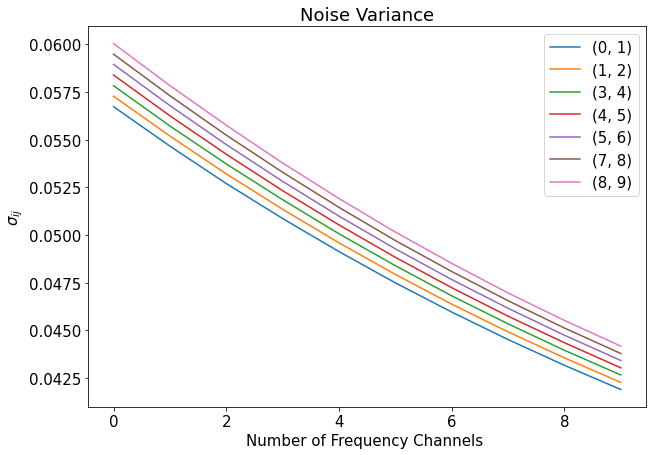

In [153]:
red_base = hd.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)

n = red_base[0][1]  
n = np.array(n) 

plt.figure(figsize=(10,7))

for i in range(len(n)):
    plt.plot( np.sqrt(np.real(sigma_sq[0])[i]) , label='{}'.format(hd.baseline_to_antnums(n[i])))

plt.xlabel('Number of Frequency Channels ')
plt.ylabel('$\sigma_{ij}$')

plt.legend()
plt.title('Noise Variance')
plt.rcParams.update({'font.size': 15})
# plt.savefig('../non-redundant-pipeline/calibration_10_10_10/sigma_plot.png' , bbox_inches='tight')

plt.show()


In [20]:
np.shape(c_data.get_data(1,0))

import modified_redcal

red_groups = modified_redcal.get_custom_reds(hd,c_data,3,2)


In [21]:
red_b = true_data.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)

n = red_b[0][1]  
n = np.array(n)     ## Saving a list of redundant baselines in an array.



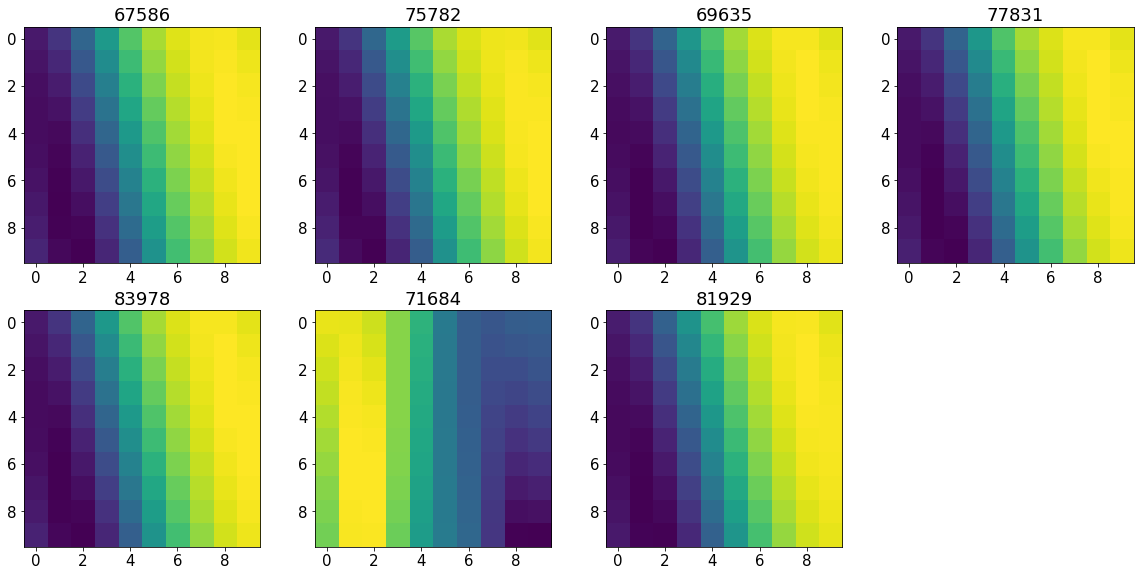

In [22]:

n = [67586, 75782,69635,77831,83978,71684,81929]

plt.figure(figsize=(20,20)) # specifying the overall grid size

for i in range(len(n)):
    k = int(0.5*len(n))+1
    plt.subplot(k,k,i+1)    
    plt.imshow(np.abs(true_data.get_data(n[i])))
    plt.title('{}'.format(n[i]))
plt.show()


# plt.imshow(np.abs(true_data.get_data(n[0])))
# plt.title('{}'.format(n[i]))



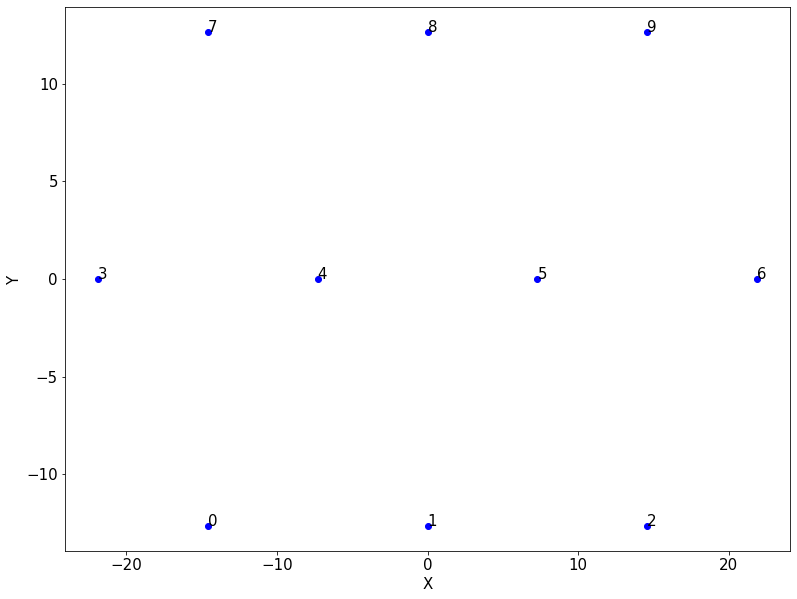

In [23]:

plt.figure(figsize=(13,10))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1],'bo', label='0')
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
#plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig('plots/Array.jpeg')
plt.show()


In [29]:
# vis_mean_std(f1, f2, f3)

Telescope hera_sim is not in known_telescopes.


(23, 60, 80)


Telescope hera_sim is not in known_telescopes.


(23, 60, 80)


Telescope hera_sim is not in known_telescopes.


(23, 60, 80)


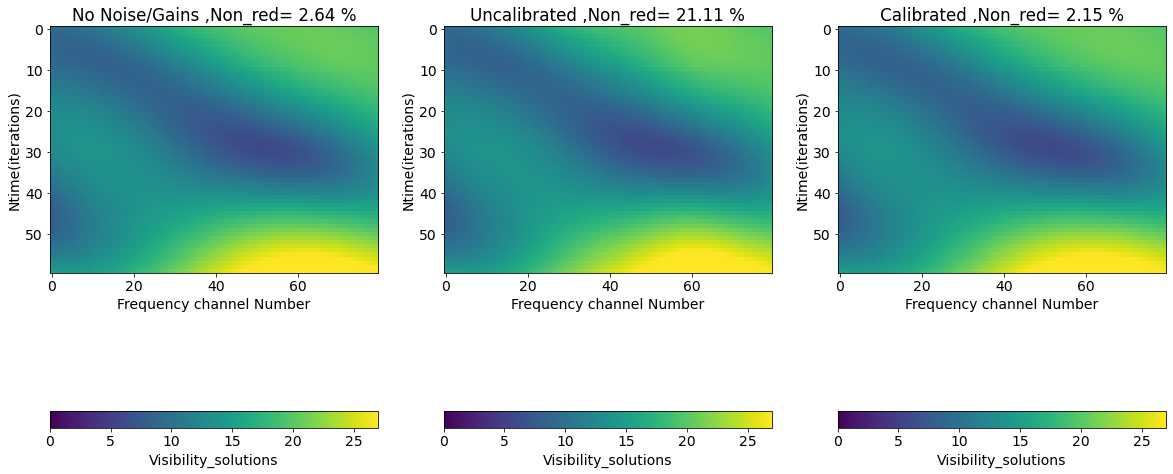

In [15]:
f1 = "../non-redundant-pipeline/File1/calibration_3a_0.01/viscatBC_stretch0.01.uvh5" 
f2 = "../non-redundant-pipeline/File1/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5" 
f3 = "../non-redundant-pipeline/File1/calibration_3a_0.01/viscatBC_stretch0.01_g_cal.uvh5" 

file_list = [f1,f2,f3]
Titles = ['No Noise/Gains', 'Uncalibrated', 'Calibrated']


plt.figure(figsize=(20,17)) # specifying the overall grid size
for i in range(len(file_list)):
    hd = HERAData(file_list[i])
    hd.read()
    ## Getting one redundant baseline group
    red_base = hd.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                                   conjugate_bls=False)

    n = red_base[0][1]  
    n = np.array(n)     ## Saving a list of redundant baselines in an array.
    
    ##  Combining a list of 2D arrays into a 3D array
    array_3D = []

    for j in range(len(n)):
        array_3D.append(hd.get_data(n[j]) )

    array_3D = np.array(array_3D)
    print(array_3D.shape)

    ##  Calculating and ploting the Mean visibility
    vis_mean = array_3D.mean(axis=0)
    
    ##  Calculating and ploting the Standard Deviation visibility
    vis_std = array_3D.std(axis=0)

    ##
    
    v_lim_array = vis_mean

    
#     tg_max = (np.real(v_lim_array.max()))
#     tg_min = (np.real(v_lim_array.min()))
    tg_max = 0
    tg_min = 27

    ###### Typical percentage level of non-redundancy for this group
    ##Non_red%  = std/mean =  (size of fluctuations) / (size of signal) *100
    a = (vis_std.max() +vis_std.min() )/2
    b = np.abs((vis_mean.max() +vis_mean.min() )/2)
    
    plt.subplot(1,3,i+1)    
    plt.imshow(np.abs(vis_mean),  clim=(tg_min, tg_max))
    plt.title('{} ,Non_red= {} %'.format(Titles[i], np.round(a/b*100, 2)))
    plt.colorbar(orientation='horizontal', label='Visibility_solutions')
    plt.xlabel('Frequency channel Number')
    plt.ylabel('Ntime(iterations)')





In [108]:
def cluster_all(new_time ,labels, time_sample):
    '''
    new_time: A 2-D array containing all time samples used as inputs on the clustering algorithm.
    labels: An array containing the list of labels from the clustering algorithm.
    time_sample: (int) Specify the time sample for the plot.
    
    '''
    ## Getting rid of repeated labels
    p = list(dict.fromkeys(labels))
    ## specifying the color of each label, e.g. 0 ='r', 1 = 'b', etc.
    colors = ['r','b','g','y','k','pink','magenta','orange']   ## number of colors should equal the number of groups in the cluster
    
    ## Getting the index of each label in order to find out which label belongs to which baseline
    x = labels
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    
    ## Ploting the baselines based on their classified positions.
    
    nfreq_list = np.linspace(len(hd.freqs), np.shape(new_time[0])[0], int(np.shape(new_time[0])[0]/len(hd.freqs)) )
    
    plt.figure(figsize=(10,7))
    for j in range(len(p)):
        
        cluster1 = get_indexes(p[j],x) ## a list of indeces for each label
        
        for i in cluster1:
            data = new_time[i][int(nfreq_list[time_sample]-len(hd.freqs)): int(nfreq_list[time_sample]) ]
            plt.plot(data, label='{}'.format(n[i]), color = colors[j])
    plt.xlabel('Number of Frequency Channels ')
    plt.ylabel('|Visivility|')
    plt.title('Single time samples')
    #plt.legend()
    plt.show()


In [114]:
# cluster_all
new_time = []

for i in range(len(n)):
    abc = abs(array_3D[i])
    d1 = []
    for j in range(len(abc)):
        d1.append(abc[j])
        d2 = np.concatenate(d1)  ### appending all time samples for each baseline
    new_time.append(d2)
    
new_time = np.array(new_time)


X = new_time
y = n
# Incorrect number of clusters
y_pred_all = KMeans(n_clusters=4).fit_predict(X)




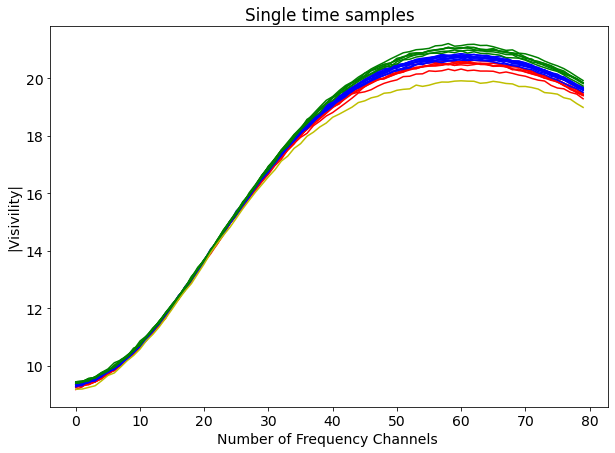

In [110]:
cluster_all(new_time, y_pred_all,0)

In [80]:
aa = np.linspace(len(hd.freqs), np.shape(new_time[0])[0], int(np.shape(new_time[0])[0]/len(hd.freqs)) )
aa

array([  80.,  160.,  240.,  320.,  400.,  480.,  560.,  640.,  720.,
        800.,  880.,  960., 1040., 1120., 1200., 1280., 1360., 1440.,
       1520., 1600., 1680., 1760., 1840., 1920., 2000., 2080., 2160.,
       2240., 2320., 2400., 2480., 2560., 2640., 2720., 2800., 2880.,
       2960., 3040., 3120., 3200., 3280., 3360., 3440., 3520., 3600.,
       3680., 3760., 3840., 3920., 4000., 4080., 4160., 4240., 4320.,
       4400., 4480., 4560., 4640., 4720., 4800.])

In [73]:
np.shape(new_time[0])[0]/len(hd.freqs)

60.0

In [138]:
print('N_Antennas = ', len(hd.antenna_numbers))
print('nfreq = ',len(hd.freq_array[0]) )
print('ntimes = ',len(hd.times))

np.shape(vis_mean)

N_Antennas =  30
nfreq =  80
ntimes =  60


(23, 60)

In [143]:
qq = np.array([ [[1,2,3],[4,5,6]], [[7,8,9],[10,11,12]], [[13,14,15], [16,17,18]] ] )
print(np.shape(qq))

qq.mean(axis=0)

# np.shape(qq.mean(axis=0))

(3, 2, 3)


array([[ 7.,  8.,  9.],
       [10., 11., 12.]])

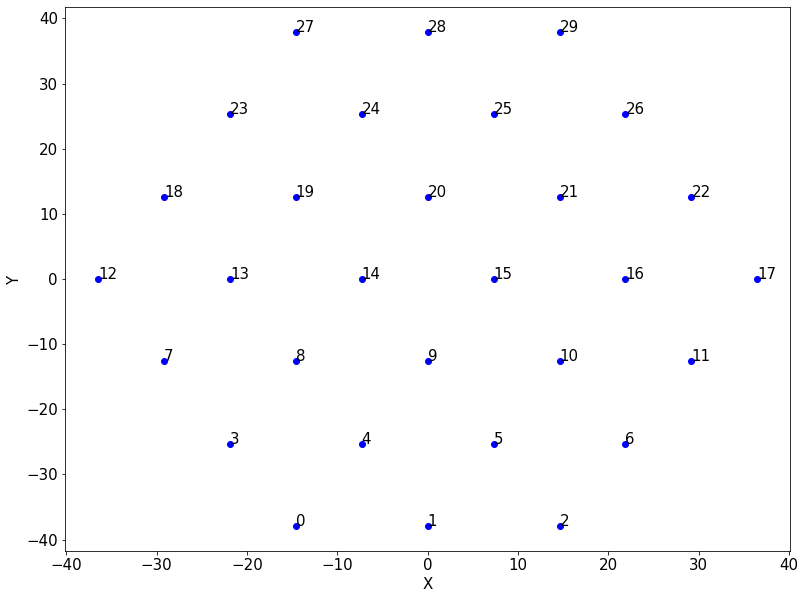

In [38]:

plt.figure(figsize=(13,10))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1],'bo', label='0')
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
#plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig('plots/Array.jpeg')
plt.show()

#len(reds_all)

In [7]:
def get_reds(antpos, pols=['nn'], pol_mode='1pol', bl_error_tol=1.0, include_autos=False):
    """ Combines redcal.get_pos_reds() and redcal.add_pol_reds(). See their documentation.
    Args:
        antpos: dictionary of antenna positions in the form {ant_index: np.array([x,y,z])}.
        pols: a list of polarizations e.g. ['nn', 'ne', 'en', 'ee']
        pol_mode: polarization mode of calibration
            '1pol': 1 antpol and 1 vispol (e.g. 'Jnn' and 'nn'). Default.
            '2pol': 2 antpols, no cross-vispols (e.g. 'Jnn','Jee' and 'nn','ee')
            '4pol': 2 antpols, 4 vispols (e.g. 'Jnn','Jee' and 'nn','ne','en','ee')
            '4pol_minV': 2 antpols, 4 vispols in data but assuming V_ne = V_en in model
        bl_error_tol: the largest allowable difference between baselines in a redundant group
            (in the same units as antpos). Normally, this is up to 4x the largest antenna position error.
        include_autos: bool, optional
            if true, include autocorr redundant group
            Default is false.
    Returns:
        reds: list (sorted by baseline length) of lists of redundant baseline tuples, e.g. (ind1,ind2,pol).
            Each interior list is sorted so that the lowest index is first in the first baseline.
    """
    pos_reds = get_pos_reds(antpos, bl_error_tol=bl_error_tol, include_autos=include_autos)
    return add_pol_reds(pos_reds, pols=pols, pol_mode=pol_mode)


In [8]:


ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
pols=['nn']
pol_mode='2pol'
bl_error_tol=1.0

#def _get_pol_load_list(pols, pol_mode='1pol'):
'''Get a list of lists of polarizations to load simultaneously, depending on the polarizations
in the data and the pol_mode (which can be 1pol, 2pol, 4pol, or 4pol_minV)'''

if pol_mode in ['1pol', '2pol']:
    pol_load_list = [[pol] for pol in pols if split_pol(pol)[0] == split_pol(pol)[1]]
elif pol_mode in ['4pol', '4pol_minV']:
    assert len(pols) == 4, 'For 4pol calibration, there must be four polarizations in the data file.'
    pol_load_list = [pols]
else:
    raise ValueError('Unrecognized pol_mode: {}'.format(pol_mode))




reds_all = get_reds({ant: hd.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))

type(reds_all)

list

In [9]:
def redcal_iteration(hd, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    '''Perform redundant calibration (firstcal, logcal, and omnical) an entire HERAData object, loading only
    nInt_to_load integrations at a time and skipping and flagging times when the sun is above solar_horizon.
    Arguments:
        hd: HERAData object, instantiated with the datafile or files to calibrate. Must be loaded using uvh5.
            Assumed to have no prior flags.
        nInt_to_load: number of integrations to load and calibrate simultaneously. Default None loads all integrations.
            Partial io requires 'uvh5' filetype for hd. Lower numbers save memory, but incur a CPU overhead.
        pol_mode: polarization mode of redundancies. Can be '1pol', '2pol', '4pol', or '4pol_minV'.
            See recal.get_reds for more information.
        bl_error_tol: the largest allowable difference between baselines in a redundant group
            (in the same units as antpos). Normally, this is up to 4x the largest antenna position error.
        ex_ants: list of antennas to exclude from calibration and flag. Can be either antenna numbers or
            antenna-polarization tuples. In the former case, all pols for an antenna will be excluded.
        solar_horizon: float, Solar altitude flagging threshold [degrees]. When the Sun is above
            this altitude, calibration is skipped and the integrations are flagged.
        flag_nchan_low: integer number of channels at the low frequency end of the band to always flag (default 0)
        flag_nchan_high: integer number of channels at the high frequency end of the band to always flag (default 0)
        fc_conv_crit: maximum allowed changed in firstcal phases for convergence
        fc_maxiter: maximum number of firstcal iterations allowed for finding per-antenna phases
        oc_conv_crit: maximum allowed relative change in omnical solutions for convergence
        oc_maxiter: maximum number of omnical iterations allowed before it gives up
        check_every: compute omnical convergence every Nth iteration (saves computation).
        check_after: start computing omnical convergence only after N iterations (saves computation).
        gain: The fractional step made toward the new solution each omnical iteration. Values in the
            range 0.1 to 0.5 are generally safe. Increasing values trade speed for stability.
        max_dims: maximum allowed generalized tip/tilt phase degeneracies of redcal that are fixed
            with remove_degen() and must be later abscaled. None is no limit. 2 is a classically
            "redundantly calibratable" planar array.  More than 2 usually arises with subarrays of
            redundant baselines. Antennas will be excluded from reds to satisfy this.
        verbose: print calibration progress updates
        filter_reds_kwargs: additional filters for the redundancies (see redcal.filter_reds for documentation)
    Returns a dictionary of results with the following keywords:
        'g_firstcal': firstcal gains in dictionary keyed by ant-pol tuples like (1,'Jnn').
            Gains are Ntimes x Nfreqs gains but fully described by a per-antenna delay.
        'gf_firstcal': firstcal gain flags in the same format as 'g_firstcal'. Will be all False.
        'g_omnical': full omnical gain dictionary (which include firstcal gains) in the same format.
            Flagged gains will be 1.0s.
        'gf_omnical': omnical flag dictionary in the same format. Flags arise from NaNs in log/omnical.
        'v_omnical': omnical visibility solutions dictionary with baseline-pol tuple keys that are the
            first elements in each of the sub-lists of reds. Flagged visibilities will be 0.0s.
        'vf_omnical': omnical visibility flag dictionary in the same format. Flags arise from NaNs.
        'vns_omnical': omnical visibility nsample dictionary that counts the number of unflagged redundancies.
        'chisq': chi^2 per degree of freedom for the omnical solution. Normalized using noise derived
            from autocorrelations. If the inferred pol_mode from reds (see redcal.parse_pol_mode) is
            '1pol' or '2pol', this is a dictionary mapping antenna polarization (e.g. 'Jnn') to chi^2.
            Otherwise, there is a single chisq (because polarizations mix) and this is a numpy array.
        'chisq_per_ant': dictionary mapping ant-pol tuples like (1,'Jnn') to the average chisq
            for all visibilities that an antenna participates in.
        'fc_meta' : dictionary that includes delays and identifies flipped antennas
        'omni_meta': dictionary of information about the omnical convergence and chi^2 of the solution
    '''
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged

    all_reds = get_reds({ant: hd.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))

#     all_reds = get_custom_reds(hd,3)
    
    
    rv['v_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=np.complex64) for red in all_reds})
    rv['vf_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=bool) for red in all_reds})
    rv['vns_omnical'] = DataContainer({red[0]: np.zeros((nTimes, nFreqs), dtype=np.float32) for red in all_reds})
    filtered_reds = filter_reds(all_reds, ex_ants=ex_ants, antpos=hd.antpos, **filter_reds_kwargs)

    # setup metadata dictionaries
    rv['fc_meta'] = {'dlys': {ant: np.full(nTimes, np.nan) for ant in ants}}
    rv['fc_meta']['polarity_flips'] = {ant: np.full(nTimes, np.nan) for ant in ants}
    rv['omni_meta'] = {'chisq': {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}}
    rv['omni_meta']['iter'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=int) for pols in pol_load_list}
    rv['omni_meta']['conv_crit'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}

    # solar flagging
    lat, lon, alt = hd.telescope_location_lat_lon_alt_degrees
    solar_alts = utils.get_sun_alt(hd.times, latitude=lat, longitude=lon)
    solar_flagged = solar_alts > solar_horizon
    if verbose and np.any(solar_flagged):
        print(len(hd.times[solar_flagged]), 'integrations flagged due to sun above', solar_horizon, 'degrees.')

    # loop over polarizations and times, performing partial loading if desired
    for pols in pol_load_list:
        if verbose:
            print('Now calibrating', pols, 'polarization(s)...')
        reds = filter_reds(filtered_reds, ex_ants=ex_ants, pols=pols)
        if nInt_to_load is not None:  # split up the integrations to load nInt_to_load at a time
            tind_groups = np.split(np.arange(nTimes)[~solar_flagged],
                                   np.arange(nInt_to_load, len(hd.times[~solar_flagged]), nInt_to_load))
        else:
            tind_groups = [np.arange(nTimes)[~solar_flagged]]  # just load a single group
        for tinds in tind_groups:
            if len(tinds) > 0:
                if verbose:
                    print('    Now calibrating times', hd.times[tinds[0]], 'through', hd.times[tinds[-1]], '...')
                if nInt_to_load is None:  # don't perform partial I/O
                    data, _, nsamples = hd.build_datacontainers()  # this may contain unused polarizations, but that's OK
                    for bl in data:
                        data[bl] = data[bl][tinds, fSlice]  # cut down size of DataContainers to match unflagged indices
                        nsamples[bl] = nsamples[bl][tinds, fSlice]
                else:  # perform partial i/o
                    data, _, nsamples = hd.read(times=hd.times[tinds], frequencies=hd.freqs[fSlice], polarizations=pols)
                cal = redundantly_calibrate(data, reds, freqs=hd.freqs[fSlice], times_by_bl=hd.times_by_bl,
                                            fc_conv_crit=fc_conv_crit, fc_maxiter=fc_maxiter,
                                            oc_conv_crit=oc_conv_crit, oc_maxiter=oc_maxiter,
                                            check_every=check_every, check_after=check_after, max_dims=max_dims, gain=gain)
                expand_omni_sol(cal, filter_reds(all_reds, pols=pols), data, nsamples)

                # gather results
                for ant in cal['g_omnical'].keys():
                    rv['g_firstcal'][ant][tinds, fSlice] = cal['g_firstcal'][ant]
                    rv['gf_firstcal'][ant][tinds, fSlice] = cal['gf_firstcal'][ant]
                    rv['g_omnical'][ant][tinds, fSlice] = cal['g_omnical'][ant]
                    rv['gf_omnical'][ant][tinds, fSlice] = cal['gf_omnical'][ant]
                    rv['chisq_per_ant'][ant][tinds, fSlice] = cal['chisq_per_ant'][ant]
                for ant in cal['fc_meta']['dlys'].keys():
                    rv['fc_meta']['dlys'][ant][tinds] = cal['fc_meta']['dlys'][ant]
                    rv['fc_meta']['polarity_flips'][ant][tinds] = cal['fc_meta']['polarity_flips'][ant]
                for bl in cal['v_omnical'].keys():
                    rv['v_omnical'][bl][tinds, fSlice] = cal['v_omnical'][bl]
                    rv['vf_omnical'][bl][tinds, fSlice] = cal['vf_omnical'][bl]
                    rv['vns_omnical'][bl][tinds, fSlice] = cal['vns_omnical'][bl]
                if pol_mode in ['1pol', '2pol']:
                    for antpol in cal['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq'][antpol]
                else:  # duplicate chi^2 into both antenna polarizations
                    for antpol in rv['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq']
                rv['omni_meta']['chisq'][str(pols)][tinds, fSlice] = cal['omni_meta']['chisq']
                rv['omni_meta']['iter'][str(pols)][tinds, fSlice] = cal['omni_meta']['iter']
                rv['omni_meta']['conv_crit'][str(pols)][tinds, fSlice] = cal['omni_meta']['conv_crit']

    return rv

In [10]:
def cluster_baselines(data_file, Number_of_clusters):
    """ Using a clustering algorithm (K_means In this case) to classify baselines from a
        redundant_baseline_group into groups based on their visibilities.
    Returns:
        n : A list of baseline IDs for the baselnes in the redundant baseline group
        true_labels: A list of lables from the clustering algorithm where baselines of similar
                    visibilities are clustered into the same group. P.S. the number of groups we get
                    depend on the number of clusters specified.
    """
    Number_of_clusters = Number_of_clusters
    
    ## Getting one redundant baseline group
    red_base = data_file.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                                   conjugate_bls=False)

    n = red_base[0][1]  
    n = np.array(n)     ## Saving a list of redundant baselines in an array.

    ##  Combining a list (of visibilities) of 2D arrays into a 3D array
    array_3D = []
    for i in range(len(n)):
        array_3D.append(data_file.get_data(n[i]) )

    array_3D = np.array(array_3D)
    
    ## Appending multiple time sample into one array_per_baseline.
    ## e.g. for a nfreq = 120,ntimes=1 we have 1 X 120=120 elements per_baseline
    ###     for a nfreq = 120,ntimes=60 we have 60 X 120=7200 elements per_baseline
    new_time = []
    for i in range(len(n)):
        abc = abs(array_3D[i])
        d1 = []
        for j in range(len(abc)):
            d1.append(abc[j])
            d2 = np.concatenate(d1)  ### appending all time samples for each baseline
        new_time.append(d2)

    new_time = np.array(new_time)


    X = new_time
    y = n
    # Incorrect number of clusters
    true_labels = KMeans(n_clusters=Number_of_clusters).fit_predict(X)
    return n, true_labels



def get_baseline_cluster(data_file, Number_of_clusters):
    """ It uses the labels we get when we run the clustering algorithm, to get the index of each label
            in order to find out which label belongs to which baseline. 
    Returns:
        A 2D list of Baseline ID that are grouped in the way the clustering algorithm clustered them. The
            result is in the form, len(2D_list) = Number_of_clusters.
    """
    ## Calling the cluster_baselines function to get the labels
    labels = cluster_baselines(data_file, Number_of_clusters)[1]
    
    ## Getting rid of repeated labels
    p = list(dict.fromkeys(labels))
    
    ## Getting the index of each label in order to find out which label belongs to which baseline
    x = labels
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    
    clusters = []
    for j in range(len(p)):
        cluster1 = get_indexes(p[j],x) ## a list of indeces for each label
        base_ant_idx = cluster_baselines(data_file, Number_of_clusters)[0][cluster1] ## index[0]=n
        clusters.append(base_ant_idx)
    return clusters


def custom_reds(data_file, Number_of_clusters):
    
    """ Combines cluster_baselines() and get_baseline_cluster().

    Returns:
        reds: list of lists of redundant baseline tuples, e.g. (ind1,ind2,pol).
            Each list has a list of baselines that are clustered into the same group by the 
            clustering algorithm.
    """
    
    antpp_c = get_baseline_cluster(data_file,Number_of_clusters)

    #print(aa)
    reds_all_cluster = []
    for j in range(len(antpp_c)):
        ant_pair_cluster1 =[]
        for i in antpp_c[j]:
            #Print baselines with the antenna numbers that makeup that baseline
            aa =  np.int64(data_file.baseline_to_antnums(i)[0]), np.int64(data_file.baseline_to_antnums(i)[1]), 'ee'
            ant_pair_cluster1.append(aa)
        reds_all_cluster.append(ant_pair_cluster1)
    return reds_all_cluster

def get_custom_reds(calib_data_file,uncalib_data_file,Number_of_clusters):
    
    rd = get_reds({ant: uncalib_data_file.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))
    
    all_reds =[]
    clust =  custom_reds(calib_data_file,Number_of_clusters)
    for i in range(len(rd)):
        if i==2:
            for j in range(len(clust)):
                all_reds.append(clust[j])
        else:
            all_reds.append(rd[i])

    return all_reds

In [11]:
def redcal_iteration_custom(hd, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    '''Perform redundant calibration (firstcal, logcal, and omnical) an entire HERAData object, loading only
    nInt_to_load integrations at a time and skipping and flagging times when the sun is above solar_horizon.
    Arguments:
        hd: HERAData object, instantiated with the datafile or files to calibrate. Must be loaded using uvh5.
            Assumed to have no prior flags.
        nInt_to_load: number of integrations to load and calibrate simultaneously. Default None loads all integrations.
            Partial io requires 'uvh5' filetype for hd. Lower numbers save memory, but incur a CPU overhead.
        pol_mode: polarization mode of redundancies. Can be '1pol', '2pol', '4pol', or '4pol_minV'.
            See recal.get_reds for more information.
        bl_error_tol: the largest allowable difference between baselines in a redundant group
            (in the same units as antpos). Normally, this is up to 4x the largest antenna position error.
        ex_ants: list of antennas to exclude from calibration and flag. Can be either antenna numbers or
            antenna-polarization tuples. In the former case, all pols for an antenna will be excluded.
        solar_horizon: float, Solar altitude flagging threshold [degrees]. When the Sun is above
            this altitude, calibration is skipped and the integrations are flagged.
        flag_nchan_low: integer number of channels at the low frequency end of the band to always flag (default 0)
        flag_nchan_high: integer number of channels at the high frequency end of the band to always flag (default 0)
        fc_conv_crit: maximum allowed changed in firstcal phases for convergence
        fc_maxiter: maximum number of firstcal iterations allowed for finding per-antenna phases
        oc_conv_crit: maximum allowed relative change in omnical solutions for convergence
        oc_maxiter: maximum number of omnical iterations allowed before it gives up
        check_every: compute omnical convergence every Nth iteration (saves computation).
        check_after: start computing omnical convergence only after N iterations (saves computation).
        gain: The fractional step made toward the new solution each omnical iteration. Values in the
            range 0.1 to 0.5 are generally safe. Increasing values trade speed for stability.
        max_dims: maximum allowed generalized tip/tilt phase degeneracies of redcal that are fixed
            with remove_degen() and must be later abscaled. None is no limit. 2 is a classically
            "redundantly calibratable" planar array.  More than 2 usually arises with subarrays of
            redundant baselines. Antennas will be excluded from reds to satisfy this.
        verbose: print calibration progress updates
        filter_reds_kwargs: additional filters for the redundancies (see redcal.filter_reds for documentation)
    Returns a dictionary of results with the following keywords:
        'g_firstcal': firstcal gains in dictionary keyed by ant-pol tuples like (1,'Jnn').
            Gains are Ntimes x Nfreqs gains but fully described by a per-antenna delay.
        'gf_firstcal': firstcal gain flags in the same format as 'g_firstcal'. Will be all False.
        'g_omnical': full omnical gain dictionary (which include firstcal gains) in the same format.
            Flagged gains will be 1.0s.
        'gf_omnical': omnical flag dictionary in the same format. Flags arise from NaNs in log/omnical.
        'v_omnical': omnical visibility solutions dictionary with baseline-pol tuple keys that are the
            first elements in each of the sub-lists of reds. Flagged visibilities will be 0.0s.
        'vf_omnical': omnical visibility flag dictionary in the same format. Flags arise from NaNs.
        'vns_omnical': omnical visibility nsample dictionary that counts the number of unflagged redundancies.
        'chisq': chi^2 per degree of freedom for the omnical solution. Normalized using noise derived
            from autocorrelations. If the inferred pol_mode from reds (see redcal.parse_pol_mode) is
            '1pol' or '2pol', this is a dictionary mapping antenna polarization (e.g. 'Jnn') to chi^2.
            Otherwise, there is a single chisq (because polarizations mix) and this is a numpy array.
        'chisq_per_ant': dictionary mapping ant-pol tuples like (1,'Jnn') to the average chisq
            for all visibilities that an antenna participates in.
        'fc_meta' : dictionary that includes delays and identifies flipped antennas
        'omni_meta': dictionary of information about the omnical convergence and chi^2 of the solution
    '''
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged

    #all_reds = get_custom_reds(c_data,hd,3)
    
    rd = get_reds({ant: hd.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))
    
    #all_reds = additional_groups
    all_reds = []
    clust =  custom_reds(c_data,3)
    for i in range(len(rd)):
        if i==2:
            for j in range(len(clust)):
                all_reds.append(clust[j])
        else:
            all_reds.append(rd[i])
            
#    all_reds = get_custom_reds(hd,1)
    

    
    rv['v_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=np.complex64) for red in all_reds})
    rv['vf_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=bool) for red in all_reds})
    rv['vns_omnical'] = DataContainer({red[0]: np.zeros((nTimes, nFreqs), dtype=np.float32) for red in all_reds})
    filtered_reds = filter_reds(all_reds, ex_ants=ex_ants, antpos=hd.antpos, **filter_reds_kwargs)

    # setup metadata dictionaries
    rv['fc_meta'] = {'dlys': {ant: np.full(nTimes, np.nan) for ant in ants}}
    rv['fc_meta']['polarity_flips'] = {ant: np.full(nTimes, np.nan) for ant in ants}
    rv['omni_meta'] = {'chisq': {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}}
    rv['omni_meta']['iter'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=int) for pols in pol_load_list}
    rv['omni_meta']['conv_crit'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}

    # solar flagging
    lat, lon, alt = hd.telescope_location_lat_lon_alt_degrees
    solar_alts = utils.get_sun_alt(hd.times, latitude=lat, longitude=lon)
    solar_flagged = solar_alts > solar_horizon
    if verbose and np.any(solar_flagged):
        print(len(hd.times[solar_flagged]), 'integrations flagged due to sun above', solar_horizon, 'degrees.')

    # loop over polarizations and times, performing partial loading if desired
    for pols in pol_load_list:
        if verbose:
            print('Now calibrating', pols, 'polarization(s)...')
        reds = filter_reds(filtered_reds, ex_ants=ex_ants, pols=pols)
        if nInt_to_load is not None:  # split up the integrations to load nInt_to_load at a time
            tind_groups = np.split(np.arange(nTimes)[~solar_flagged],
                                   np.arange(nInt_to_load, len(hd.times[~solar_flagged]), nInt_to_load))
        else:
            tind_groups = [np.arange(nTimes)[~solar_flagged]]  # just load a single group
        for tinds in tind_groups:
            if len(tinds) > 0:
                if verbose:
                    print('    Now calibrating times', hd.times[tinds[0]], 'through', hd.times[tinds[-1]], '...')
                if nInt_to_load is None:  # don't perform partial I/O
                    data, _, nsamples = hd.build_datacontainers()  # this may contain unused polarizations, but that's OK
                    for bl in data:
                        data[bl] = data[bl][tinds, fSlice]  # cut down size of DataContainers to match unflagged indices
                        nsamples[bl] = nsamples[bl][tinds, fSlice]
                else:  # perform partial i/o
                    data, _, nsamples = hd.read(times=hd.times[tinds], frequencies=hd.freqs[fSlice], polarizations=pols)
                cal = redundantly_calibrate(data, reds, freqs=hd.freqs[fSlice], times_by_bl=hd.times_by_bl,
                                            fc_conv_crit=fc_conv_crit, fc_maxiter=fc_maxiter,
                                            oc_conv_crit=oc_conv_crit, oc_maxiter=oc_maxiter,
                                            check_every=check_every, check_after=check_after, max_dims=max_dims, gain=gain)
                expand_omni_sol(cal, filter_reds(all_reds, pols=pols), data, nsamples)

                # gather results
                for ant in cal['g_omnical'].keys():
                    rv['g_firstcal'][ant][tinds, fSlice] = cal['g_firstcal'][ant]
                    rv['gf_firstcal'][ant][tinds, fSlice] = cal['gf_firstcal'][ant]
                    rv['g_omnical'][ant][tinds, fSlice] = cal['g_omnical'][ant]
                    rv['gf_omnical'][ant][tinds, fSlice] = cal['gf_omnical'][ant]
                    rv['chisq_per_ant'][ant][tinds, fSlice] = cal['chisq_per_ant'][ant]
                for ant in cal['fc_meta']['dlys'].keys():
                    rv['fc_meta']['dlys'][ant][tinds] = cal['fc_meta']['dlys'][ant]
                    rv['fc_meta']['polarity_flips'][ant][tinds] = cal['fc_meta']['polarity_flips'][ant]
                for bl in cal['v_omnical'].keys():
                    rv['v_omnical'][bl][tinds, fSlice] = cal['v_omnical'][bl]
                    rv['vf_omnical'][bl][tinds, fSlice] = cal['vf_omnical'][bl]
                    rv['vns_omnical'][bl][tinds, fSlice] = cal['vns_omnical'][bl]
                if pol_mode in ['1pol', '2pol']:
                    for antpol in cal['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq'][antpol]
                else:  # duplicate chi^2 into both antenna polarizations
                    for antpol in rv['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq']
                rv['omni_meta']['chisq'][str(pols)][tinds, fSlice] = cal['omni_meta']['chisq']
                rv['omni_meta']['iter'][str(pols)][tinds, fSlice] = cal['omni_meta']['iter']
                rv['omni_meta']['conv_crit'][str(pols)][tinds, fSlice] = cal['omni_meta']['conv_crit']

    return rv

In [585]:
def get_reds(antpos, pols=['nn'], pol_mode='1pol', bl_error_tol=1.0, include_autos=False):
    pos_reds = get_pos_reds(antpos, bl_error_tol=bl_error_tol, include_autos=include_autos)
    

    return add_pol_reds(pos_reds, pols=pols, pol_mode=pol_mode)

def all_reds_function(data_file):
    ant_nums = np.unique(np.append(data_file.ant_1_array, data_file.ant_2_array))
    pols=['nn']
    pol_mode='2pol'
    bl_error_tol=1.0

    #def _get_pol_load_list(pols, pol_mode='1pol'):
    '''Get a list of lists of polarizations to load simultaneously, depending on the polarizations
    in the data and the pol_mode (which can be 1pol, 2pol, 4pol, or 4pol_minV)'''

    if pol_mode in ['1pol', '2pol']:
        pol_load_list = [[pol] for pol in pols if split_pol(pol)[0] == split_pol(pol)[1]]
    elif pol_mode in ['4pol', '4pol_minV']:
        assert len(pols) == 4, 'For 4pol calibration, there must be four polarizations in the data file.'
        pol_load_list = [pols]
    else:
        raise ValueError('Unrecognized pol_mode: {}'.format(pol_mode))

    reds_all = get_reds({ant: data_file.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                            pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))

    return reds_all

#reds_all2 = all_reds_function(c_data)


def cluster_baselines2(data_file, Number_of_clusters, red_groups_index):
    """ Using a clustering algorithm (K_means In this case) to classify baselines from a
        redundant_baseline_group into groups based on their visibilities.
    Returns:
        n : A list of baseline IDs for the baselnes in the redundant baseline group
        true_labels: A list of lables from the clustering algorithm where baselines of similar
                    visibilities are clustered into the same group. P.S. the number of groups we get
                    depend on the number of clusters specified.
    """
    Number_of_clusters = Number_of_clusters
    reds_all = all_reds_function(data_file)
    
    ## Changing the antenna numbers in to baselines for every redundant baseline group.
    redundant_baseline_group = []
    for bg in range(len(reds_all)):
        redundant_baselines = []
        for a_num in range(len(reds_all[bg])):
            bID = data_file.antnums_to_baseline(reds_all[bg][a_num][0],reds_all[bg][a_num][1])
            redundant_baselines.append(bID)
        redundant_baseline_group.append(redundant_baselines) ## Saving a list of redundant baselines in an array.
    
    
    n = redundant_baseline_group[red_groups_index]   ## Getting one redundant baseline group
    
    
    ##  Combining a list (of visibilities) of 2D arrays into a 3D array
    array_3D = []
    for i in range(len(n)):
        array_3D.append(data_file.get_data(n[i]) )

    array_3D = np.array(array_3D)
    
    ## Appending multiple time sample into one array_per_baseline.
    ## e.g. for a nfreq = 120,ntimes=1 we have 1 X 120=120 elements per_baseline
    ###     for a nfreq = 120,ntimes=60 we have 60 X 120=7200 elements per_baseline
    new_time = []
    for i in range(len(n)):
        abc = abs(array_3D[i])
        d1 = []
        for j in range(len(abc)):
            d1.append(abc[j])
            d2 = np.concatenate(d1)  ### appending all time samples for each baseline
        new_time.append(d2)

    new_time = np.array(new_time)


    X = new_time
    y = n
    # Incorrect number of clusters
    true_labels = KMeans(n_clusters=Number_of_clusters).fit_predict(X)
    
  
    return n, true_labels



def get_baseline_cluster2(data_file, Number_of_clusters,red_groups_index):
    """ It uses the labels we get when we run the clustering algorithm, to get the index of each label
            in order to find out which label belongs to which baseline. 
    Returns:
        A 2D list of Baseline ID that are grouped in the way the clustering algorithm clustered them. The
            result is in the form, len(2D_list) = Number_of_clusters.
    """
    ## Calling the cluster_baselines function to get the labels
    labels = cluster_baselines2(data_file, Number_of_clusters,red_groups_index)[1]
    
    ## Getting rid of repeated labels
    p = list(dict.fromkeys(labels))
    
    ## Getting the index of each label in order to find out which label belongs to which baseline
    x = labels
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    
    clusters = []
    for j in range(len(p)):
        cluster1 = get_indexes(p[j],x) ## a list of indeces for each label
        baseline_array = np.array(cluster_baselines2(data_file, Number_of_clusters,red_groups_index)[0])
        base_ant_idx = baseline_array[cluster1] ## index[0]=n 
        clusters.append(base_ant_idx)
    

    return clusters


def get_custom_reds2(data_file, Number_of_clusters,red_groups_index):
    
    """ Combines cluster_baselines() and get_baseline_cluster().

    Returns:
        reds: list of lists of redundant baseline tuples, e.g. (ind1,ind2,pol).
            Each list has a list of baselines that are clustered into the same group by the 
            clustering algorithm.
    """
    
    antpp_c = get_baseline_cluster2(data_file,Number_of_clusters,red_groups_index)


    reds_all_cluster = []
    for j in range(len(antpp_c)):
        ant_pair_cluster1 =[]
        for i in antpp_c[j]:
            #Print baselines with the antenna numbers that makeup that baseline
            aa =  np.int64(data_file.baseline_to_antnums(i)[0]), np.int64(data_file.baseline_to_antnums(i)[1]), 'ee'
            ant_pair_cluster1.append(aa)
        reds_all_cluster.append(ant_pair_cluster1)
        

    return reds_all_cluster



def custom_reds2(hd, data_file, Number_of_clusters, red_groups_index, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    
        
    """ Combines the clustered baselines groups with the original get_reds groups and also changes their polarisation
        of the groups from 'nn' to 'ee'.

    Returns:
        reds: list of lists of redundant baseline tuples, e.g. (ind1,ind2,pol).
            Each list has a list of baselines that are clustered into the same group by the 
            clustering algorithm.
    """
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged
    rd = get_reds({ant: hd.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))
    
    clustered_baseline_groups = []
    for z in range(red_groups_index):
        clustered_baseline_groups.append(get_custom_reds2(data_file,Number_of_clusters,z))

    ## Replaces the original redundand groups by its clustered subgroups.
    all_reds = []
    #appends groups that are clustered
    for k1 in range(len(clustered_baseline_groups)):
        for k2 in range(len(clustered_baseline_groups[k1])):
            all_reds.append(clustered_baseline_groups[k1][k2])
    
    # Appends the un-clustered groups
    for k3 in range(len(clustered_baseline_groups),len(rd)):
        all_reds.append(rd[k3])
    

    return all_reds
            
#    all_reds = get_custom_reds(hd,1)
    
#customized_groups = custom_reds2(hd, c_data, 3,3) 


In [13]:
def redcal_iteration_custom2(hd, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    '''Perform redundant calibration (firstcal, logcal, and omnical) an entire HERAData object, loading only
    nInt_to_load integrations at a time and skipping and flagging times when the sun is above solar_horizon.
    Arguments:
        hd: HERAData object, instantiated with the datafile or files to calibrate. Must be loaded using uvh5.
            Assumed to have no prior flags.
        nInt_to_load: number of integrations to load and calibrate simultaneously. Default None loads all integrations.
            Partial io requires 'uvh5' filetype for hd. Lower numbers save memory, but incur a CPU overhead.
        pol_mode: polarization mode of redundancies. Can be '1pol', '2pol', '4pol', or '4pol_minV'.
            See recal.get_reds for more information.
        bl_error_tol: the largest allowable difference between baselines in a redundant group
            (in the same units as antpos). Normally, this is up to 4x the largest antenna position error.
        ex_ants: list of antennas to exclude from calibration and flag. Can be either antenna numbers or
            antenna-polarization tuples. In the former case, all pols for an antenna will be excluded.
        solar_horizon: float, Solar altitude flagging threshold [degrees]. When the Sun is above
            this altitude, calibration is skipped and the integrations are flagged.
        flag_nchan_low: integer number of channels at the low frequency end of the band to always flag (default 0)
        flag_nchan_high: integer number of channels at the high frequency end of the band to always flag (default 0)
        fc_conv_crit: maximum allowed changed in firstcal phases for convergence
        fc_maxiter: maximum number of firstcal iterations allowed for finding per-antenna phases
        oc_conv_crit: maximum allowed relative change in omnical solutions for convergence
        oc_maxiter: maximum number of omnical iterations allowed before it gives up
        check_every: compute omnical convergence every Nth iteration (saves computation).
        check_after: start computing omnical convergence only after N iterations (saves computation).
        gain: The fractional step made toward the new solution each omnical iteration. Values in the
            range 0.1 to 0.5 are generally safe. Increasing values trade speed for stability.
        max_dims: maximum allowed generalized tip/tilt phase degeneracies of redcal that are fixed
            with remove_degen() and must be later abscaled. None is no limit. 2 is a classically
            "redundantly calibratable" planar array.  More than 2 usually arises with subarrays of
            redundant baselines. Antennas will be excluded from reds to satisfy this.
        verbose: print calibration progress updates
        filter_reds_kwargs: additional filters for the redundancies (see redcal.filter_reds for documentation)
    Returns a dictionary of results with the following keywords:
        'g_firstcal': firstcal gains in dictionary keyed by ant-pol tuples like (1,'Jnn').
            Gains are Ntimes x Nfreqs gains but fully described by a per-antenna delay.
        'gf_firstcal': firstcal gain flags in the same format as 'g_firstcal'. Will be all False.
        'g_omnical': full omnical gain dictionary (which include firstcal gains) in the same format.
            Flagged gains will be 1.0s.
        'gf_omnical': omnical flag dictionary in the same format. Flags arise from NaNs in log/omnical.
        'v_omnical': omnical visibility solutions dictionary with baseline-pol tuple keys that are the
            first elements in each of the sub-lists of reds. Flagged visibilities will be 0.0s.
        'vf_omnical': omnical visibility flag dictionary in the same format. Flags arise from NaNs.
        'vns_omnical': omnical visibility nsample dictionary that counts the number of unflagged redundancies.
        'chisq': chi^2 per degree of freedom for the omnical solution. Normalized using noise derived
            from autocorrelations. If the inferred pol_mode from reds (see redcal.parse_pol_mode) is
            '1pol' or '2pol', this is a dictionary mapping antenna polarization (e.g. 'Jnn') to chi^2.
            Otherwise, there is a single chisq (because polarizations mix) and this is a numpy array.
        'chisq_per_ant': dictionary mapping ant-pol tuples like (1,'Jnn') to the average chisq
            for all visibilities that an antenna participates in.
        'fc_meta' : dictionary that includes delays and identifies flipped antennas
        'omni_meta': dictionary of information about the omnical convergence and chi^2 of the solution
    '''
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged

    all_reds = customized_groups
            
#    all_reds = get_custom_reds(hd,1)
    

    
    rv['v_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=np.complex64) for red in all_reds})
    rv['vf_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=bool) for red in all_reds})
    rv['vns_omnical'] = DataContainer({red[0]: np.zeros((nTimes, nFreqs), dtype=np.float32) for red in all_reds})
    filtered_reds = filter_reds(all_reds, ex_ants=ex_ants, antpos=hd.antpos, **filter_reds_kwargs)

    # setup metadata dictionaries
    rv['fc_meta'] = {'dlys': {ant: np.full(nTimes, np.nan) for ant in ants}}
    rv['fc_meta']['polarity_flips'] = {ant: np.full(nTimes, np.nan) for ant in ants}
    rv['omni_meta'] = {'chisq': {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}}
    rv['omni_meta']['iter'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=int) for pols in pol_load_list}
    rv['omni_meta']['conv_crit'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}

    # solar flagging
    lat, lon, alt = hd.telescope_location_lat_lon_alt_degrees
    solar_alts = utils.get_sun_alt(hd.times, latitude=lat, longitude=lon)
    solar_flagged = solar_alts > solar_horizon
    if verbose and np.any(solar_flagged):
        print(len(hd.times[solar_flagged]), 'integrations flagged due to sun above', solar_horizon, 'degrees.')

    # loop over polarizations and times, performing partial loading if desired
    for pols in pol_load_list:
        if verbose:
            print('Now calibrating', pols, 'polarization(s)...')
        reds = filter_reds(filtered_reds, ex_ants=ex_ants, pols=pols)
        if nInt_to_load is not None:  # split up the integrations to load nInt_to_load at a time
            tind_groups = np.split(np.arange(nTimes)[~solar_flagged],
                                   np.arange(nInt_to_load, len(hd.times[~solar_flagged]), nInt_to_load))
        else:
            tind_groups = [np.arange(nTimes)[~solar_flagged]]  # just load a single group
        for tinds in tind_groups:
            if len(tinds) > 0:
                if verbose:
                    print('    Now calibrating times', hd.times[tinds[0]], 'through', hd.times[tinds[-1]], '...')
                if nInt_to_load is None:  # don't perform partial I/O
                    data, _, nsamples = hd.build_datacontainers()  # this may contain unused polarizations, but that's OK
                    for bl in data:
                        data[bl] = data[bl][tinds, fSlice]  # cut down size of DataContainers to match unflagged indices
                        nsamples[bl] = nsamples[bl][tinds, fSlice]
                else:  # perform partial i/o
                    data, _, nsamples = hd.read(times=hd.times[tinds], frequencies=hd.freqs[fSlice], polarizations=pols)
                cal = redundantly_calibrate(data, reds, freqs=hd.freqs[fSlice], times_by_bl=hd.times_by_bl,
                                            fc_conv_crit=fc_conv_crit, fc_maxiter=fc_maxiter,
                                            oc_conv_crit=oc_conv_crit, oc_maxiter=oc_maxiter,
                                            check_every=check_every, check_after=check_after, max_dims=max_dims, gain=gain)
                expand_omni_sol(cal, filter_reds(all_reds, pols=pols), data, nsamples)

                # gather results
                for ant in cal['g_omnical'].keys():
                    rv['g_firstcal'][ant][tinds, fSlice] = cal['g_firstcal'][ant]
                    rv['gf_firstcal'][ant][tinds, fSlice] = cal['gf_firstcal'][ant]
                    rv['g_omnical'][ant][tinds, fSlice] = cal['g_omnical'][ant]
                    rv['gf_omnical'][ant][tinds, fSlice] = cal['gf_omnical'][ant]
                    rv['chisq_per_ant'][ant][tinds, fSlice] = cal['chisq_per_ant'][ant]
                for ant in cal['fc_meta']['dlys'].keys():
                    rv['fc_meta']['dlys'][ant][tinds] = cal['fc_meta']['dlys'][ant]
                    rv['fc_meta']['polarity_flips'][ant][tinds] = cal['fc_meta']['polarity_flips'][ant]
                for bl in cal['v_omnical'].keys():
                    rv['v_omnical'][bl][tinds, fSlice] = cal['v_omnical'][bl]
                    rv['vf_omnical'][bl][tinds, fSlice] = cal['vf_omnical'][bl]
                    rv['vns_omnical'][bl][tinds, fSlice] = cal['vns_omnical'][bl]
                if pol_mode in ['1pol', '2pol']:
                    for antpol in cal['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq'][antpol]
                else:  # duplicate chi^2 into both antenna polarizations
                    for antpol in rv['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq']
                rv['omni_meta']['chisq'][str(pols)][tinds, fSlice] = cal['omni_meta']['chisq']
                rv['omni_meta']['iter'][str(pols)][tinds, fSlice] = cal['omni_meta']['iter']
                rv['omni_meta']['conv_crit'][str(pols)][tinds, fSlice] = cal['omni_meta']['conv_crit']
    
    print('redcal_iteration_custom2 Complete')
    return rv

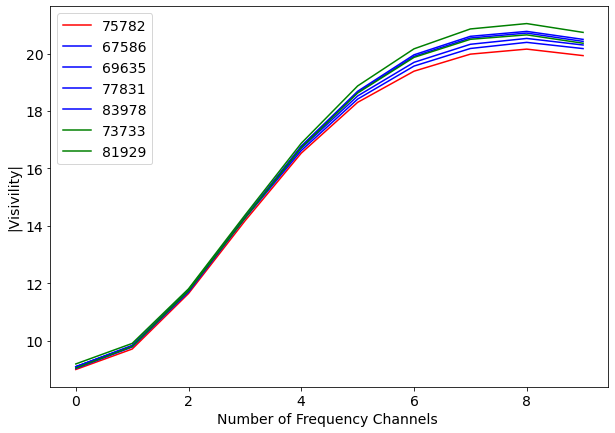

In [14]:
plt.figure(figsize=(10,7))


plt.plot( np.abs(c_data.get_data(n[3])[1]) , 'r', label='{}'.format(n[3]))

plt.plot( np.abs(c_data.get_data(n[0])[1]) , 'b', label='{}'.format(n[0]))
plt.plot( np.abs(c_data.get_data(n[1])[1]) , 'b', label='{}'.format(n[1]))
plt.plot( np.abs(c_data.get_data(n[4])[1]) , 'b', label='{}'.format(n[4]))
plt.plot( np.abs(c_data.get_data(n[6])[1]) , 'b', label='{}'.format(n[6]))

plt.plot( np.abs(c_data.get_data(n[2])[1]) , 'g', label='{}'.format(n[2]))
plt.plot( np.abs(c_data.get_data(n[5])[1]) , 'g', label='{}'.format(n[5]))

plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visivility|')

plt.legend()
plt.rcParams.update({'font.size': 15})
plt.show()


In [15]:

from hera_cal import utils
from hera_cal.redcal import get_reds

red_gains = redcal_iteration(hd)
#custom_red_gains = redcal_iteration_custom(hd)



In [16]:
#aa[0].append((0,1,'ee'))

aa

NameError: name 'aa' is not defined

In [16]:

hd.antpairs

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (7, 7),
 (7, 8),
 (7, 9),
 (8, 8),
 (8, 9),
 (9, 9)]

In [17]:
working_antpairs = []
error_antpairs = []

for i in range(len(hd.antpairs)):
    try:
        customized_groups = custom_reds2(hd, c_data, 3,1)
        
        bb = (hd.antpairs[i][0],hd.antpairs[i][1], 'ee' )
        customized_groups[0].append(bb) ## Appending random antenna pair into redundant baseline group
        customized_groups[0] = list(set(customized_groups[0])) ## Removing dublicated tuples, (i,j,'ee')
        custom_red_gains = redcal_iteration_custom2(hd)
        print('Complete', bb)
        working_antpairs.append(bb)
        print(' ')
    except AssertionError:
        error_antpairs.append(bb)
        print('Error',(bb))

redcal_iteration_custom2 Complete
Complete (0, 0, 'ee')
 
Error (0, 1, 'ee')
Error (0, 2, 'ee')
redcal_iteration_custom2 Complete
Complete (0, 3, 'ee')
 
Error (0, 4, 'ee')
Error (0, 5, 'ee')
Error (0, 6, 'ee')
Error (0, 7, 'ee')
Error (0, 8, 'ee')
Error (0, 9, 'ee')
redcal_iteration_custom2 Complete
Complete (1, 1, 'ee')
 
redcal_iteration_custom2 Complete
Complete (1, 2, 'ee')
 
Error (1, 3, 'ee')
Error (1, 4, 'ee')
redcal_iteration_custom2 Complete
Complete (1, 5, 'ee')
 
redcal_iteration_custom2 Complete
Complete (1, 6, 'ee')
 
Error (1, 7, 'ee')
redcal_iteration_custom2 Complete
Complete (1, 8, 'ee')
 
redcal_iteration_custom2 Complete
Complete (1, 9, 'ee')
 
redcal_iteration_custom2 Complete
Complete (2, 2, 'ee')
 
Error (2, 3, 'ee')
redcal_iteration_custom2 Complete
Complete (2, 4, 'ee')
 
redcal_iteration_custom2 Complete
Complete (2, 5, 'ee')
 
redcal_iteration_custom2 Complete
Complete (2, 6, 'ee')
 
Error (2, 7, 'ee')
redcal_iteration_custom2 Complete
Complete (2, 8, 'ee')
 

In [18]:
working_antpairs

[(0, 0, 'ee'),
 (0, 3, 'ee'),
 (1, 1, 'ee'),
 (1, 2, 'ee'),
 (1, 5, 'ee'),
 (1, 6, 'ee'),
 (1, 8, 'ee'),
 (1, 9, 'ee'),
 (2, 2, 'ee'),
 (2, 4, 'ee'),
 (2, 5, 'ee'),
 (2, 6, 'ee'),
 (2, 8, 'ee'),
 (2, 9, 'ee'),
 (3, 3, 'ee'),
 (3, 4, 'ee'),
 (3, 5, 'ee'),
 (3, 7, 'ee'),
 (3, 8, 'ee'),
 (3, 9, 'ee'),
 (4, 4, 'ee'),
 (4, 5, 'ee'),
 (4, 6, 'ee'),
 (4, 8, 'ee'),
 (4, 9, 'ee'),
 (5, 5, 'ee'),
 (5, 6, 'ee'),
 (5, 7, 'ee'),
 (5, 8, 'ee'),
 (5, 9, 'ee'),
 (6, 6, 'ee'),
 (6, 7, 'ee'),
 (6, 8, 'ee'),
 (6, 9, 'ee'),
 (7, 7, 'ee'),
 (7, 8, 'ee'),
 (7, 9, 'ee'),
 (8, 8, 'ee'),
 (8, 9, 'ee'),
 (9, 9, 'ee')]

In [255]:
from hera_cal import utils


# Adding error to Logi_cal.
customized_groups = custom_reds2(hd, c_data, 3,4)

customized_groups[0].append(working_antpairs[27])
customized_groups[0] = list(set(customized_groups[0]))

print(customized_groups)
#customized_groups[0].remove((0,3,'ee'))
custom_red_gains = redcal_iteration_custom2(hd)

[[(0, 3, 'ee'), (5, 7, 'ee'), (2, 5, 'ee'), (6, 9, 'ee')], [(1, 4, 'ee'), (5, 8, 'ee')], [(4, 7, 'ee')], [(0, 4, 'ee')], [(1, 5, 'ee'), (5, 9, 'ee')], [(2, 6, 'ee'), (3, 7, 'ee'), (4, 8, 'ee')], [(0, 1, 'ee'), (4, 5, 'ee')], [(1, 2, 'ee'), (3, 4, 'ee'), (5, 6, 'ee'), (8, 9, 'ee')], [(7, 8, 'ee')], [(0, 7, 'ee')], [(1, 8, 'ee')], [(2, 9, 'ee')], [(1, 3, 'ee'), (2, 4, 'ee'), (5, 7, 'ee'), (6, 8, 'ee')], [(0, 5, 'ee'), (1, 6, 'ee'), (3, 8, 'ee'), (4, 9, 'ee')], [(0, 2, 'ee'), (3, 5, 'ee'), (4, 6, 'ee'), (7, 9, 'ee')], [(1, 7, 'ee'), (2, 8, 'ee')], [(0, 8, 'ee'), (1, 9, 'ee')], [(2, 3, 'ee'), (6, 7, 'ee')], [(0, 6, 'ee'), (3, 9, 'ee')], [(2, 7, 'ee')], [(0, 9, 'ee')], [(3, 6, 'ee')]]
redcal_iteration_custom2 Complete


In [132]:
from hera_cal import utils


# Normal Logi_cal.
customized_groups = custom_reds2(hd, c_data, 3,4)
print(customized_groups)

custom_red_gains = redcal_iteration_custom2(hd)

[[(0, 3, 'ee'), (2, 5, 'ee'), (6, 9, 'ee')], [(1, 4, 'ee'), (5, 8, 'ee')], [(4, 7, 'ee')], [(0, 4, 'ee')], [(1, 5, 'ee'), (5, 9, 'ee')], [(2, 6, 'ee'), (3, 7, 'ee'), (4, 8, 'ee')], [(0, 1, 'ee'), (4, 5, 'ee')], [(1, 2, 'ee'), (3, 4, 'ee'), (5, 6, 'ee'), (8, 9, 'ee')], [(7, 8, 'ee')], [(0, 7, 'ee')], [(1, 8, 'ee')], [(2, 9, 'ee')], [(1, 3, 'ee'), (2, 4, 'ee'), (5, 7, 'ee'), (6, 8, 'ee')], [(0, 5, 'ee'), (1, 6, 'ee'), (3, 8, 'ee'), (4, 9, 'ee')], [(0, 2, 'ee'), (3, 5, 'ee'), (4, 6, 'ee'), (7, 9, 'ee')], [(1, 7, 'ee'), (2, 8, 'ee')], [(0, 8, 'ee'), (1, 9, 'ee')], [(2, 3, 'ee'), (6, 7, 'ee')], [(0, 6, 'ee'), (3, 9, 'ee')], [(2, 7, 'ee')], [(0, 9, 'ee')], [(3, 6, 'ee')]]
redcal_iteration_custom2 Complete


In [16]:
from hera_cal import utils

customized_groups = custom_reds2(hd, c_data, 3,150)
custom_red_gains = redcal_iteration_custom2(hd)

all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
get_baseline_cluster2 complete
get_custom_reds complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
get_baseline_cluster2 complete
get_custom_reds complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
get_baseline_cluster2 complete
get_custom_reds complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_reds_function complete
cluster_baselines2 complete
all_red

In [126]:
# red_gains_60
# custom_red_gains_60

# red_gains_1
# custom_red_gains_1 

In [20]:
#print(data)
print(type(red_gains))
print(type(custom_red_gains))
len(customized_groups)-228


<class 'dict'>
<class 'dict'>


-206

In [21]:
def get_baseline_length_angle(index_number):
    baseline_length = []
    baseline_angle = []
    for i in range(len(reds_all)):
        k = index_number
        a = reds_all[i][k][0]
        b = reds_all[i][k][1]

        x1 = hd.antpos[a][0]
        y1 = hd.antpos[a][1]

        x2 = hd.antpos[b][0]
        y2 = hd.antpos[b][1]
        
        r = np.sqrt( np.square(x1-x2)+ np.square(y1-y2) )
        baseline_length.append(r)
        
        #bl_ang = np.arctan(abs(y1-y2)/abs(x1-x2)) *180/np.pi
        #bl_ang = np.arcsin(abs(y1-y2)/abs(r)) *180/np.pi
        bl_ang = np.arccos(abs(x1-x2)/abs(r)) *180/np.pi
        baseline_angle.append(bl_ang)
        
#         z1 = hd.antpos[a][2]
#         z2 = hd.antpos[b][2]
        
#         lambda_z = abs(z1-z2)
#         bl_ang = np.arcsin(lambda_z/r) *180/np.pi
#         baseline_angle.append(bl_ang)
    return baseline_length, baseline_angle

r2 = red_base[2]
r2.sort()
r2=np.round(r2[1:],7)

get_reds_array = [reds_all, get_baseline_length_angle(0)[0], get_baseline_length_angle(0)[1]]


## Put the lengths and angles in a dictionary

len_ang_dict = {'length':{},'angle':{}}

for i in range(len(reds_all)):
    bl_len = get_reds_array[1][i]
    #bl_len_key = "%03d" % (10. * bl_len)
    bl_len_key = str(int(np.round( (10. * bl_len), 0)))
    
    if bl_len_key in len_ang_dict['length']:
        len_ang_dict['length'][bl_len_key].append(reds_all[i])
    else:
        len_ang_dict['length'][bl_len_key]=[]
        len_ang_dict['length'][bl_len_key].append(reds_all[i])
    
    bl_ang = get_reds_array[2][i]
    #bl_ang_key =  "%03d" % (10 * bl_ang)
    bl_ang_key = str(int(np.round( (10. * bl_ang), 0)))
                               
    if bl_ang_key in len_ang_dict['angle']:
        len_ang_dict['angle'][bl_ang_key].append(reds_all[i])
    else:
        len_ang_dict['angle'][bl_ang_key]=[]
        len_ang_dict['angle'][bl_ang_key].append(reds_all[i])
    


In [36]:
hd.antpos[0]-hd.antpos[7]

print(len_ang_dict['length'].keys())
len_ang_dict['length']['292']

dict_keys(['146', '253', '292', '386', '438'])


[[(0, 2, 'nn'), (3, 5, 'nn'), (4, 6, 'nn'), (7, 9, 'nn')],
 [(1, 7, 'nn'), (2, 8, 'nn')],
 [(0, 8, 'nn'), (1, 9, 'nn')]]

In [28]:
ckeys = red_gains.keys()
print(ckeys)

## Convert the dictionary into an array
ckeys = list(ckeys)
ckeys = np.array(bl_len_key)
v_model_custom = custom_red_gains['v_omnical']


v_model_red = red_gains['v_omnical']


dict_keys(['g_firstcal', 'gf_firstcal', 'g_omnical', 'gf_omnical', 'chisq', 'chisq_per_ant', 'v_omnical', 'vf_omnical', 'vns_omnical', 'fc_meta', 'omni_meta'])


In [24]:
a = 2
antenna_pair = 0,1
#antenna_pair = ant_list[a][0],ant_list[a][1]

aa =v_model_red.get_data(antenna_pair)['ee']
bb = v_model_custom.get_data(antenna_pair)['ee']
cc = true_data.get_data(antenna_pair)


plt.figure(figsize=(12,8))
plt.plot(np.abs(aa[0]), 'r', label = 'Original redcal')
plt.plot(np.abs(bb[0]), 'b', label = 'Modified redcal')
plt.plot(np.abs(cc[0]), 'g', label = 'True data')
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Visibility|')
plt.title('Antenna pair = {}'.format(antenna_pair))
plt.legend()
plt.show()

ant_list[a]

NameError: name 'v_model_red' is not defined

In [106]:
# for i in range(len(ant_list)):
#     a = i
#     #antenna_pair = 0,1
#     antenna_pair = ant_list[a][0],ant_list[a][1]

#     aa =v_model_red.get_data(antenna_pair)['ee']
#     bb = v_model_custom.get_data(antenna_pair)['ee']
#     cc = true_data.get_data(antenna_pair)


#     plt.figure(figsize=(12,8))
#     plt.plot(np.abs(aa[0]), 'r', label = 'Original redcal')
#     plt.plot(np.abs(bb[0]), 'b', label = 'Modified redcal')
#     plt.plot(np.abs(cc[0]), 'g', label = 'True data')
#     plt.xlabel('Number of Frequency Channels ')
#     plt.ylabel('|Visibility|')
#     plt.title('Antenna pair = {}'.format(antenna_pair))
#     plt.legend()
#     plt.savefig('plots/Visibility_plots/Antenna_pair{}'.format(antenna_pair))
#     plt.show()

ant_list[a]

NameError: name 'ant_list' is not defined

(10, 10, 10)


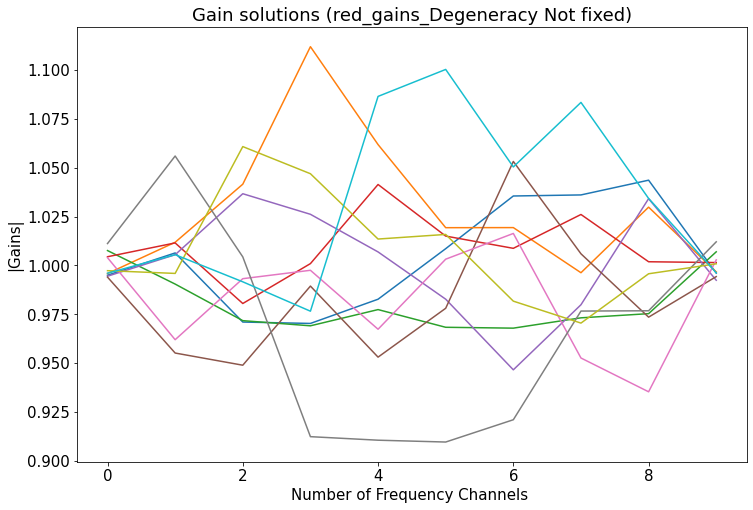

In [133]:
## dict_keys(['g_firstcal', 'gf_firstcal', 'g_omnical', 'gf_omnical', 'chisq', 'chisq_per_ant', 'v_omnical',
##            'vf_omnical', 'vns_omnical', 'fc_meta', 'omni_meta'])

gains_per_key = red_gains['g_omnical']   ## Plot redcal gain solution
#gains_per_key = custom_red_gains['g_omnical']  ## Plot redcal gain solution from modified redcal_code


##  Combining a list of 2D arrays into a 3D array
gain_3D = []

for i in range(len(gains_per_key)):
    gain_3D.append( gains_per_key[i,'Jee' ] )

gain_3D = np.array(gain_3D)
print(gain_3D.shape)



Num_Freq_Chan = len(gain_3D[0][0])

plt.figure(figsize=(12,8))
for i in range(len(gain_3D)):
    plt.plot(abs(gain_3D[i][0]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (red_gains_Degeneracy Not fixed)')
#plt.title('Gain solutions (custom_red_gains_Degeneracy Not fixed)')
#plt.legend()
plt.show()

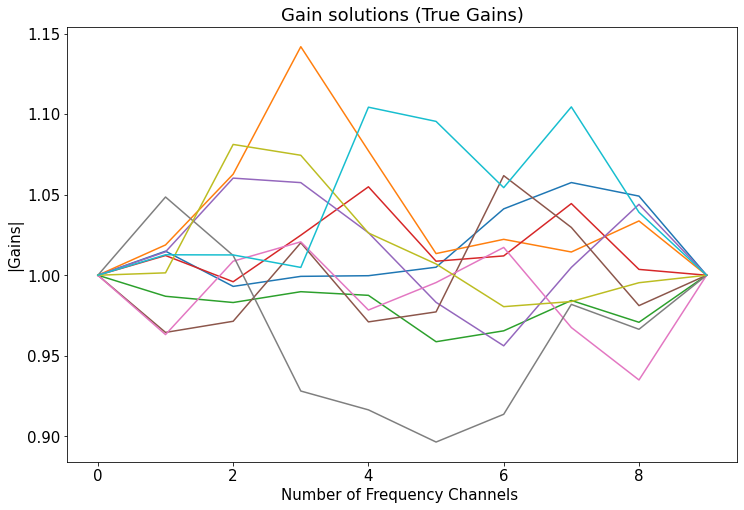

In [134]:
import utils

#true_gains, _= hc.io.load_cal('non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.calfits')
true_gains, _= hc.io.load_cal('../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.calfits')

plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot(abs(true_gains[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (True Gains)')
#plt.legend()
plt.show()


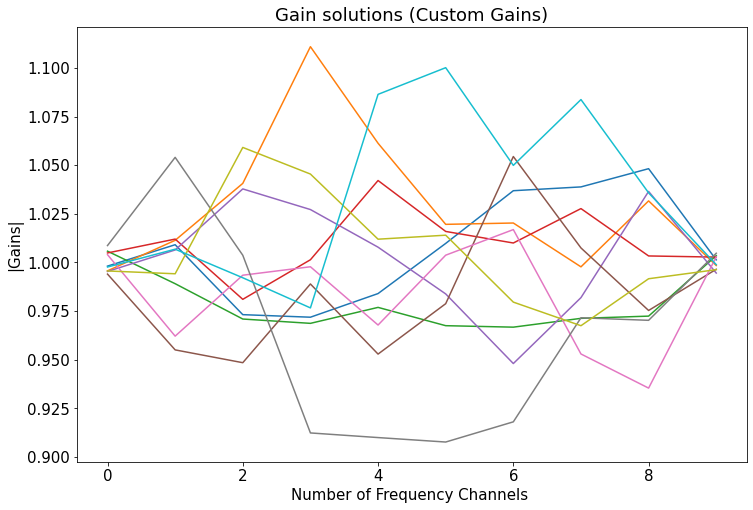

In [135]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot(abs(custom_red_gains['g_omnical'][( int('{}'.format(i)) , 'Jee' )][0] ))
    #plt.plot(abs(red_gains['g_omnical'][( int('{}'.format(i)) , 'Jee' )][0] ))
    #plt.plot(abs(true_gains[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (Custom Gains)')
#plt.legend()
plt.show()

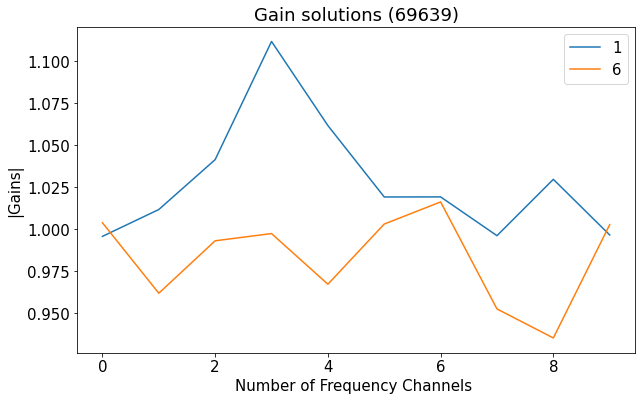

In [136]:
n = hd.baseline_array  ##  all 7750 baselines, N.B need to fix this to give only baselines in a selected 
                       ##  redundant baseline group.
len(n)

baseline_ID = n[125] ## index the number of baselines in the redundant baseline group
base_ant = hd.baseline_to_antnums(baseline_ID)  ## returns the antenna numbers corresponding to a given baseline ID

plt.figure(figsize=(10,6))
plt.plot(abs(gain_3D[base_ant[0]][0]), label='{}'.format(base_ant[0]))
plt.plot(abs(gain_3D[base_ant[1]][0]), label='{}'.format(base_ant[1]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions ({})'.format(baseline_ID))
plt.legend()
plt.show()

In [137]:
def fix_redcal_degeneracies(data_file, red_gains, true_gains, outfile=None, 
                            overwrite=False):
    """
    Use the true (input) gains to fix the degeneracy directions in a set of 
    redundantly-calibrated gain solutions. This replaces the absolute 
    calibration that would normally be applied to a real dataset in order to 
    fix the degeneracies.
    
    Note that this step should only be using the true gains to fix the 
    degeneracies, and shouldn't add any more information beyond that.
    
    N.B. This is just a convenience function for calling the 
    remove_degen_gains() method of the redcal.RedundantCalibrator class. It 
    also assumes that only the 'ee' polarization will be used.
    
    Parameters
    ----------
    data_file : str
        Filename of the data file (uvh5 format) that is being calibrated. This 
        is only used to extract information about redundant baseline groups.
    
    red_gains : dict of array_like
        Dict containing 2D array of complex gain solutions for each antenna 
        (and polarization).
    
    true_gains : dict
        Dictionary of true (input) gains as a function of frequency. 
        Expected format: 
            key = antenna number (int)
            value = 1D numpy array of shape (Nfreqs,)
    
    outfile : str, optional
        If specified, save the updated gains to a calfits file. Default: None.
    
    overwrite : bool, optional
        If the output file already exists, whether to overwrite it. 
        Default: False.
    
    Returns
    -------
    new_gains : dict
        Dictionary with the same items as red_gains, but where the degeneracies 
        have been fixed in the gain solutions.
    
    uvc : UVCal, optional
        If outfile is specified, also returns a UVCal object containing the 
        updated gain solutions.
    """
    # Get ntimes from gain array belonging to first key in the dict
    #ntimes = red_gains[list(red_gains.keys())[0]].shape[0]
    ntimes = 1
    # Load data file and get redundancy information
    hd = hc.io.HERAData(data_file)
    reds = hc.redcal.get_reds(hd.antpos, pols=['ee',])
    
    # Create calibrator and fix degeneracies
    RedCal = hc.redcal.RedundantCalibrator(reds)
    new_gains = RedCal.remove_degen_gains(red_gains, 
                                          degen_gains=true_gains, 
                                          mode='complex')
    
    # Save as file if requested
    if outfile is not None:
        uvc = hc.redcal.write_cal(outfile,
                                  new_gains,
                                  hd.freqs,
                                  hd.times,
                                  write_file=True,
                                  return_uvc=True,
                                  overwrite=overwrite)
        return new_gains, uvc
    else:
        # Just return the updated gain dict
        return new_gains

In [138]:
print(filename1)

red_gains_fixed = fix_redcal_degeneracies(filename1, red_gains['g_omnical'],true_gains)
custom_red_gains_fixed = fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)

../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5


Telescope hera_sim is not in known_telescopes.


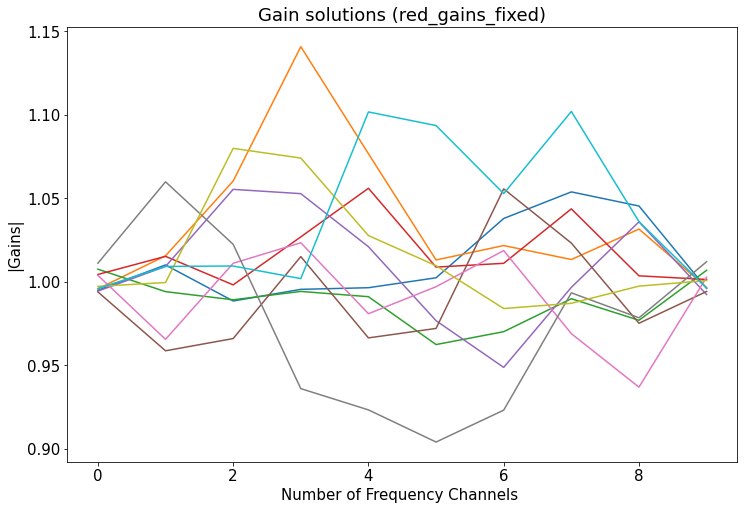

In [139]:

plt.figure(figsize=(12,8))
for i in range(len(red_gains_fixed)):
    plt.plot(abs(red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (red_gains_fixed)')
#plt.legend()
plt.show()

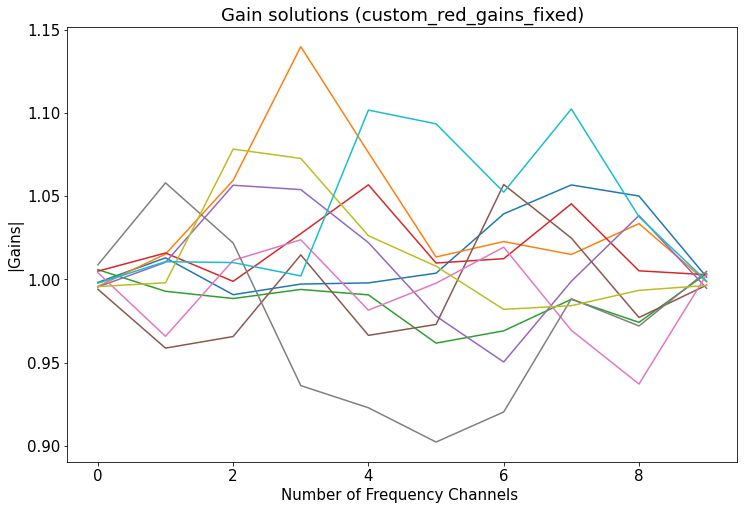

In [140]:
plt.figure(figsize=(12,8))
for i in range(len(custom_red_gains_fixed)):
    plt.plot(abs(custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (custom_red_gains_fixed)')
#plt.legend()
plt.show()

In [348]:
custom_red_gains_fixed
diff_custom_true = []
diff_red_true = []
diff_custom_red = []

for i in range(len(custom_red_gains_fixed)):
    a = abs(true_gains[( int('{}'.format(i)) , 'Jee' )][0] )  ## true gains
    b1 = abs(custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] )  ## Modified Redcal code
    b2 = abs(red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] )  ## original Redcal code
    
    diff_custom_true.append(a-b1)   ### Difference between gains from Modified Redcal code and True gains
    diff_red_true.append(a-b2)      ### Difference between gains from original Redcal code and True gains
    diff_custom_red.append(b2-b1)    ### Difference between gains from original Redcal code and Modified Redcal code




In [431]:
custom_red_gains_fixed
diff_custom_true = []
diff_red_true = []
diff_custom_red = []

for i in range(len(custom_red_gains_fixed)):
    a = (true_gains[( int('{}'.format(i)) , 'Jee' )] )  ## true gains
    b1 = (custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )] )  ## Modified Redcal code
    b2 = (red_gains_fixed[( int('{}'.format(i)) , 'Jee' )] )  ## original Redcal code
    
    diff_custom_true.append(a-b1)   ### Difference between gains from Modified Redcal code and True gains
    diff_red_true.append(a-b2)      ### Difference between gains from original Redcal code and True gains
    diff_custom_red.append(b2-b1)    ### Difference between gains from original Redcal code and Modified Redcal code



### Chi Square Test

- A chi-square goodness of fit test determines if sample data matches a population. For more details on this type, see: Goodness of Fit Test.</br>
- A chi-square test for independence compares two variables in a contingency table to see if they are related. In a more general sense, it tests to see whether distributions of categorical variables differ from each another.
    - A very small chi square test statistic means that your observed data fits your expected data extremely well. In other words, there is a relationship.
    - A very large chi square test statistic means that the data does not fit very well. In other words, there isn’t a relationship.





### $\chi^2- $ like statistic
$\chi^2 -$ like statistic take the Sum [(gain.real - gain_true.real)^2 + (gain.imag - gain_true.imag)^2] For now 
we are summing over all times and frequencies, therefore each antenna will have only one value.

$\chi^2 = \sum \frac{ (O_i - E_i)^2}{E_i}$ .............................................................................. (1),

$\chi^2 = \sum (O_i - E_i)^2$ ......................................................................... (2),

where <b>"O"</b>  is the observed value and <b>"E"</b> is the expected value (true gains)

In [456]:
custom_red_gains_fixed
X_custom_true = []
X_red_true = []
X_custom_red = []

for i in range(len(custom_red_gains_fixed)):
    a = (true_gains[( int('{}'.format(i)) , 'Jee' )] )  ## true gains
    b1 = (custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )] )  ## Modified Redcal code
    b2 = (red_gains_fixed[( int('{}'.format(i)) , 'Jee' )] )  ## original Redcal code
    
    X1_custom_true = np.sum(np.square(a-b1) )
    X1_red_true = np.sum(np.square(a-b2) )
    X1_custom_red =np.sum(np.square(b2-b1))
    

    X_custom_true.append((X1_custom_true))   ### Chi squared-like statistic between gains from Modified Redcal code and True gains
    X_red_true.append((X1_red_true))     ### Chi squared-like statistic between gains from original Redcal code and True gains
    X_custom_red.append(X1_custom_red)   ### Chi squared-like statistic between gains from original Redcal code and Modified Redcal code



In [443]:
X_custom_true[0]

(-0.0005028155979135112+0.00013056410188456912j)

In [351]:
np.real(diff_custom_true[0][0])

array([ 4.08542337e-04, -7.09637118e-04, -6.62653741e-04, -2.54595626e-04,
       -1.03206033e-04, -9.65385494e-05,  3.48106964e-04, -9.29926573e-04,
       -1.76244491e-03, -1.53003913e-03])

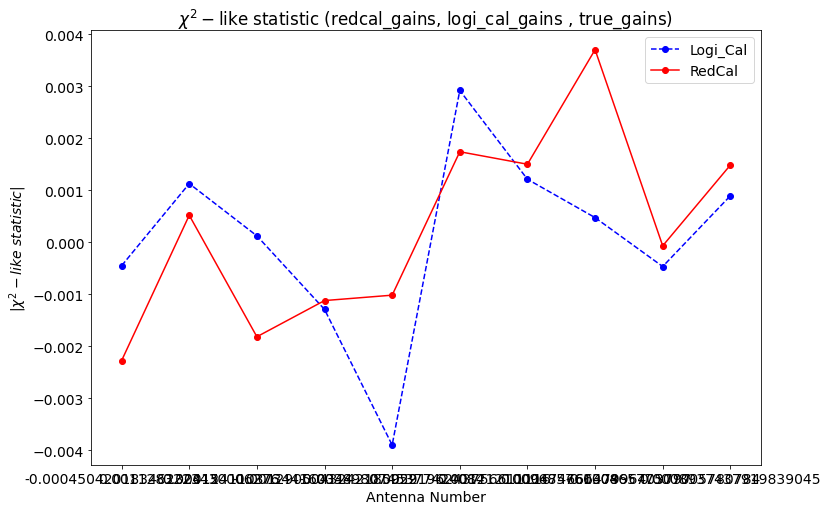

In [584]:
y_values = X_custom_true
x_values = np.arange(len(y_values))

plt.figure(figsize=(12,8))

plt.plot(np.real(X_custom_true),'bo--', label='Logi_Cal')
plt.plot(np.real(X_red_true),'ro-', label='RedCal')

plt.xlabel('Antenna Number')
plt.ylabel('|$\chi^2-like~ statistic$|')
#plt.title('custom_red_gains_fixed vs red_gains_fixed')

# positions = np.arange(len(y_values))
# labels = x_values
plt.xticks(positions, labels)
plt.title('$\chi^2-$like statistic (redcal_gains, logi_cal_gains , true_gains)')
plt.legend()
#plt.savefig('../plots/Testing_logi-cal/gains/chi2_0red_groups_10array.jpeg')
plt.show()

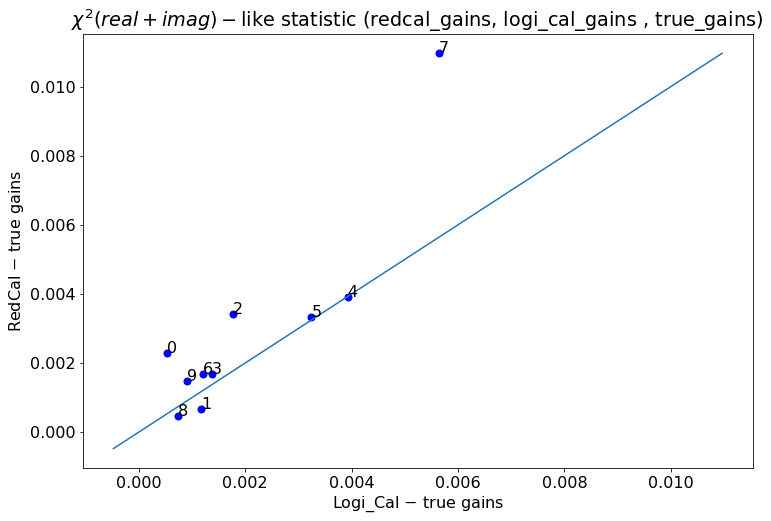

array([-0.00047788,  0.0007934 ,  0.00206469,  0.00333598,  0.00460726,
        0.00587855,  0.00714984,  0.00842112,  0.00969241,  0.0109637 ])

In [524]:
# x_values = np.real(X_custom_true)  ## Logi_Cal
# y_values = np.real(X_red_true)    ## RedCal

# x_values = np.imag(X_custom_true)  ## Logi_Cal
# y_values = np.imag(X_red_true)    ## RedCal

x_values = np.abs(X_custom_true)  ## Logi_Cal
y_values = np.abs(X_red_true)    ## RedCal

fit_line = np.linspace(np.min(x_values)-0.001, np.max(y_values), len(x_values))
plt.figure(figsize=(12,8))
for i in range(len(y_values)):
    plt.plot(x_values[i], y_values[i], 'bo', markersize=7)
    plt.annotate('{}'.format(i), (x_values[i], y_values[i]) )

plt.plot(fit_line,fit_line)
plt.xlabel('Logi_Cal $-$ true gains')
plt.ylabel('RedCal $-$ true gains')
# plt.title('$\chi^2 (Real)-$like statistic (redcal_gains, logi_cal_gains , true_gains) ')
plt.title('$\chi^2 (real+imag)-$like statistic (redcal_gains, logi_cal_gains , true_gains) ')

#plt.savefig('../plots/Testing_logi-cal/gains/chi2_0red_groups_10array.jpeg')
plt.show()




np.max(x_values)
fit_line

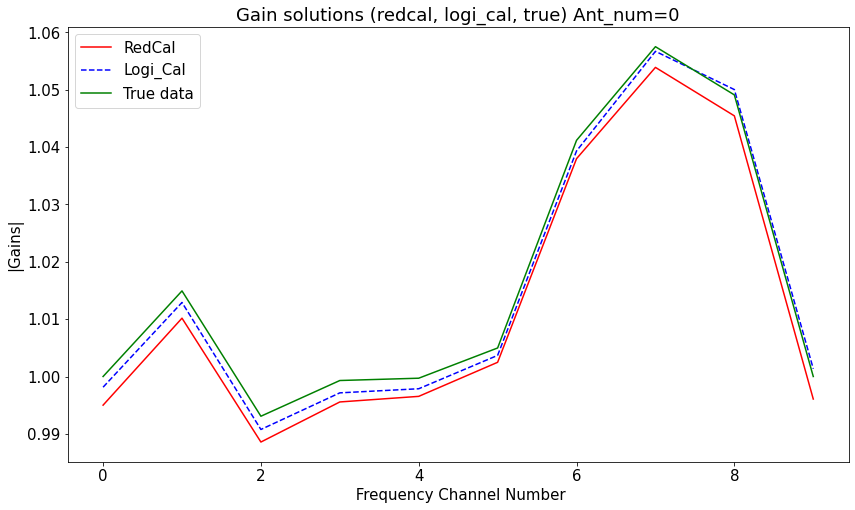

In [146]:
i = 0 ## Antenna Number
j = 0 ## Time sample
plt.figure(figsize=(14,8))
plt.plot(abs(red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][j] ), 'r', label='RedCal')
plt.plot(abs(custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][j] ), 'b--', label='Logi_Cal' )
plt.plot(abs(true_gains[( int('{}'.format(i)) , 'Jee' )][j] ),'g', label = 'True data')
plt.xlabel(' Frequency Channel Number')
plt.ylabel('|Gains|')
plt.title('Gain solutions (redcal, logi_cal, true) Ant_num={}'.format(i))
plt.legend()
plt.show()

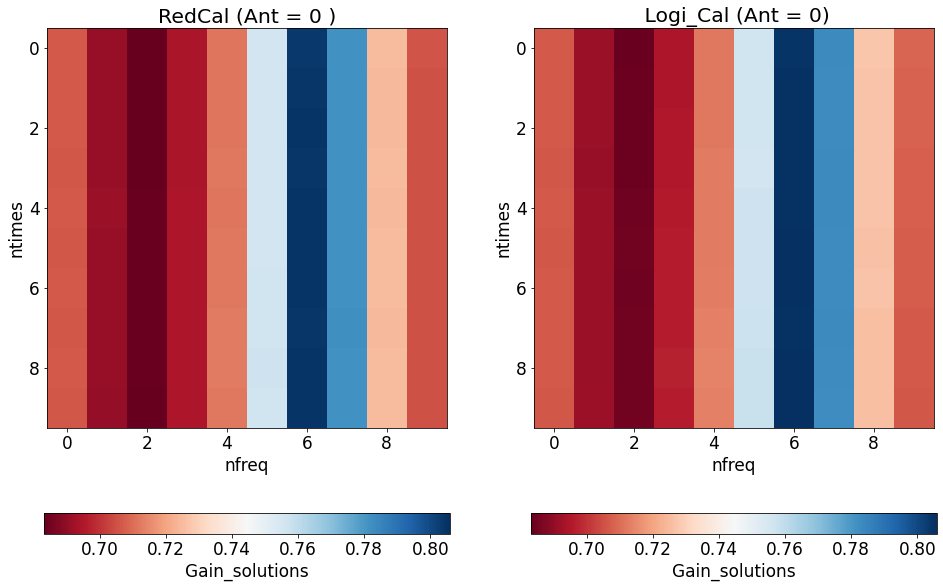

In [352]:
i = 0 ## Antenna Number

# tg_max = abs(true_gains[(0, 'Jee')]).max()
# tg_min = abs(true_gains[(0, 'Jee')]).min()

v_lim_array = np.array([custom_red_gains_fixed[(i,'Jee')].max(),red_gains_fixed[(i,'Jee')].max(), 
                        custom_red_gains_fixed[(i,'Jee')].min(), red_gains_fixed[(i,'Jee')].min()])

tg_max = (np.real(v_lim_array.max()))
tg_min = (np.real(v_lim_array.min()))




fig = plt.figure(figsize=(16,10.5))
plt.rcParams.update({'font.size': 17})
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(np.real(red_gains_fixed[(i,'Jee')]), cmap='RdBu', clim=(tg_min, tg_max))
ax.set_title('RedCal (Ant = {} )'.format(i))
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.colorbar(orientation='horizontal', label='Gain_solutions')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(np.real(custom_red_gains_fixed[(i,'Jee')]), cmap='RdBu', clim=(tg_min, tg_max) )
ax.set_title(' Logi_Cal (Ant = {})'.format(i))
plt.colorbar(orientation='horizontal', label='Gain_solutions')
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.show()


In [433]:
print(abs(diff_custom_true[i].max()))
print(abs(diff_red_true[i].max()))
print('')

print(abs(diff_custom_true[i].min()))
print(abs(diff_red_true[i].min()))
v_lim_array = np.array([diff_custom_true[i].max(),diff_red_true[i].max(), diff_custom_true[i].min(), diff_red_true[i].min()])

print('')
print(abs(v_lim_array).max())
print(abs(v_lim_array).min())

abs(v_lim_array)

print(np.imag(diff_custom_true[0][0]))

(true_gains[(0,'Jee')].imag - custom_red_gains_fixed[(0,'Jee')].imag )[0]


0.005613591425871665
0.006633168407305779

0.0014221275064899867
0.0024547873356094672

0.006633168407305779
0.0014221275064899867
[ 0.00222809  0.00341474  0.00381745  0.00324129  0.00272756  0.00207716
  0.00249831  0.00222981  0.00040359 -0.00038575]


array([ 0.00222809,  0.00341474,  0.00381745,  0.00324129,  0.00272756,
        0.00207716,  0.00249831,  0.00222981,  0.00040359, -0.00038575])

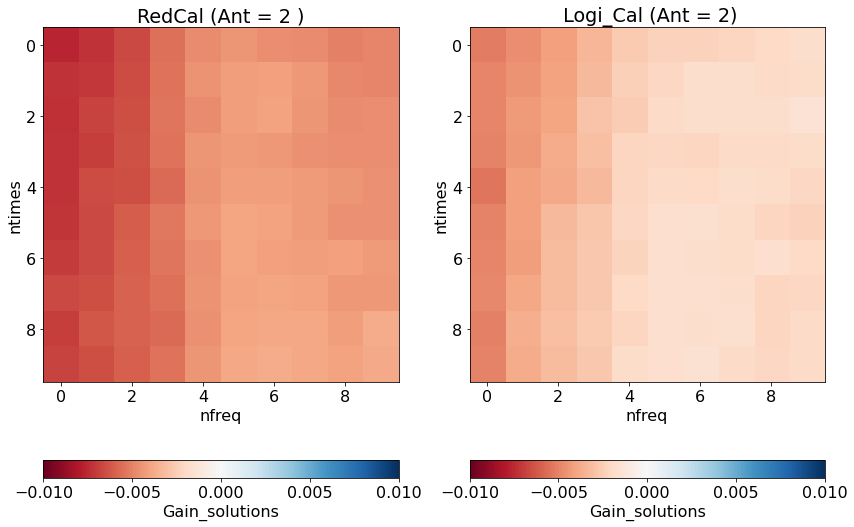

In [436]:
# tg_max = abs(diff_custom_true[i].max())
# # tg_min = abs(diff_custom_true[i].min())
# # tg_min = abs(diff_red_true[i]).min()

i = 2 ## Antenna Number


v_lim_array = np.array([diff_custom_true[i].max(),diff_red_true[i].max(), diff_custom_true[i].min(), diff_red_true[i].min()])

# tg_max = (np.real(v_lim_array).max())
# tg_min = (np.real(v_lim_array).min())

tg_max = 0.01
tg_min = -0.01


#y=np.round(np.linspace(tg_min,tg_max,6),3)

fig = plt.figure(figsize=(14,9.5))
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(np.imag(diff_red_true[i]), cmap='RdBu', clim=(tg_min, tg_max))
ax.set_title('RedCal (Ant = {} )'.format(i))
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.colorbar(orientation='horizontal', label='Gain_solutions')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(np.imag(diff_custom_true[i]), cmap='RdBu', clim=(tg_min, tg_max) )
ax.set_title(' Logi_Cal (Ant = {})'.format(i))
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.colorbar(orientation='horizontal', label='Gain_solutions')
#imgplot.colorbar.set_ticks(y)
plt.show()


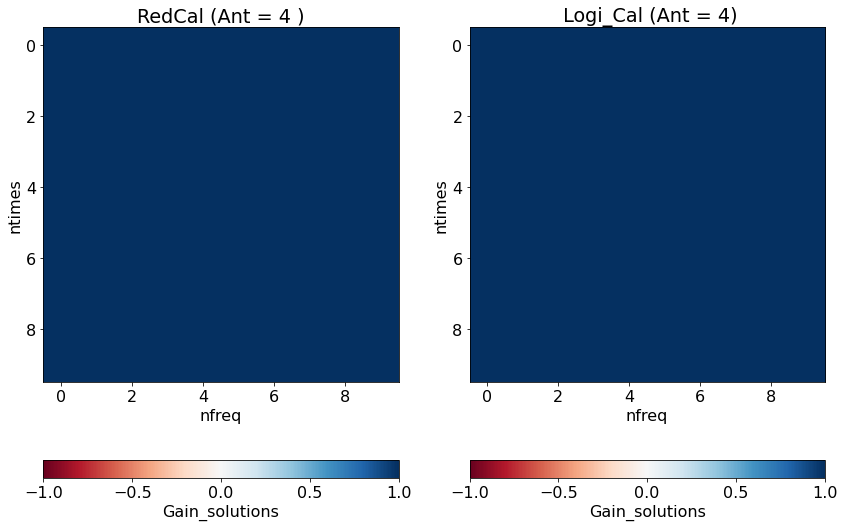

In [407]:
# tg_max = abs(diff_custom_true[i].max())
# # tg_min = abs(diff_custom_true[i].min())
# # tg_min = abs(diff_red_true[i]).min()

i = 4 ## Antenna Number


v_lim_array = np.array([diff_custom_true[i].max(),diff_red_true[i].max(), diff_custom_true[i].min(), diff_red_true[i].min()])

# tg_max = (np.real(v_lim_array).max())
# tg_min = (np.real(v_lim_array).min())

tg_max = 1
tg_min = -1


#y=np.round(np.linspace(tg_min,tg_max,6),3)

fig = plt.figure(figsize=(14,9.5))
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(np.iscomplex(diff_red_true[i]), cmap='RdBu', clim=(tg_min, tg_max))
ax.set_title('RedCal (Ant = {} )'.format(i))
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.colorbar(orientation='horizontal', label='Gain_solutions')

ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(np.iscomplex(diff_custom_true[i]), cmap='RdBu', clim=(tg_min, tg_max) )
ax.set_title(' Logi_Cal (Ant = {})'.format(i))
plt.xlabel('nfreq')
plt.ylabel('ntimes')
plt.colorbar(orientation='horizontal', label='Gain_solutions')
#imgplot.colorbar.set_ticks(y)
plt.show()


In [34]:
print(diff_custom_true[0][0])

sq_diff = np.square(diff_custom_true)
#np.shape(true_gains[(0,'Jee')])


## sq_diff shape, sq_diff[antenna_number][time_sample_index][frequency_channel]
sq_diff[0]

[ 4.08542337e-04+0.00222809j -7.09637118e-04+0.00341474j
 -6.62653741e-04+0.00381745j -2.54595626e-04+0.00324129j
 -1.03206033e-04+0.00272756j -9.65385494e-05+0.00207716j
  3.48106964e-04+0.00249831j -9.29926573e-04+0.00222981j
 -1.76244491e-03+0.00040359j -1.53003913e-03-0.00038575j]


array([[-4.79749304e-06+1.82054091e-06j, -1.11568755e-05-4.84645480e-06j,
        -1.41338150e-05-5.05929513e-06j, -1.04411662e-05-1.65043842e-06j,
        -7.42895048e-06-5.63001990e-07j, -4.30527357e-06-4.01052008e-07j,
        -6.12038942e-06+1.73936031e-06j, -4.10730005e-06-4.14712366e-06j,
         2.94332929e-06-1.42260106e-06j,  2.19221732e-06+1.18042262e-06j],
       [-3.85653183e-06+1.26501791e-06j, -9.34984770e-06-3.87528920e-06j,
        -1.07127136e-05-7.82878362e-06j, -1.40791206e-05-2.35439532e-06j,
        -8.50272650e-06+7.73400381e-08j, -4.27855300e-06+1.82104313e-07j,
        -5.92889673e-06-9.62945512e-08j, -3.70419247e-06-2.98382621e-06j,
         1.15240653e-06-1.81627596e-06j,  1.09578520e-06+1.08269777e-06j],
       [-6.58851371e-06+1.19148446e-06j, -1.18608005e-05-4.51839957e-06j,
        -1.15670137e-05-7.37733613e-06j, -7.37707355e-06-4.64564577e-06j,
        -6.05553605e-06-6.46141709e-07j, -5.42462887e-06+4.28564934e-07j,
        -4.58344439e-06-1.34456794e-

In [54]:
print(diff_custom_true[0])
print(np.square(diff_custom_true[0]))

sq_diff = np.square(diff_custom_true[0])
#np.shape(true_gains[(0,'Jee')])

sq_diff

[ 4.08542337e-04+0.00222809j -7.09637118e-04+0.00341474j
 -6.62653741e-04+0.00381745j -2.54595626e-04+0.00324129j
 -1.03206033e-04+0.00272756j -9.65385494e-05+0.00207716j
  3.48106964e-04+0.00249831j -9.29926573e-04+0.00222981j
 -1.76244491e-03+0.00040359j -1.53003913e-03-0.00038575j]
[-4.79749304e-06+1.82054091e-06j -1.11568755e-05-4.84645480e-06j
 -1.41338150e-05-5.05929513e-06j -1.04411662e-05-1.65043842e-06j
 -7.42895048e-06-5.63001990e-07j -4.30527357e-06-4.01052008e-07j
 -6.12038942e-06+1.73936031e-06j -4.10730005e-06-4.14712366e-06j
  2.94332929e-06-1.42260106e-06j  2.19221732e-06+1.18042262e-06j]


array([-4.79749304e-06+1.82054091e-06j, -1.11568755e-05-4.84645480e-06j,
       -1.41338150e-05-5.05929513e-06j, -1.04411662e-05-1.65043842e-06j,
       -7.42895048e-06-5.63001990e-07j, -4.30527357e-06-4.01052008e-07j,
       -6.12038942e-06+1.73936031e-06j, -4.10730005e-06-4.14712366e-06j,
        2.94332929e-06-1.42260106e-06j,  2.19221732e-06+1.18042262e-06j])

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


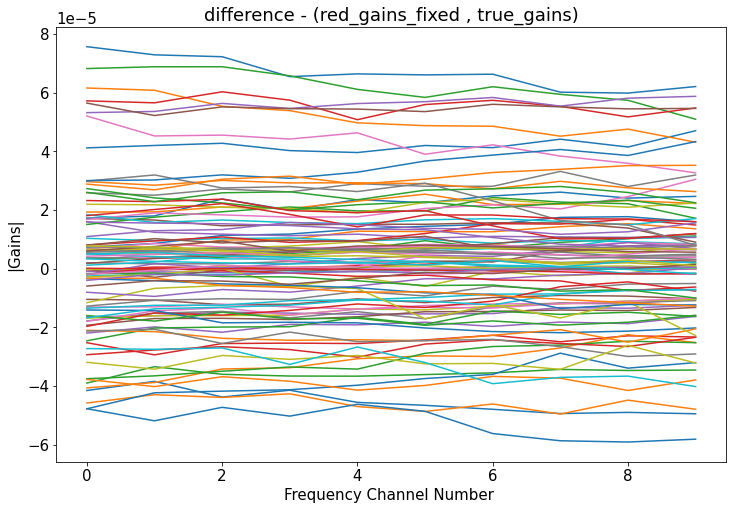

In [497]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot((diff_red_true[i]))
plt.xlabel('Frequency Channel Number ')
plt.ylabel('|Gains|')
#plt.title('custom_red_gains_fixed vs red_gains_fixed')
plt.title('difference - (red_gains_fixed , true_gains)')
plt.show()






In [411]:
# G_file = 'non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.calfits'

# gain_gile = HERACal(G_file)
# gain_data = gain_gile.read()

# print(gain_data[3])

In [412]:
import numpy as np

import uvtools
import hera_cal as hc
import hera_pspec as hp
from pyuvdata import UVCal, UVData
import pyuvdata.utils as uvutils

import utils
import time, copy, sys, yaml

In [413]:
# (4) Fix redundant cal. degeneracies and write new_gains in .calfits format
# (this fixes the degens to the same values as the true/input gains)

#input_data = 'non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5'
input_data = '../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5'

new_gains = custom_red_gains_fixed
input_ext = utils.remove_file_ext(input_data)


uvd_in = UVData()
uvd_in.read_uvh5(input_data)


hc.redcal.write_cal(input_ext+'_new_custom.calfits', new_gains,
                    uvd_in.freq_array.flatten(),
                    np.unique(uvd_in.time_array))


# (5) Load calibration solutions and apply to data for_custom red_cal
uvc_custom = UVCal()
uvc_custom.read_calfits(input_ext+'_new_custom.calfits')
uvd_cal_custom = uvutils.uvcalibrate(uvd_in, uvc_custom, inplace=False, prop_flags=True, 
                              flag_missing=True)    

Telescope hera_sim is not in known_telescopes.


In [414]:
# (4) Fix redundant cal. degeneracies and write new_gains in .calfits format
# (this fixes the degens to the same values as the true/input gains)

# input_data = 'non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5'
input_data = '../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5'


new_gains = red_gains_fixed
input_ext = utils.remove_file_ext(input_data)

uvd_in = UVData()
uvd_in.read_uvh5(input_data)

hc.redcal.write_cal(input_ext+'_new_red.calfits', new_gains,
                    uvd_in.freq_array.flatten(),
                    np.unique(uvd_in.time_array))

# (5) Load calibration solutions and apply to data for_custom red_cal
uvc_red = UVCal()
uvc_red.read_calfits(input_ext+'_new_red.calfits')
uvd_cal_red = uvutils.uvcalibrate(uvd_in, uvc_red, inplace=False, prop_flags=True, 
                              flag_missing=True)       

Telescope hera_sim is not in known_telescopes.


In [415]:

# input_data = '../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5'

# true_data = HERAData("../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.uvh5")
# true_data.read()

#new_gains = red_gains_fixed
input_ext = utils.remove_file_ext(input_data)

uvd_in = UVData()
uvd_in.read_uvh5(input_data)

uvc_red = UVCal()
uvc_red.read_calfits(input_ext+'_new_red.calfits')
uvd_cal_red = uvutils.uvcalibrate(uvd_in, uvc_red, inplace=False, prop_flags=True, 
                              flag_missing=True)


#new_gains = custom_red_gains_fixed
input_ext = utils.remove_file_ext(input_data)

uvc_custom = UVCal()
uvc_custom.read_calfits(input_ext+'_new_custom.calfits')
uvd_cal_custom = uvutils.uvcalibrate(uvd_in, uvc_custom, inplace=False, prop_flags=True, 
                              flag_missing=True)    

Telescope hera_sim is not in known_telescopes.


In [416]:
red_base = true_data.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)

n = red_base[0][1]  
n = np.array(n)     ## Saving a list of redundant baselines in an array.
#rbg = red_base[0][1]

No handles with labels found to put in legend.


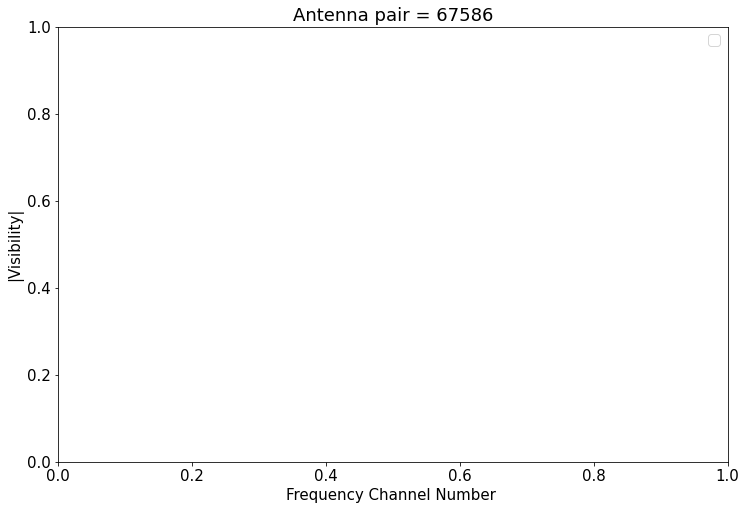

In [270]:
rbg = red_base[0][1]  ## Redundant Baseline Group

plt.figure(figsize=(12,8))

for i in range(len(red_base[0][1])-108 ):
    plt.plot(np.abs(uvd_cal_red.get_data(rbg[i])[0]), 'r', label = 'Original redcal')
    plt.plot(np.abs(uvd_cal_custom.get_data(rbg[i])[0]), 'b--', label = 'Modified redcal')
    plt.plot(np.abs(true_data.get_data(rbg[i])[0]), 'g', label = 'True data')
plt.xlabel('Frequency Channel Number ')
plt.ylabel('|Visibility|')
plt.title('Antenna pair = {}'.format(rbg[0]))
plt.legend()
plt.show()

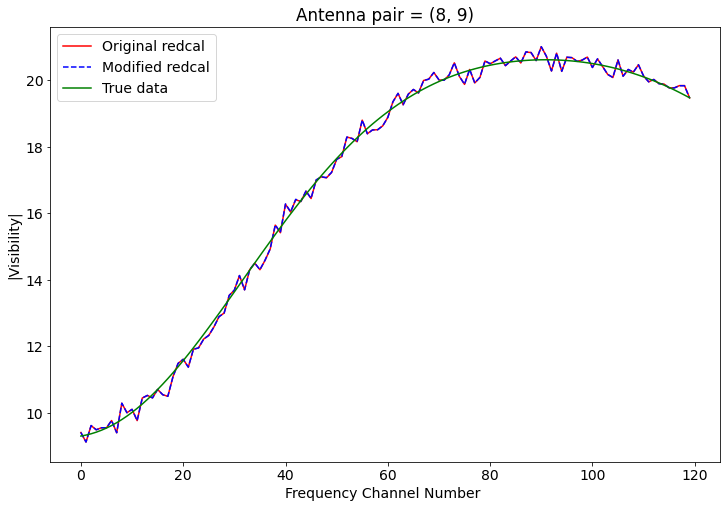

In [404]:
i=7

plt.figure(figsize=(12,8))
plt.plot(np.abs(uvd_cal_red.get_data(rbg[i])[0]), 'r', label = 'Original redcal')
plt.plot(np.abs(uvd_cal_custom.get_data(rbg[i])[0]), 'b--', label = 'Modified redcal')
plt.plot(np.abs(true_data.get_data(rbg[i])[0]), 'g', label = 'True data')
plt.xlabel('Frequency Channel Number ')
plt.ylabel('|Visibility|')
plt.title('Antenna pair = {}'.format(true_data.baseline_to_antnums(rbg[i])))
plt.legend()
#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

In [ ]:
# 

In [ ]:
vis_diff_custom_true = []
vis_diff_original_true = []

for i in range(len(rbg)):
    A = true_data.get_data(rbg[i])[0]
    B = uvd_cal_red.get_data(rbg[i])[0]
    C = uvd_cal_custom.get_data(rbg[i])[0]
    
    vis1 = (A - B)
    vis2 = (A - C)
    
    vis_diff_custom_true.append(vis1)
    vis_diff_original_true.append(vis2)

rbg_ant=[] 
plt.figure(figsize=(12,8))
for i in range(len(rbg)-108):
    plt.plot(np.abs(vis_diff_original_true)[i], 'r',
             label = '{}'.format(true_data.baseline_to_antnums(rbg[i])))
    plt.plot(np.abs(vis_diff_custom_true)[i], 'b',
             label = '{}'.format(true_data.baseline_to_antnums(rbg[i])))
    rbg_ant.append(true_data.baseline_to_antnums(rbg[i]))
plt.xlabel('Frequency Channel Number ')
plt.ylabel('|Visibility|')
plt.title('Visibility diff. (Original redcal, True data)')
plt.legend()
#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

rbg

In [551]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import similaritymeasures
import matplotlib.pyplot as plt

# Generate random experimental data
i = 1

y1 = np.abs(uvd_cal_custom.get_data(rbg[i])[0] )
y2 = np.abs(true_data.get_data(rbg[i])[0] )
x = np.arange(len(y1))

P = np.array([x, y1]).T
Q = np.array([x, y2]).T

dh, ind1, ind2 = directed_hausdorff(P, Q)
df = similaritymeasures.frechet_dist(P, Q)
dtw, d = similaritymeasures.dtw(P, Q)
pcm = similaritymeasures.pcm(P, Q)
area = similaritymeasures.area_between_two_curves(P, Q)
cl = similaritymeasures.curve_length_measure(P, Q)

# all methods will return 0.0 when P and Q are the same
print('{} = '.format( true_data.baseline_to_antnums(rbg[i])), dh, df, dtw, pcm, cl, area)



(1, 2) =  0.5919180212560331 0.5919180212560331 19.838991331145618 1.931207366013889 0.779455549812706 19.740241895105978


# Comparing visibility profiles

In [211]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
import similaritymeasures
import matplotlib.pyplot as plt

In [159]:
# filename = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.uvh5"
# input_data = '../non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01_g.uvh5'

filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"
filename1 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"
filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"
input_data = '../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5'




c_data = HERAData(filename)
c_data.read()

hd = HERAData(filename1)
hd.read()

true_data = HERAData(filename2)
true_data.read()

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


(<hera_cal.datacontainer.DataContainer at 0x7fc1562786d0>,
 <hera_cal.datacontainer.DataContainer at 0x7fc15da90e80>)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


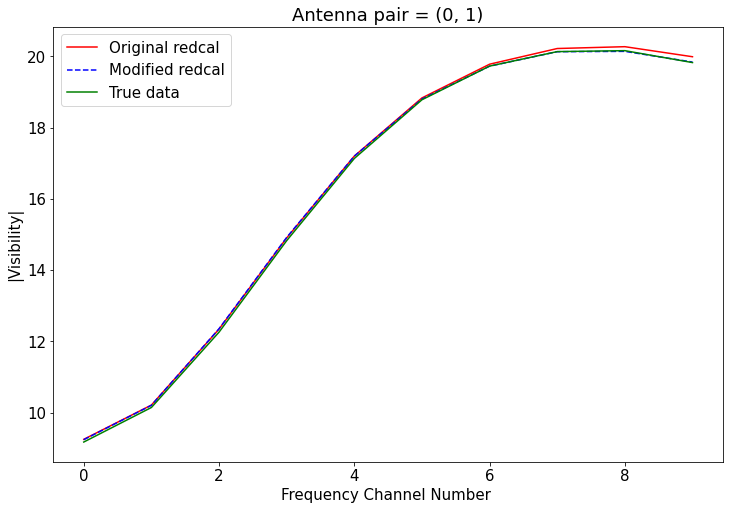

In [370]:
i=0
uvd_cal_red = open_data_files(input_data)[0]
uvd_cal_custom = open_data_files(input_data)[1]

plt.figure(figsize=(12,8))
plt.plot(np.abs(uvd_cal_red.get_data(rbg[i])[0]), 'r', label = 'Original redcal')
plt.plot(np.abs(uvd_cal_custom.get_data(rbg[i])[0]), 'b--', label = 'Modified redcal')
plt.plot(np.abs(true_data.get_data(rbg[i])[0]), 'g', label = 'True data')
plt.xlabel('Frequency Channel Number ')
plt.ylabel('|Visibility|')
plt.title('Antenna pair = {}'.format(true_data.baseline_to_antnums(rbg[i])))
plt.legend()
#plt.savefig('../plots/Testing_logi-cal/Adding_non_red_antpairs/(0,0)/(0,1).jpeg')
#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


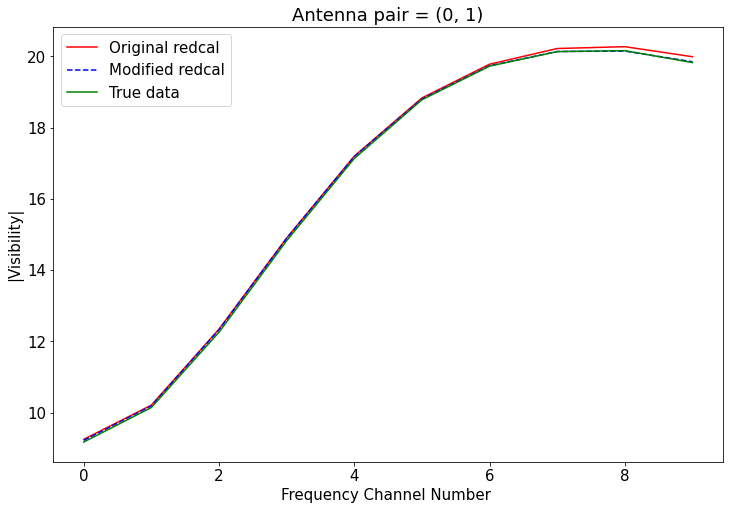

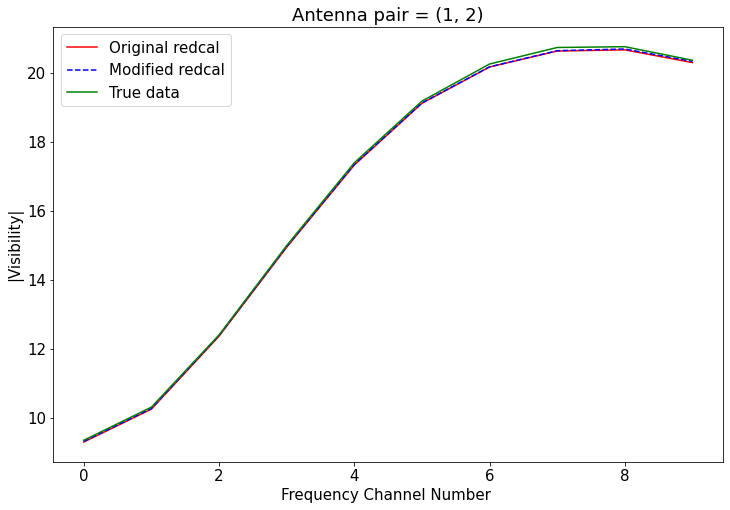

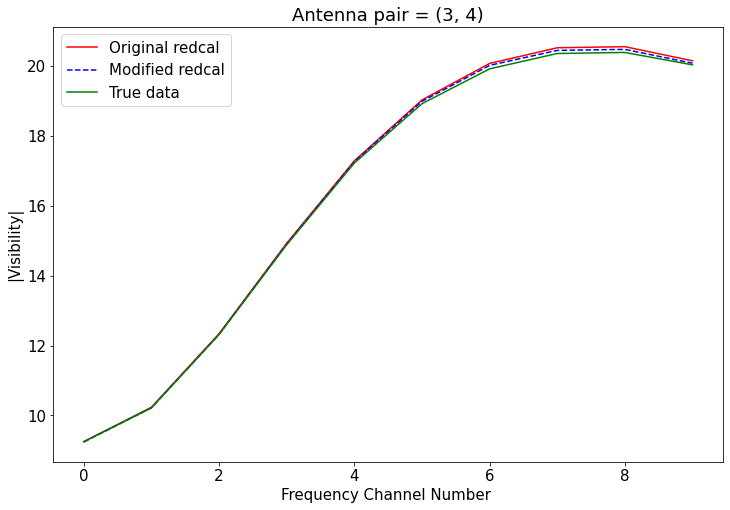

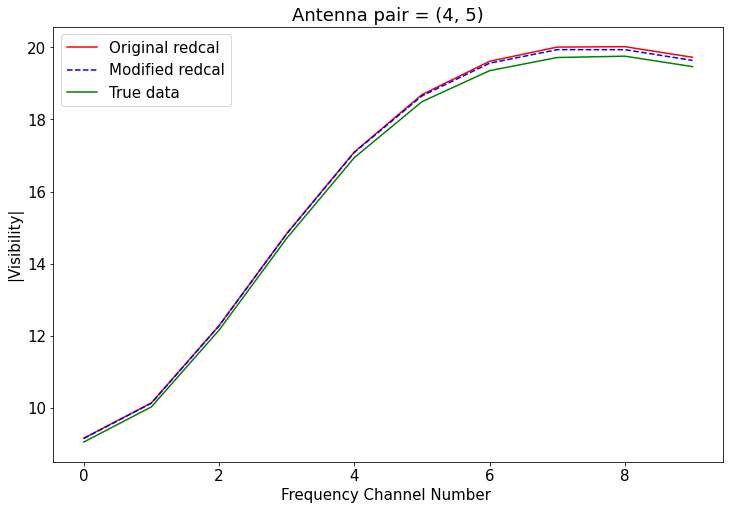

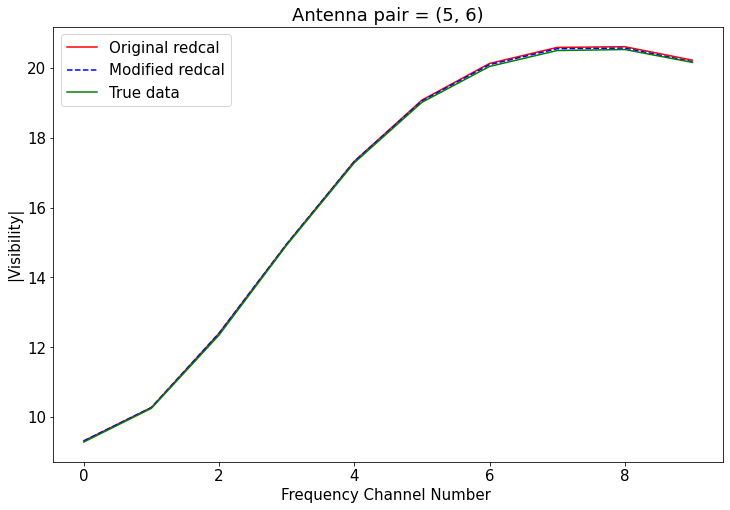

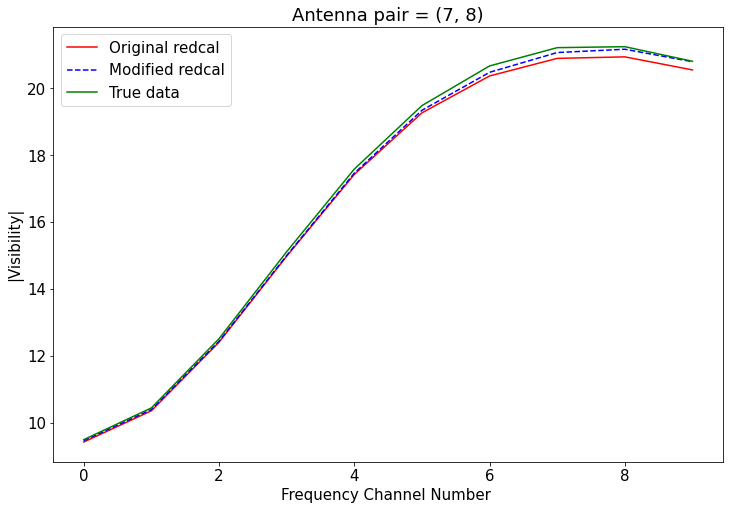

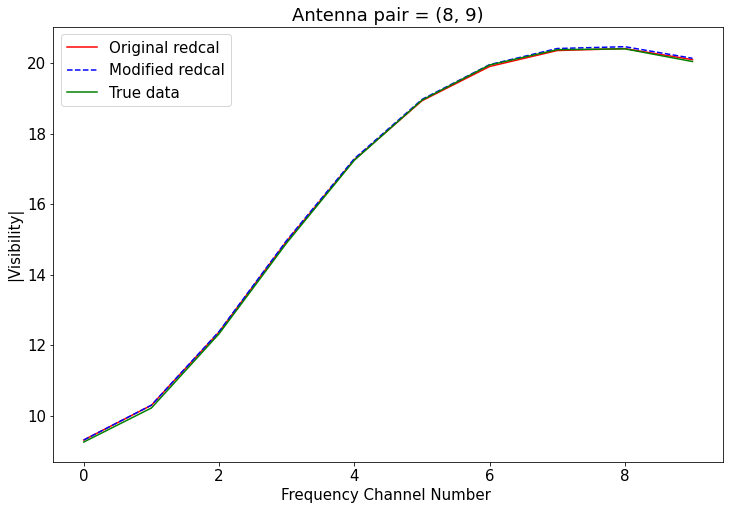

In [417]:
i=0
uvd_cal_red = open_data_files(input_data)[0]
uvd_cal_custom = open_data_files(input_data)[1]

for i in range(len(rbg)):
    plt.figure(figsize=(12,8))
    plt.plot(np.abs(uvd_cal_red.get_data(rbg[i])[0]), 'r', label = 'Original redcal')
    plt.plot(np.abs(uvd_cal_custom.get_data(rbg[i])[0]), 'b--', label = 'Modified redcal')
    plt.plot(np.abs(true_data.get_data(rbg[i])[0]), 'g', label = 'True data')
    plt.xlabel('Frequency Channel Number ')
    plt.ylabel('|Visibility|')
    plt.title('Antenna pair = {}'.format(true_data.baseline_to_antnums(rbg[i])))
    plt.legend()
    plt.savefig('../plots/Testing_logi-cal/Changing_cluster_group_number/4/{}.jpeg'.format(rbg_ant[i]))
#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

If the data is ordered, but don't know which data point is the first and which data point is last:

1. The directed Hausdorff distance

If the data is ordered, and know the first and last points are correct:

2. Discrete Fréchet distance *
3. Dynamic Time Warping (DTW) *
4. Partial Curve Mapping (PCM) **
5. Area between two curves **
6. A Curve-Length distance metric (uses arc length distance from beginning to end) **


* Generally mathematical method used in a variety of machine learning tasks

** Methods I've used to identify unique material hysteresis responses

In [418]:
def get_statistics(true_file, calib_data,rbg_index):
    """
        Use statistical methods to compare similarities in visibility solutions between the what is known (true data), Redcal (the original
        redundant calibration code) and Logi_cal (the modified redcal). 

        Parameters
        ----------
        true_file: HERAData object, data file containing visibility real or true solutions. Must be loaded using uvh5.
            Assumed to have no prior flags..

        calib_file : hera_cal.io.HERAData container already opened using UVcal. For more information on how to open the file refer
            to 'Save_Load_data.py'.

        rbg_index : int
            Specify the redundant baseline group needed to calculate the statistics from.
                max_value = len(red_base[0])
                
        Statistical Methods
        ----------- -------
        dh: The directed Hausdorff distance
        df: Discrete Fréchet distance
        dtw: Dynamic Time Warping (DTW)
        pcm: Partial Curve Mapping (PCM)
        area: Area between two curves 
        cl: A Curve-Length distance metric (uses arc length distance from beginning to end)

        Returns
        -------
        An array of statistical values of each method for each baseline in a redundant baseline group.
            NB.The closer to ZERO these values are, the more similar the two data files are in comparison.
        """
    
    red_base = true_file.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)
    rbg = red_base[0][rbg_index]  
    rbg = np.array(rbg)     ## Saving a list of redundant baselines in an array.
    
    stat_values = []
    #original_stat = []
    for i in range(len(rbg)):
        y1 = np.abs(calib_data.get_data(rbg[i])[0] )
        y2 = np.abs(true_file.get_data(rbg[i])[0] )
        x = np.arange(len(y1))

        P = np.array([x, y1]).T
        Q = np.array([x, y2]).T

        dh, ind1, ind2 = directed_hausdorff(P, Q)
        df = similaritymeasures.frechet_dist(P, Q)
        dtw, d = similaritymeasures.dtw(P, Q)
        pcm = similaritymeasures.pcm(P, Q)
        area = similaritymeasures.area_between_two_curves(P, Q)
        cl = similaritymeasures.curve_length_measure(P, Q)

        # all methods will return 0.0 when P and Q are the same
        stat_values.append([dh, df, dtw, pcm, cl, area])

        #print('{} = '.format( true_data.baseline_to_antnums(rbg[i])), dh, df, dtw, pcm, cl, area)
    stat_values = np.array(stat_values)     
    return stat_values



In [419]:
def open_data_files(calib_file):
    """
        Uses the original calibrated file to open the redcal and logi_cal calibrated files 

        Parameters
        ----------

        calib_file : str
        The location and filename of the calibrated file

        Returns
        -------
        A tuple of the redcal[0] and logi_cal data[1]
        """
    input_data = calib_file

    input_ext = utils.remove_file_ext(input_data)

    uvd_in = UVData()
    uvd_in.read_uvh5(input_data)
    
    uvc_red = UVCal()
    uvc_red.read_calfits(input_ext+'_new_red.calfits')
    uvd_cal_red = uvutils.uvcalibrate(uvd_in, uvc_red, inplace=False, prop_flags=True, 
                                  flag_missing=True)

    ## Loading logi_cal data file
    uvc_custom = UVCal()
    uvc_custom.read_calfits(input_ext+'_new_custom.calfits')
    uvd_cal_custom = uvutils.uvcalibrate(uvd_in, uvc_custom, inplace=False, prop_flags=True, 
                                  flag_missing=True) 
    return uvd_cal_red, uvd_cal_custom


In [420]:


red_base = true_data.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)
rbg = red_base[0][1]  
rbg = np.array(rbg) 

original_stat = get_statistics(true_data,open_data_files(input_data)[0],1)
custom_stat= get_statistics(true_data,open_data_files(input_data)[1],1)

Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


In [421]:
print(original_stat[0])
custom_stat[0]

[0.16395413 0.16395413 0.83881751 0.04500163 0.01758786 0.7191006 ]


array([0.06948789, 0.06948789, 0.35538763, 0.01024533, 0.00739344,
       0.31960784])

In [422]:
rbg_ant = []
for i in rbg:
    rbg_ant.append(true_data.baseline_to_antnums(i))




In [423]:

def plot_one_stat(stat_number, N_baselines):
    stat_number = stat_number-1
    
    kk = N_baselines ## Number of baselines you want to plot
    stat_methods = ['The directed Hausdorff distance', 'Discrete Fréchet distance', 'Dynamic Time Warping (DTW)',
                   'Partial Curve Mapping (PCM)','Area between two curves', 'Curve-Length distance metric']

    colors = ['b','r','g','y','m','orange'] 

    plt.figure(figsize=(22,8))
#     plt.figure(figsize=(16,6.5))
    

    p1, = plt.plot(original_stat[:, stat_number][:kk], "o--" , color=colors[stat_number], label = stat_methods[stat_number], markersize=6)
    p2, = plt.plot(custom_stat[:, stat_number][:kk], "*--" , color=colors[stat_number-2], markersize=10)

    plt.xlabel('Antenna pairs')
    plt.ylabel('Statistical values')
    plt.title('Statistical values for each baseline')

    # Create a legend for the first line.
    first_legend = plt.legend([p2],['Logi_cal'], bbox_to_anchor=(0.145, 0.92), loc='upper right')
#     first_legend = plt.legend([p2],['Logi_cal'], bbox_to_anchor=(0.185, 0.92), loc='upper right')
    second_legend = plt.legend([p1],['Redcal'],bbox_to_anchor=(0.05, 1), loc='upper left')
    # Add the legend manually to the current Axes.
    plt.gca().add_artist(first_legend)
    plt.gca().add_artist(second_legend)

    # Statistical Methods legends
    plt.legend(bbox_to_anchor=(0., 1.1, 1., 1.502),ncol=2, numpoints=1,loc = 'lower center',
    handler_map={tuple: HandlerTuple(ndivide=None)}, title =' Statistical Method', title_fontsize=15)

    positions = np.arange(len(rbg))
    labels = rbg_ant
    plt.xticks(positions[:kk], labels[:kk], rotation = 75)

    #plt.savefig('../plots/stat_methods2.jpeg')
    plt.savefig('../plots/Testing_logi-cal/Changing_cluster_group_number/4/stat_methods2.jpeg')
    plt.show()

    
def plot_all_stat(stat_number,N_baselines):
    
    kk = N_baselines ## Number of baselines you want to plot
    stat_methods = ['The directed Hausdorff distance', 'Discrete Fréchet distance', 'Dynamic Time Warping (DTW)',
                   'Partial Curve Mapping (PCM)','Area between two curves', 'Curve-Length distance metric']

    colors = ['b','r','g','y','m','orange'] 

    plt.figure(figsize=(22,8))
#     plt.figure(figsize=(16,6.5))
    
    for stat_number in range(stat_number):
        p1, = plt.plot(original_stat[:, stat_number][:kk], "o--" , color=colors[stat_number], label = stat_methods[stat_number], markersize=6)
        p2, = plt.plot(custom_stat[:, stat_number][:kk], "*--" , color=colors[stat_number], markersize=10)

    

    # Create a legend for the first line.
    first_legend = plt.legend([p2],['Logi_cal'], bbox_to_anchor=(0.145, 0.92), loc='upper right')
#     first_legend = plt.legend([p2],['Logi_cal'], bbox_to_anchor=(0.185, 0.92), loc='upper right')
    second_legend = plt.legend([p1],['Redcal'],bbox_to_anchor=(0.05, 1), loc='upper left')
    # Add the legend manually to the current Axes.
    plt.gca().add_artist(first_legend)
    plt.gca().add_artist(second_legend)

    # Statistical Methods legends
    plt.legend(bbox_to_anchor=(0., 1.1, 1., 1.502),ncol=2, numpoints=1,loc = 'lower center',
    handler_map={tuple: HandlerTuple(ndivide=None)}, title =' Statistical Method', title_fontsize=15)
    
    plt.xlabel('Antenna pairs')
    plt.ylabel('Statistical values')
    plt.title('Statistical values for each baseline')
    positions = np.arange(len(rbg))
    labels = rbg_ant
    plt.xticks(positions[:kk], labels[:kk], rotation = 75)

    plt.savefig('../plots/Testing_logi-cal/Changing_cluster_group_number/4/all_stat.jpeg')
    plt.show()

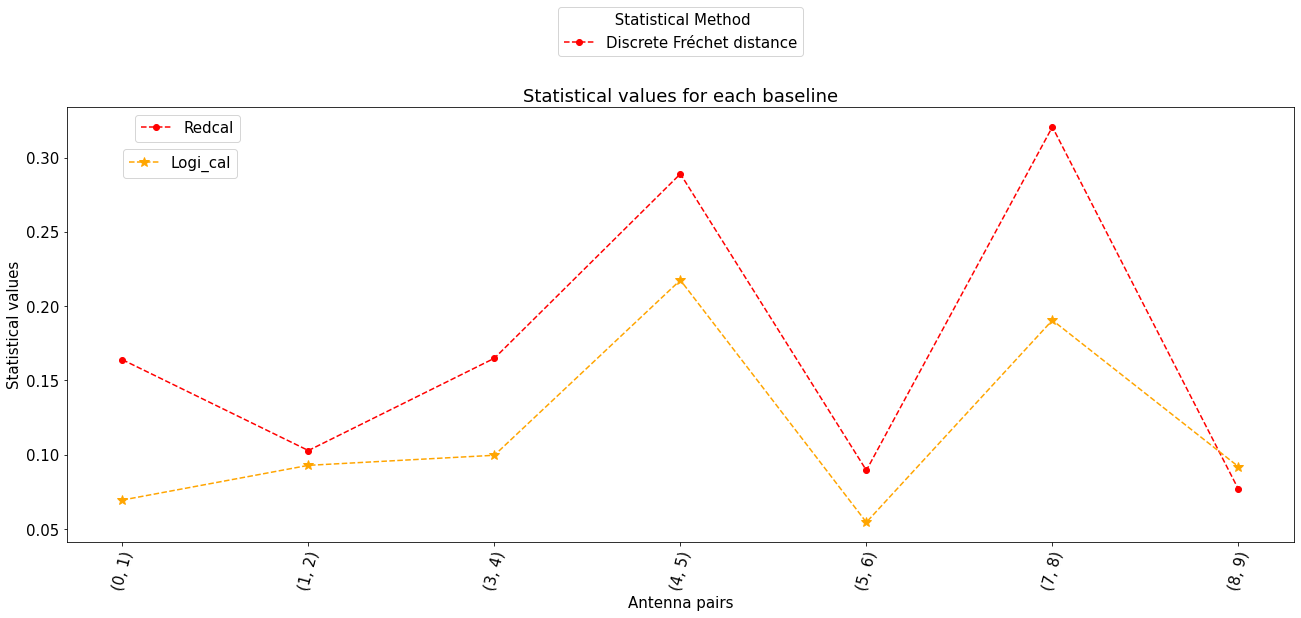

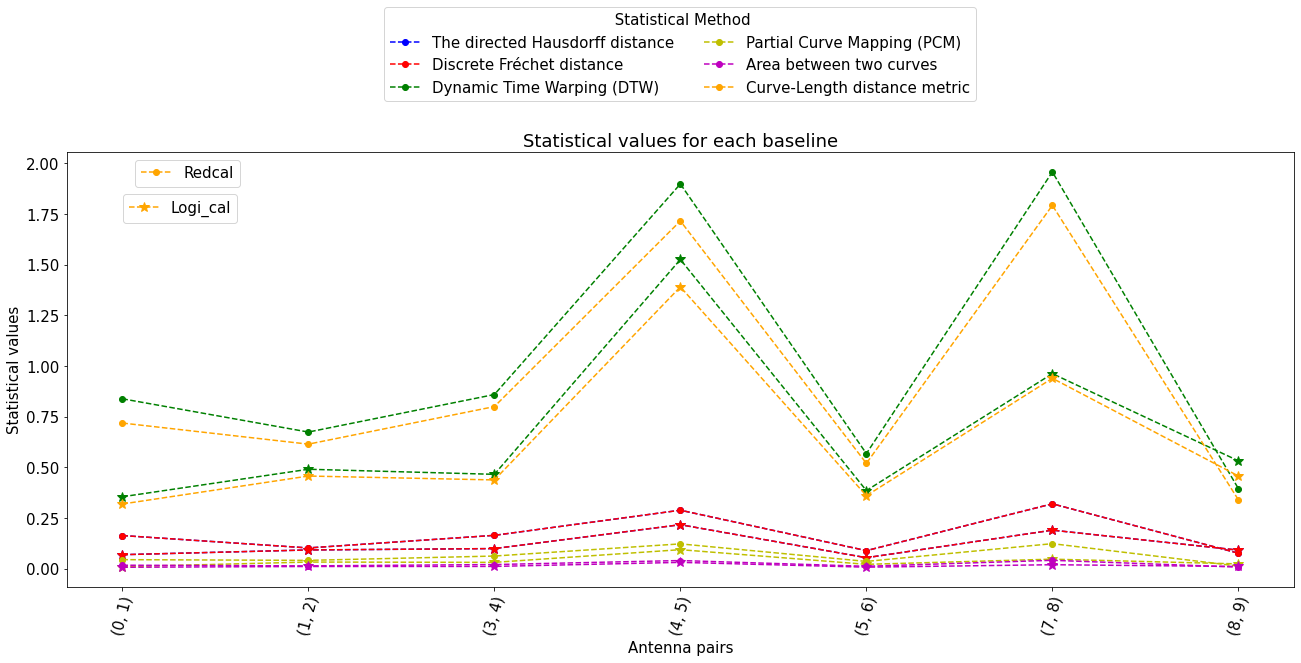

In [424]:
plot_one_stat(2,20)
plot_all_stat(6,20)

In [302]:

i = 1

print(true_data.baseline_to_antnums(rbg[i]))

print("red=",original_stat[i])
print("")
print('cust=', custom_stat[i])


#original_stat[:, 1]

(1, 2)
red= [0.09285069 0.09285069 0.49106333 0.03314281 0.01121839 0.45764513]

cust= [0.1028246  0.1028246  0.67464884 0.0414588  0.01427133 0.61494973]


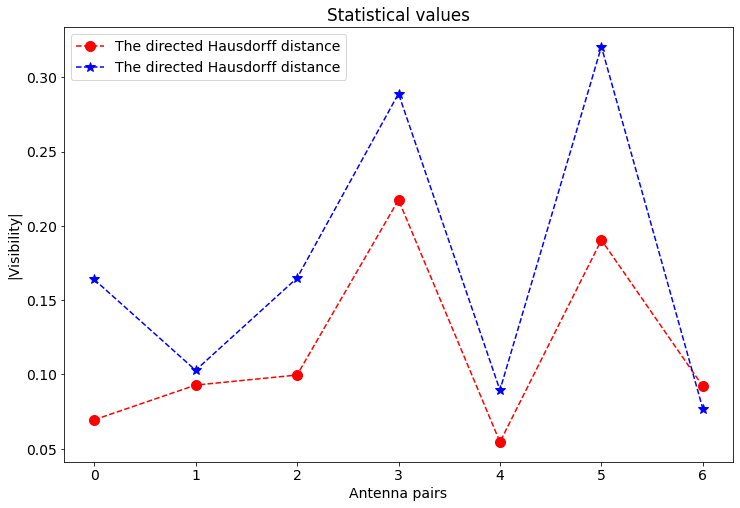

In [303]:
stat_methods = ['The directed Hausdorff distance', 'Discrete Fréchet distance', 'Dynamic Time Warping (DTW)',
               'Partial Curve Mapping (PCM)', 'Curve-Length distance metric','Area between two curves']

color = ['r','b','g','y','o','k'] 

i=0
plt.figure(figsize=(12,8))
plt.plot(original_stat[:, i], "ro--", markersize=10, label = stat_methods[i])
plt.plot(custom_stat[:, i], 'b*--', markersize=10, label = stat_methods[i])

# plt.plot(original_stat[:, 2], "*b--", markersize=10, label = stat_methods[1])
# plt.plot(custom_stat[:, 2], 'bo--', markersize=10, label = stat_methods[1])

plt.xlabel('Antenna pairs')
plt.ylabel('|Visibility|')
plt.title('Statistical values')
plt.legend()
#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

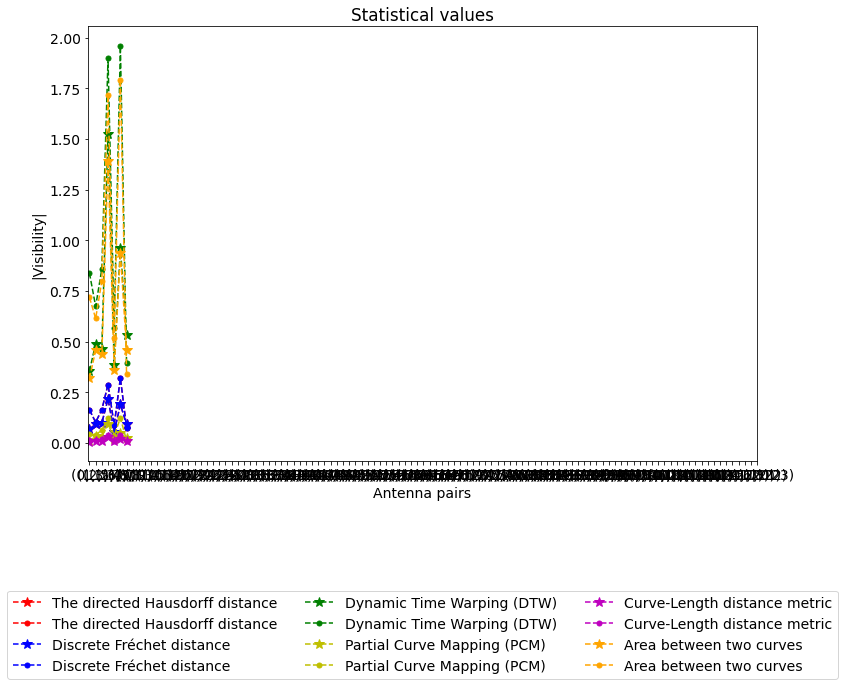

In [304]:
stat_methods = ['The directed Hausdorff distance', 'Discrete Fréchet distance', 'Dynamic Time Warping (DTW)',
               'Partial Curve Mapping (PCM)', 'Curve-Length distance metric','Area between two curves']

colors = ['r','b','g','y','m','orange'] 

plt.figure(figsize=(12,8))

for i in range(6):
    
    plt.plot(original_stat[:, i], "*--" , color=colors[i], markersize=10, label = stat_methods[i])
    plt.plot(custom_stat[:, i], ".--" , color=colors[i], markersize=10, label = stat_methods[i])

plt.xlabel('Antenna pairs')
plt.ylabel('|Visibility|')
plt.title('Statistical values')

positions = np.arange(len(rbg))
labels = rbg_ant
plt.xticks(positions, labels)
plt.legend(bbox_to_anchor=(0., -0.5, 1., -.502),loc = 'lower center',ncol=3, borderaxespad=0.)

#plt.savefig('../plots/calib_data_cluster.jpeg')
plt.show()

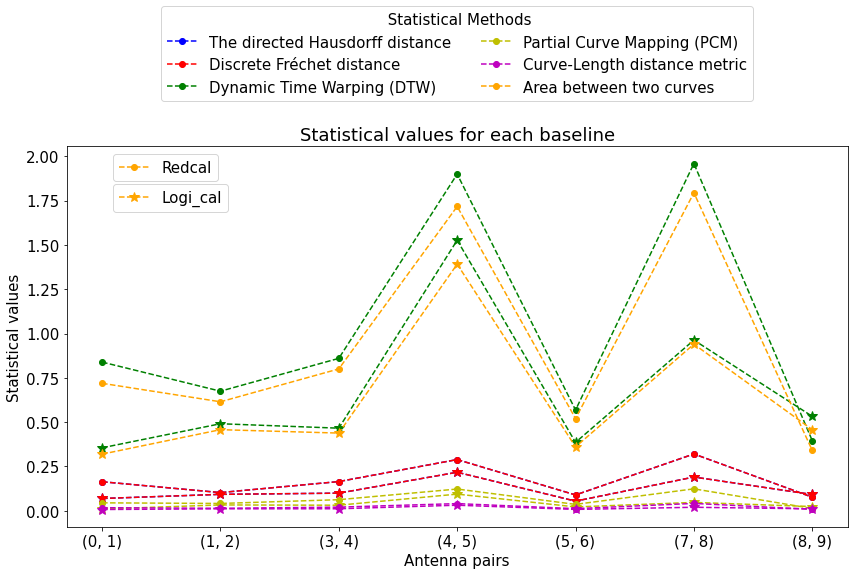

In [538]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
stat_methods = ['The directed Hausdorff distance', 'Discrete Fréchet distance', 'Dynamic Time Warping (DTW)',
               'Partial Curve Mapping (PCM)', 'Curve-Length distance metric','Area between two curves']

colors = ['b','r','g','y','m','orange'] 

plt.figure(figsize=(14,7))

for i in range(len(stat_methods)):
    
    p1, = plt.plot(original_stat[:, i], "o--" , color=colors[i], label = stat_methods[i], markersize=6)
    p2, = plt.plot(custom_stat[:, i], "*--" , color=colors[i], markersize=10)

plt.xlabel('Antenna pairs')
plt.ylabel('Statistical values')
plt.title('Statistical values for each baseline')

# Create a legend for the first line.
first_legend = plt.legend([p2],['Logi_cal'], bbox_to_anchor=(0.216, 0.92), loc='upper right')
second_legend = plt.legend([p1],['Redcal'],bbox_to_anchor=(0.05, 1), loc='upper left')
# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)
plt.gca().add_artist(second_legend)

# Statistical Methods legends
plt.legend(bbox_to_anchor=(0., 1.1, 1., 1.502),ncol=2, numpoints=1,loc = 'lower center',
handler_map={tuple: HandlerTuple(ndivide=None)}, title =' Statistical Methods', title_fontsize=15)

positions = np.arange(len(rbg))
labels = rbg_ant
plt.xticks(positions, labels)


#plt.savefig('../plots/stat_methods2.jpeg')
plt.show()


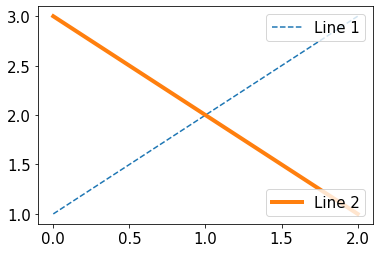

In [462]:
line1, = plt.plot([1, 2, 3], label="Line 1", linestyle='--')
line2, = plt.plot([3, 2, 1], label="Line 2", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1], loc='upper right')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[line2], loc='lower right')

plt.show()


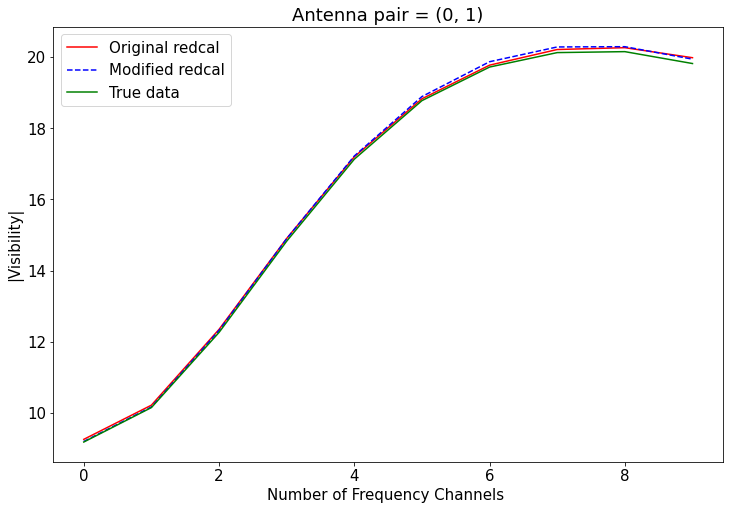

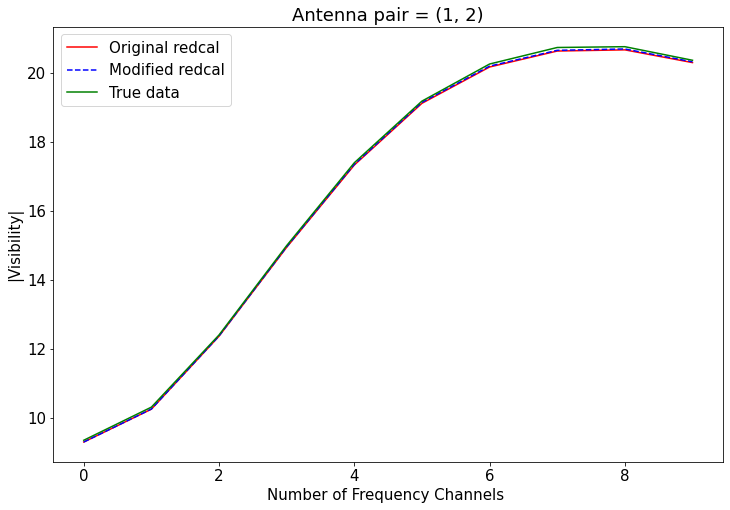

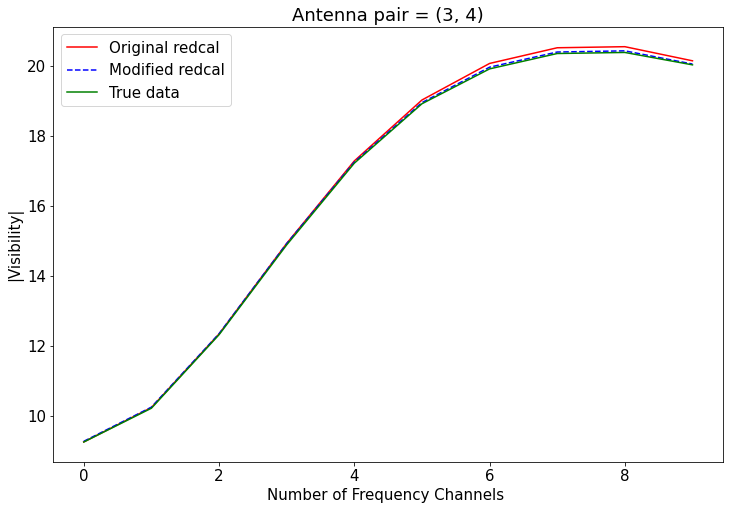

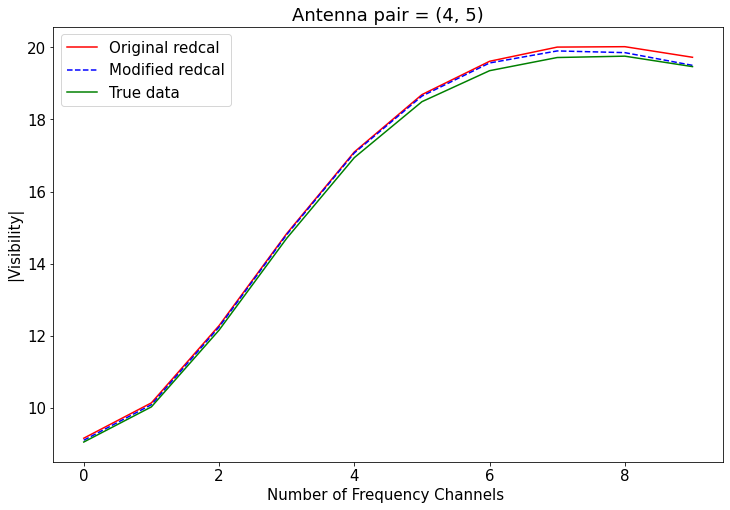

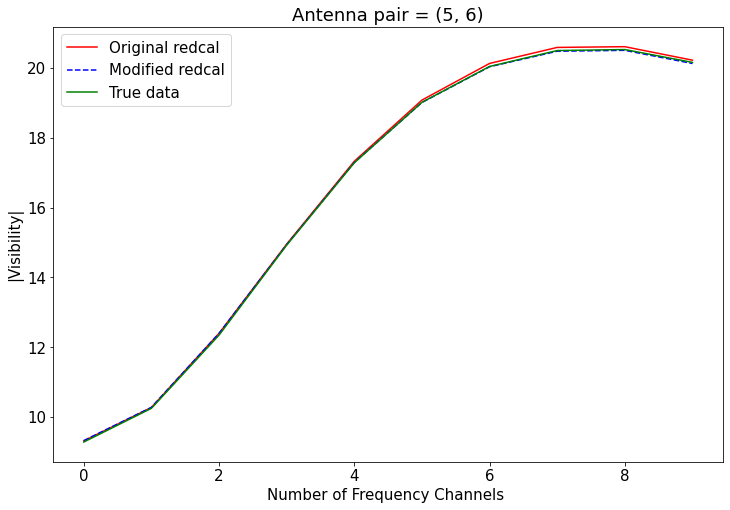

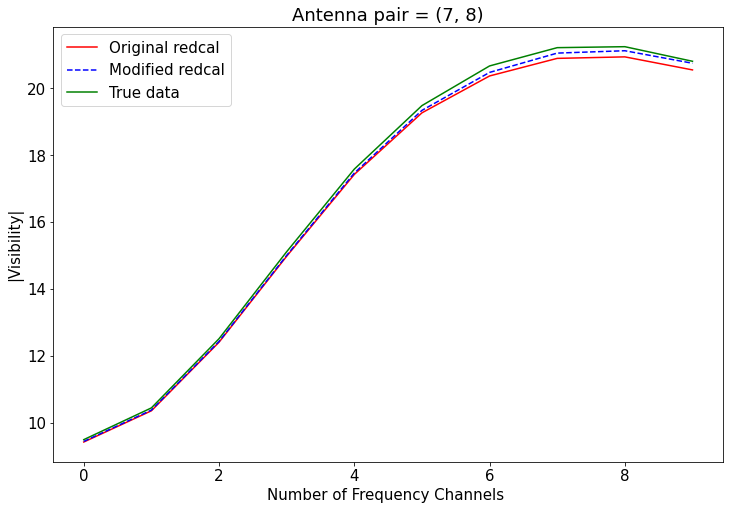

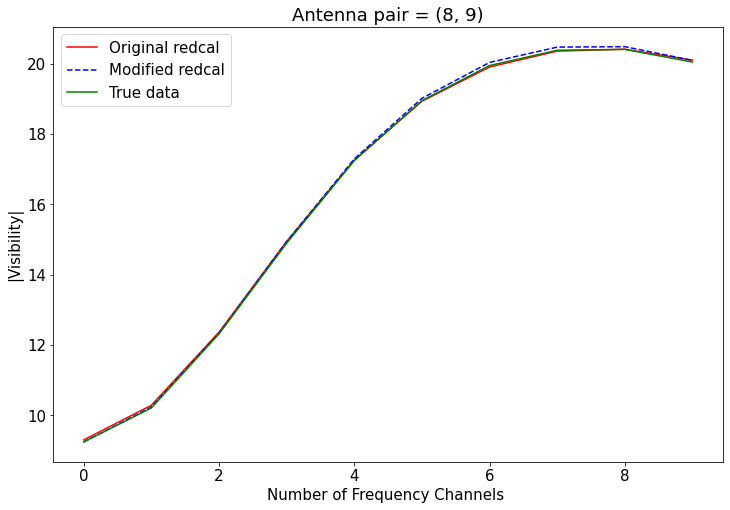

In [88]:
original_statge(len(rbg)):
    plt.figure(figsize=(12,8))
    plt.plot(np.abs(uvd_cal_red.get_data(rbg[i])[0]), 'r', label = 'Original redcal')
    plt.plot(np.abs(uvd_cal_custom.get_data(rbg[i])[0]), 'b--', label = 'Modified redcal')
    plt.plot(np.abs(true_data.get_data(rbg[i])[0]), 'g', label = 'True data')
    plt.xlabel('Number of Frequency Channels ')
    plt.ylabel('|Visibility|')
    plt.title('Antenna pair = {}'.format(true_data.baseline_to_antnums(rbg[i])))
    plt.legend()
    plt.savefig('../plots/true_data_{}.jpeg'.format(rbg[i]))
plt.show()


(7, 10, 10)
(7, 10, 10)
(7, 10, 10)


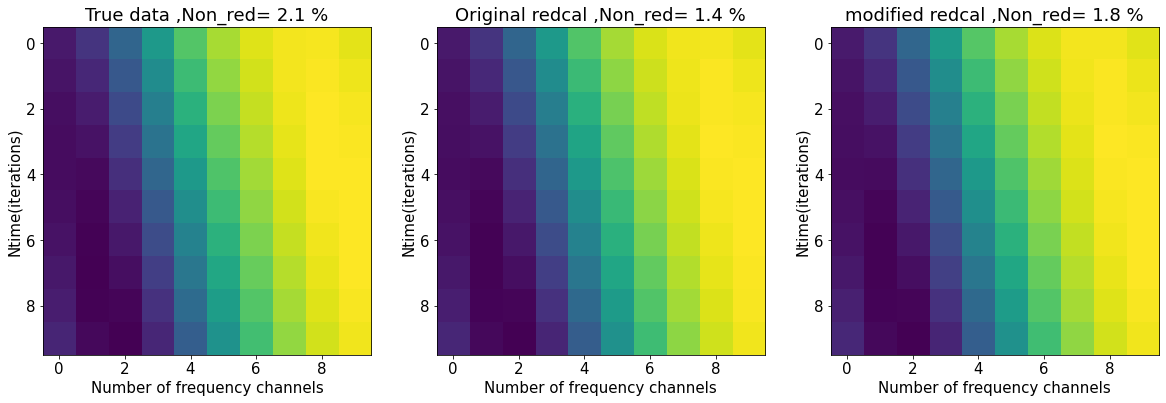

In [187]:
file_list = [true_data,uvd_cal_red, uvd_cal_custom]
Titles = ['True data','Original redcal', 'modified redcal']

plt.figure(figsize=(20,17)) # specifying the overall grid size
for i in range(len(file_list)):
    data_f = file_list[i]
    ## Getting one redundant baseline group
    red_base = data_f.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                                   conjugate_bls=False)

    n = red_base[0][1]  
    n = np.array(n)     ## Saving a list of redundant baselines in an array.
    
    ##  Combining a list of 2D arrays into a 3D array
    array_3D = []

    for j in range(len(n)):
        array_3D.append(data_f.get_data(n[j]) )

    array_3D = np.array(array_3D)
    print(array_3D.shape)

    ##  Calculating and ploting the Mean visibility
    vis_mean = array_3D.mean(axis=0)
    
    ##  Calculating and ploting the Standard Deviation visibility
    vis_std = array_3D.std(axis=0)

    ###### Typical percentage level of non-redundancy for this group
    ##Non_red%  = std/mean =  (size of fluctuations) / (size of signal) *100
    a = (vis_std.max() +vis_std.min() )/2
    b = abs((vis_mean.max() +vis_mean.min() )/2)
    
    plt.subplot(1,3,i+1)    
    plt.imshow(np.abs(data_f.get_data(n[0])))
    plt.title('{} ,Non_red= {} %'.format(Titles[i], np.round(a/b*100, 2)))
    plt.xlabel('Number of frequency channels')
    plt.ylabel('Ntime(iterations)')

In [163]:
custom_red_gains_fixed
diff_custom_true = []
diff_red_true = []
diff_custom_red = []

for i in range(len(custom_red_gains_fixed)):
    a = abs(true_gains[( int('{}'.format(i)) , 'Jee' )][0] )  ## true gains
    b1 = abs(custom_red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] )  ## Modified Redcal code
    b2 = abs(red_gains_fixed[( int('{}'.format(i)) , 'Jee' )][0] )  ## original Redcal code
    
    diff_custom_true.append(a-b1)   ### Difference between gains from Modified Redcal code and True gains
    diff_red_true.append(a-b2)      ### Difference between gains from original Redcal code and True gains
    diff_custom_red.append(b2-b1)    ### Difference between gains from original Redcal code and Modified Redcal code



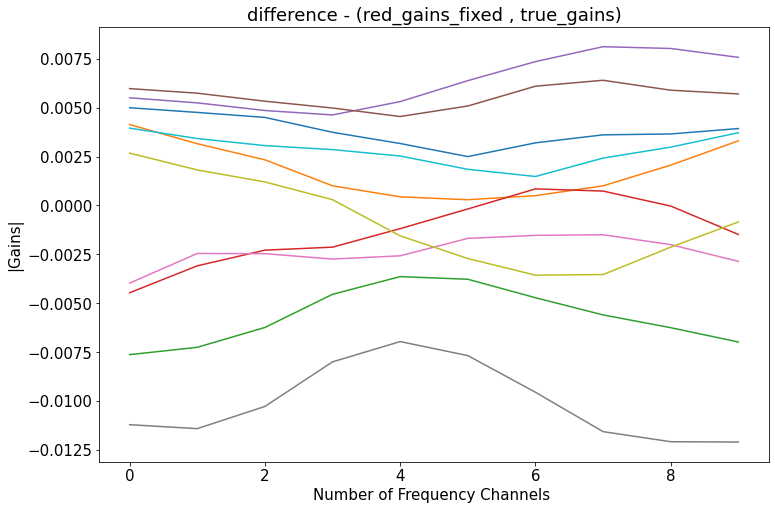

In [164]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot((diff_red_true[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
#plt.title('custom_red_gains_fixed vs red_gains_fixed')
plt.title('difference - (red_gains_fixed , true_gains)')
plt.show()






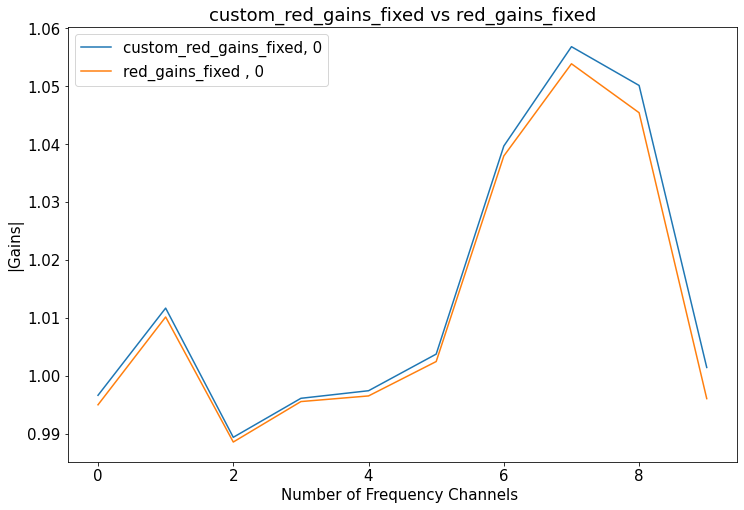

In [165]:
plt.figure(figsize=(12,8))
plt.plot(abs(custom_red_gains_fixed[(0,'Jee')][0]), label = 'custom_red_gains_fixed, 0')
plt.plot(abs(red_gains_fixed[(0,'Jee')][0]), label = 'red_gains_fixed , 0' )
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('custom_red_gains_fixed vs red_gains_fixed')
plt.legend()
plt.show()

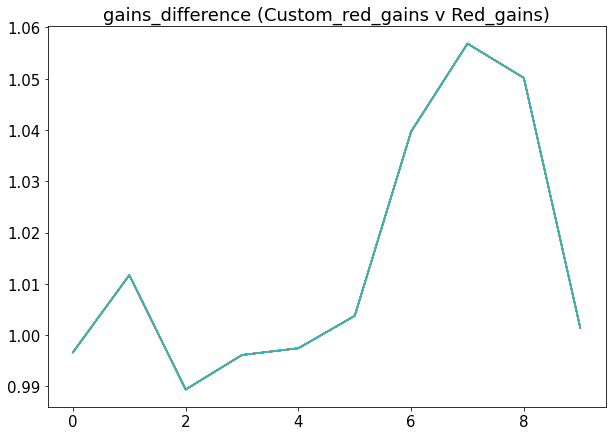

In [166]:
plt.figure(figsize=(10,7))
for i in range(len(true_gains)):
    plt.plot(abs(custom_red_gains_fixed[(0,'Jee')][0]))
    #plt.title('gains_difference (Custom_red_gains v True gains)')
    plt.title('gains_difference (Custom_red_gains v Red_gains)')
    #plt.title('gains_difference (Red_gains v True gains)')

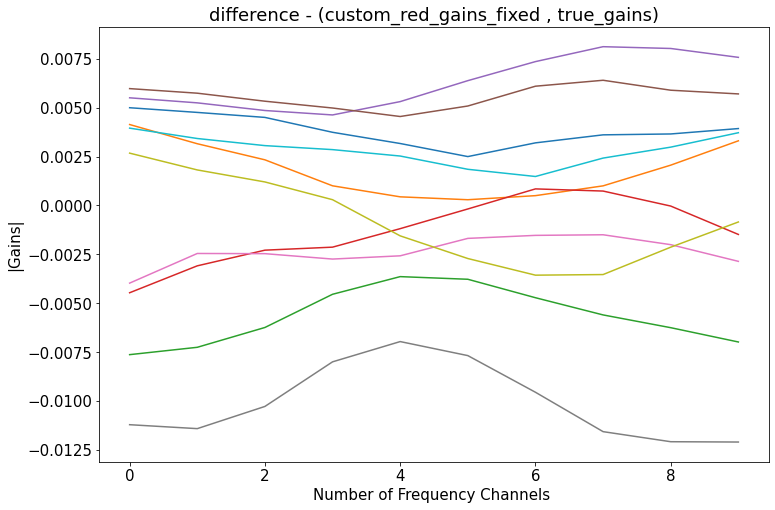

In [167]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot((diff_red_true[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
#plt.title('difference - (custom_red_gains_fixed , red_gains_fixed)')
plt.title('difference - (custom_red_gains_fixed , true_gains)')
plt.show()

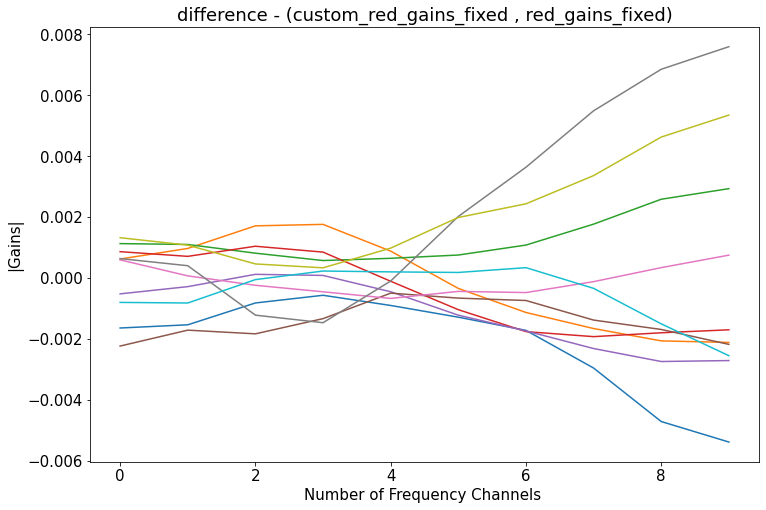

0.0036841836026614283

In [168]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains)):
    plt.plot((diff_custom_red[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('difference - (custom_red_gains_fixed , red_gains_fixed)')
#plt.title('difference - (custom_red_gains_fixed , true_gains)')
plt.show()

abs(diff_custom_true[0]).max()

In [89]:
a = 6
print('reds = ', abs(diff_red_true[a]).max())
print('custom = ',abs(diff_custom_true[a]).max())
for i in range(len(diff_custom_true)):
    a = abs(diff_red_true[i]).max()
    b = abs(diff_custom_true[i]).max()
    if a>b:
        print(a,b)

reds =  0.0021174749075147936
custom =  0.002282043331739647
0.005736894890930211 0.005703898239818539
0.0012938730851694835 0.0012162661696355492
0.009518879209740483 0.0095098162867302
0.0029971920012158426 0.002886804199091819
0.001738639140958953 0.0016083717346192516
0.004415992169936045 0.0043683908331760835
0.005571478453782586 0.005272859183457879
0.009151618052979593 0.00889794068481553
0.005436778845144152 0.00519681054527843
0.0006858229681896422 0.0006601536517980566
0.001265970140397421 0.0008183392581342375
0.008101717774638306 0.007867113892802369
0.005357870474054671 0.005339631452753402
0.002694910121389449 0.002567236972280562
0.007489459468635218 0.00729145283869137
0.0038216672056108347 0.0034306598846933767
0.003915441509051432 0.0038322983531389188
0.002578878304715815 0.0023426346304646906
0.00349163445432632 0.003436559762553859
0.004403336298597349 0.004108077367475982
0.0051124601415308835 0.00479335632863509
0.0038003299396009993 0.0037303740082015313
0.00271

In [580]:
import utils

true_gains, _= hc.io.load_cal('non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.calfits')
len(true_gains)

type(true_gains)

## Changing dictionary keys from (0, 'Jee') to '0'
for i in range(len(true_gains)):
    new_key = '{}'.format(i)
    old_key = (int('{}'.format(i)) , 'Jee')

    true_gains[new_key] = true_gains.pop(old_key) ## Changing the key names
    true_gains[new_key] = true_gains[new_key][0]  ## Changing the dimension for each antenna from 2D to 1D



print(len(true_gains['0']))

true_gains.keys()

120


odict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123'])

In [581]:
import utils

true_gains, _= hc.io.load_cal('non-redundant-pipeline/File2/calibration_3a_0.01/viscatBC_stretch0.01.calfits')
len(true_gains)

type(true_gains)

collections.OrderedDict

## Perfectly Redundant case

In [21]:
from hera_cal import utils
f_name = 'non-redundant-pipeline/calibration/viscatBC_g.uvh5'

dfile = HERAData(f_name)
dfile.read()


Telescope hera_sim is not in known_telescopes.


(<hera_cal.datacontainer.DataContainer at 0x7f31cec93910>,
 <hera_cal.datacontainer.DataContainer at 0x7f31da514100>)

In [22]:

from hera_cal import utils

red_gains2 = redcal_iteration(dfile)
custom_red_gains2 = redcal_iteration_custom(dfile)

In [23]:
import utils

true_gains2, _= hc.io.load_cal('non-redundant-pipeline/calibration/viscatBC.calfits')
len(true_gains2)

type(true_gains2)

collections.OrderedDict

In [24]:
red_gains_fixed2 = fix_redcal_degeneracies(f_name, red_gains2['g_omnical'],true_gains2)
custom_red_gains_fixed2 = fix_redcal_degeneracies(f_name, custom_red_gains2['g_omnical'], true_gains2)

Telescope hera_sim is not in known_telescopes.


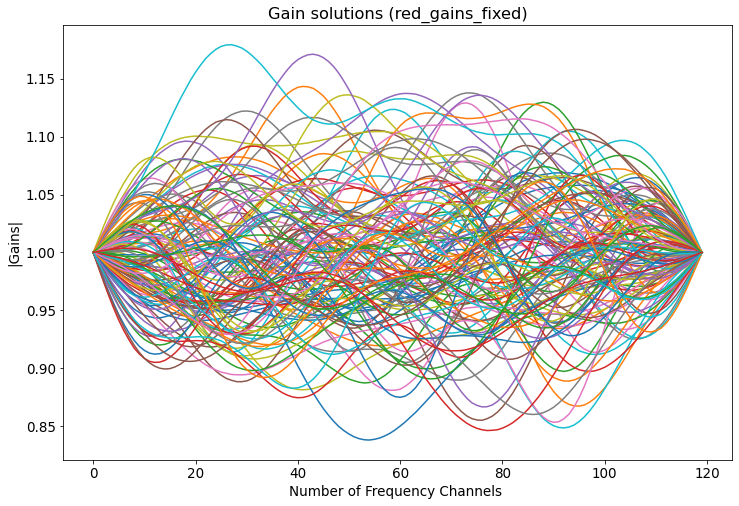

In [25]:

plt.figure(figsize=(12,8))
for i in range(len(red_gains_fixed2)):
    plt.plot(abs(red_gains_fixed2[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (red_gains_fixed)')
#plt.legend()
plt.show()

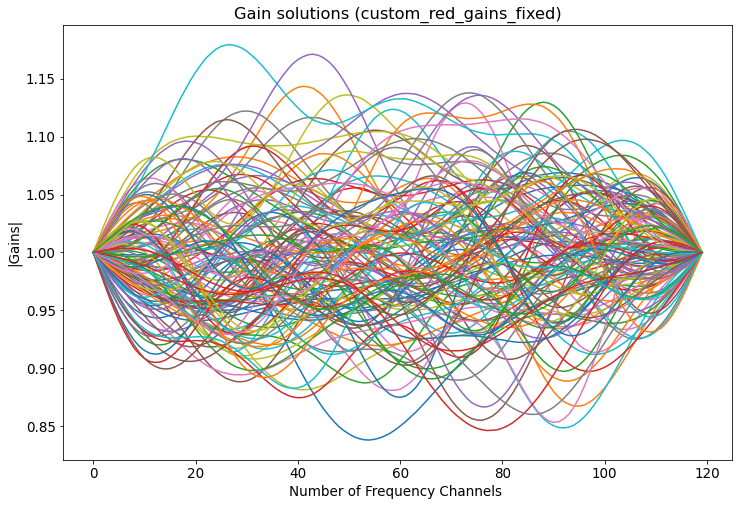

In [26]:
plt.figure(figsize=(12,8))
for i in range(len(custom_red_gains_fixed2)):
    plt.plot(abs(custom_red_gains_fixed2[( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (custom_red_gains_fixed)')
#plt.legend()
plt.show()

In [27]:

diff_custom_true2 = []
diff_red_true2 = []
diff_custom_red2 = []

for i in range(len(custom_red_gains_fixed2)):
    a = abs(true_gains2[( int('{}'.format(i)) , 'Jee' )][0] )  ## true gains
    b1 = abs(custom_red_gains_fixed2[( int('{}'.format(i)) , 'Jee' )][0] )  ## Modified Redcal code
    b2 = abs(red_gains_fixed2[( int('{}'.format(i)) , 'Jee' )][0] )  ## original Redcal code
    
    diff_custom_true2.append(a-b1)   ### Difference between gains from Modified Redcal code and True gains
    diff_red_true2.append(a-b2)      ### Difference between gains from original Redcal code and True gains
    diff_custom_red2.append(b2-b1)    ### Difference between gains from original Redcal code and Modified Redcal code



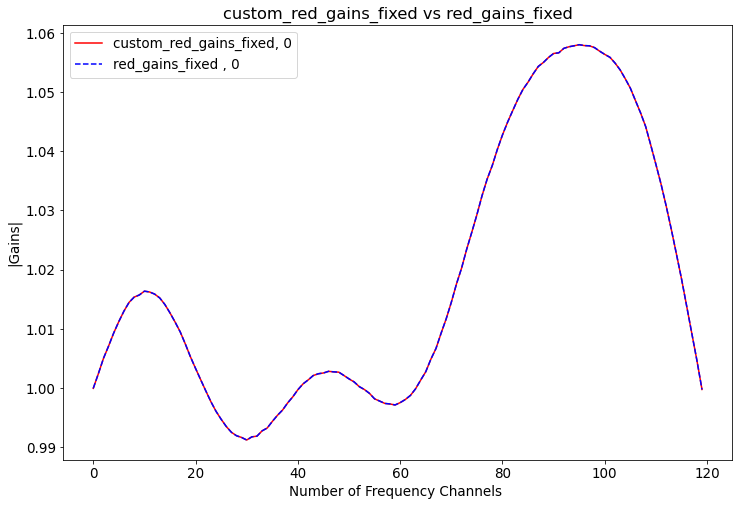

In [28]:
plt.figure(figsize=(12,8))
plt.plot(abs(custom_red_gains_fixed2[(0,'Jee')][0]),'r', label = 'custom_red_gains_fixed, 0')
plt.plot(abs(red_gains_fixed2[(0,'Jee')][0]), 'b--', label = 'red_gains_fixed , 0' )
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('custom_red_gains_fixed vs red_gains_fixed')
plt.legend()
plt.show()

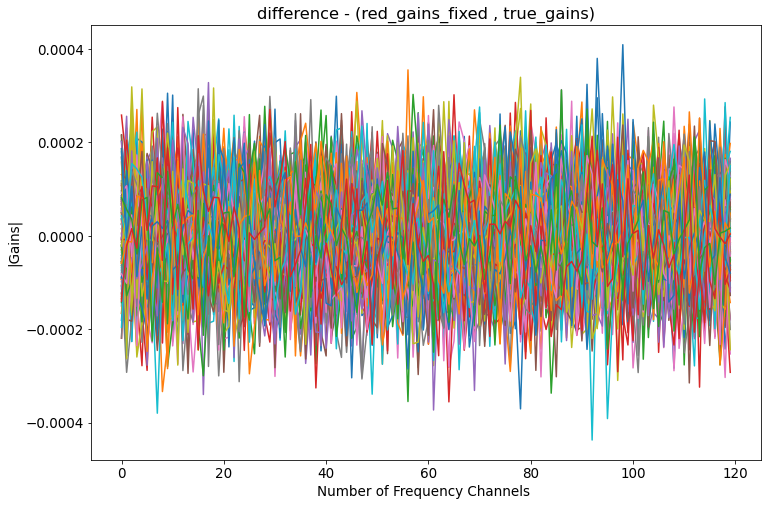

In [29]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains2)):
    plt.plot((diff_red_true2[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
#plt.title('custom_red_gains_fixed vs red_gains_fixed')
plt.title('difference - (red_gains_fixed , true_gains)')
plt.show()

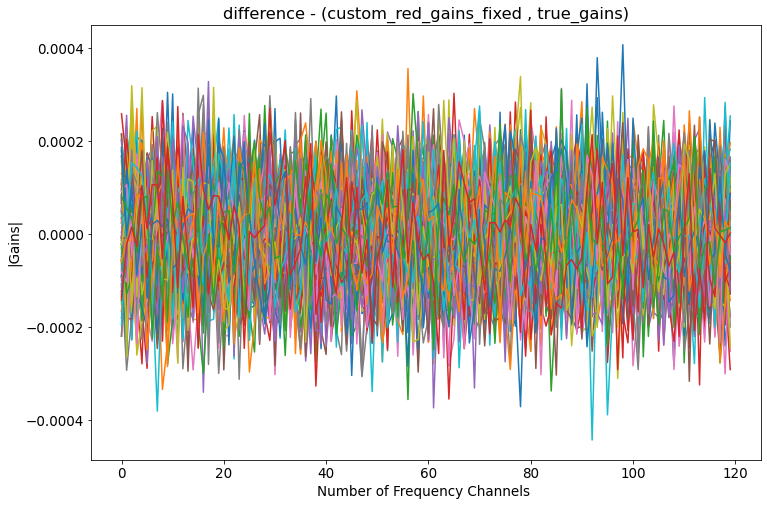

In [30]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains2)):
    plt.plot((diff_custom_true2[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
#plt.title('difference - (custom_red_gains_fixed , red_gains_fixed)')
plt.title('difference - (custom_red_gains_fixed , true_gains)')
plt.show()

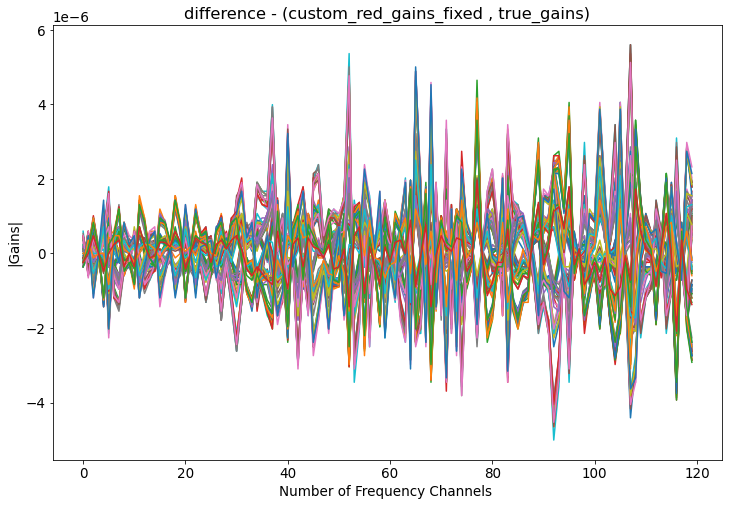

In [31]:
plt.figure(figsize=(12,8))
for i in range(len(true_gains2)):
    plt.plot((diff_custom_red2[i]))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
#plt.title('difference - (custom_red_gains_fixed , red_gains_fixed)')
plt.title('difference - (custom_red_gains_fixed , true_gains)')
plt.show()

In [36]:
reds_all

rd =[]
clust =  get_custom_reds(hd,3)
for i in range(len(reds_all)):
    if i==2:
        for j in range(len(clust)):
            rd.append(clust[j])
    else:
        rd.append(reds_all[i])
len(rd)

230

In [37]:
red_base = hd.get_redundancies(tol=1.0, use_antpos=False, include_conjugates=False,include_autos=True,
                               conjugate_bls=False)

n = red_base[0][1]  
n = np.array(n)     ## Saving a list of redundant baselines in an array.

In [72]:
## reds_all[228][112][3]
reds_all[227][0][0]

## Changing the antenna numbers in to baselines for every redundant baseline group.
redundant_baseline_group = []
for bg in range(len(reds_all)):
    redundant_baselines = []
    for a_num in range(len(reds_all[bg])):
        bID = hd.antnums_to_baseline(reds_all[bg][a_num][0],reds_all[bg][a_num][1])
        redundant_baselines.append(bID)
    redundant_baseline_group.append(redundant_baselines) ## Saving a list of redundant baselines in an array.



In [12]:
def get_reds(antpos, pols=['nn'], pol_mode='1pol', bl_error_tol=1.0, include_autos=False):
    pos_reds = get_pos_reds(antpos, bl_error_tol=bl_error_tol, include_autos=include_autos)
    return add_pol_reds(pos_reds, pols=pols, pol_mode=pol_mode)

def all_reds_function(data_file):
    ant_nums = np.unique(np.append(data_file.ant_1_array, data_file.ant_2_array))
    pols=['nn']
    pol_mode='2pol'
    bl_error_tol=1.0

    #def _get_pol_load_list(pols, pol_mode='1pol'):
    '''Get a list of lists of polarizations to load simultaneously, depending on the polarizations
    in the data and the pol_mode (which can be 1pol, 2pol, 4pol, or 4pol_minV)'''

    if pol_mode in ['1pol', '2pol']:
        pol_load_list = [[pol] for pol in pols if split_pol(pol)[0] == split_pol(pol)[1]]
    elif pol_mode in ['4pol', '4pol_minV']:
        assert len(pols) == 4, 'For 4pol calibration, there must be four polarizations in the data file.'
        pol_load_list = [pols]
    else:
        raise ValueError('Unrecognized pol_mode: {}'.format(pol_mode))

    reds_all = get_reds({ant: c_data.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                            pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))
    return reds_all

#reds_all2 = all_reds_function(c_data)


In [13]:
def cluster_baselines2(data_file, Number_of_clusters, red_groups_index):
    """ Using a clustering algorithm (K_means In this case) to classify baselines from a
        redundant_baseline_group into groups based on their visibilities.
    Returns:
        n : A list of baseline IDs for the baselnes in the redundant baseline group
        true_labels: A list of lables from the clustering algorithm where baselines of similar
                    visibilities are clustered into the same group. P.S. the number of groups we get
                    depend on the number of clusters specified.
    """
    Number_of_clusters = Number_of_clusters
    reds_all = all_reds_function(data_file)
    
    ## Changing the antenna numbers in to baselines for every redundant baseline group.
    redundant_baseline_group = []
    for bg in range(len(reds_all)):
        redundant_baselines = []
        for a_num in range(len(reds_all[bg])):
            bID = data_file.antnums_to_baseline(reds_all[bg][a_num][0],reds_all[bg][a_num][1])
            redundant_baselines.append(bID)
        redundant_baseline_group.append(redundant_baselines) ## Saving a list of redundant baselines in an array.
    
    
    n = redundant_baseline_group[red_groups_index]   ## Getting one redundant baseline group
    
    
    ##  Combining a list (of visibilities) of 2D arrays into a 3D array
    array_3D = []
    for i in range(len(n)):
        array_3D.append(data_file.get_data(n[i]) )

    array_3D = np.array(array_3D)
    
    ## Appending multiple time sample into one array_per_baseline.
    ## e.g. for a nfreq = 120,ntimes=1 we have 1 X 120=120 elements per_baseline
    ###     for a nfreq = 120,ntimes=60 we have 60 X 120=7200 elements per_baseline
    new_time = []
    for i in range(len(n)):
        abc = abs(array_3D[i])
        d1 = []
        for j in range(len(abc)):
            d1.append(abc[j])
            d2 = np.concatenate(d1)  ### appending all time samples for each baseline
        new_time.append(d2)

    new_time = np.array(new_time)


    X = new_time
    y = n
    # Incorrect number of clusters
    true_labels = KMeans(n_clusters=Number_of_clusters).fit_predict(X)
    return n, true_labels



def get_baseline_cluster2(data_file, Number_of_clusters,red_groups_index):
    """ It uses the labels we get when we run the clustering algorithm, to get the index of each label
            in order to find out which label belongs to which baseline. 
    Returns:
        A 2D list of Baseline ID that are grouped in the way the clustering algorithm clustered them. The
            result is in the form, len(2D_list) = Number_of_clusters.
    """
    ## Calling the cluster_baselines function to get the labels
    labels = cluster_baselines2(data_file, Number_of_clusters,red_groups_index)[1]
    
    ## Getting rid of repeated labels
    p = list(dict.fromkeys(labels))
    
    ## Getting the index of each label in order to find out which label belongs to which baseline
    x = labels
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    
    clusters = []
    for j in range(len(p)):
        cluster1 = get_indexes(p[j],x) ## a list of indeces for each label
        baseline_array = np.array(cluster_baselines2(c_data, Number_of_clusters,red_groups_index)[0])
        base_ant_idx = baseline_array[cluster1] ## index[0]=n 
        clusters.append(base_ant_idx)
    return clusters


def get_custom_reds2(data_file, Number_of_clusters,red_groups_index):
    
    """ Combines cluster_baselines() and get_baseline_cluster().

    Returns:
        reds: list of lists of redundant baseline tuples, e.g. (ind1,ind2,pol).
            Each list has a list of baselines that are clustered into the same group by the 
            clustering algorithm.
    """
    
    antpp_c = get_baseline_cluster2(data_file,Number_of_clusters,red_groups_index)

    #print(aa)
    reds_all_cluster = []
    for j in range(len(antpp_c)):
        ant_pair_cluster1 =[]
        for i in antpp_c[j]:
            #Print baselines with the antenna numbers that makeup that baseline
            aa =  np.int64(data_file.baseline_to_antnums(i)[0]), np.int64(data_file.baseline_to_antnums(i)[1]), 'ee'
            ant_pair_cluster1.append(aa)
        reds_all_cluster.append(ant_pair_cluster1)
    return reds_all_cluster

In [14]:


def custom_reds2(hd, data_file, Number_of_clusters, red_groups_index, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged
    rd = get_reds({ant: hd.antpos[ant] for ant in ant_nums}, bl_error_tol=bl_error_tol,
                        pol_mode=pol_mode, pols=set([pol for pols in pol_load_list for pol in pols]))
    
    clustered_baseline_groups = []
    for z in range(red_groups_index):
        clustered_baseline_groups.append(get_custom_reds2(data_file,Number_of_clusters,z))


    all_reds = []
    for k1 in range(len(clustered_baseline_groups)):
        for k2 in range(len(clustered_baseline_groups[k1])):
            all_reds.append(clustered_baseline_groups[k1][k2])

    for k3 in range(len(clustered_baseline_groups),len(rd)):
        all_reds.append(rd[k3])
        
    return all_reds
            
#    all_reds = get_custom_reds(hd,1)
    
#customized_groups = custom_reds2(hd, c_data, 3,3)    

In [15]:
def redcal_iteration_custom2(hd, nInt_to_load=None, pol_mode='2pol', bl_error_tol=1.0, ex_ants=[],
                     solar_horizon=0.0, flag_nchan_low=0, flag_nchan_high=0, fc_conv_crit=1e-6,
                     fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50,
                     gain=.4, max_dims=2, verbose=False, **filter_reds_kwargs):
    '''Perform redundant calibration (firstcal, logcal, and omnical) an entire HERAData object, loading only
    nInt_to_load integrations at a time and skipping and flagging times when the sun is above solar_horizon.
    Arguments:
        hd: HERAData object, instantiated with the datafile or files to calibrate. Must be loaded using uvh5.
            Assumed to have no prior flags.
        nInt_to_load: number of integrations to load and calibrate simultaneously. Default None loads all integrations.
            Partial io requires 'uvh5' filetype for hd. Lower numbers save memory, but incur a CPU overhead.
        pol_mode: polarization mode of redundancies. Can be '1pol', '2pol', '4pol', or '4pol_minV'.
            See recal.get_reds for more information.
        bl_error_tol: the largest allowable difference between baselines in a redundant group
            (in the same units as antpos). Normally, this is up to 4x the largest antenna position error.
        ex_ants: list of antennas to exclude from calibration and flag. Can be either antenna numbers or
            antenna-polarization tuples. In the former case, all pols for an antenna will be excluded.
        solar_horizon: float, Solar altitude flagging threshold [degrees]. When the Sun is above
            this altitude, calibration is skipped and the integrations are flagged.
        flag_nchan_low: integer number of channels at the low frequency end of the band to always flag (default 0)
        flag_nchan_high: integer number of channels at the high frequency end of the band to always flag (default 0)
        fc_conv_crit: maximum allowed changed in firstcal phases for convergence
        fc_maxiter: maximum number of firstcal iterations allowed for finding per-antenna phases
        oc_conv_crit: maximum allowed relative change in omnical solutions for convergence
        oc_maxiter: maximum number of omnical iterations allowed before it gives up
        check_every: compute omnical convergence every Nth iteration (saves computation).
        check_after: start computing omnical convergence only after N iterations (saves computation).
        gain: The fractional step made toward the new solution each omnical iteration. Values in the
            range 0.1 to 0.5 are generally safe. Increasing values trade speed for stability.
        max_dims: maximum allowed generalized tip/tilt phase degeneracies of redcal that are fixed
            with remove_degen() and must be later abscaled. None is no limit. 2 is a classically
            "redundantly calibratable" planar array.  More than 2 usually arises with subarrays of
            redundant baselines. Antennas will be excluded from reds to satisfy this.
        verbose: print calibration progress updates
        filter_reds_kwargs: additional filters for the redundancies (see redcal.filter_reds for documentation)
    Returns a dictionary of results with the following keywords:
        'g_firstcal': firstcal gains in dictionary keyed by ant-pol tuples like (1,'Jnn').
            Gains are Ntimes x Nfreqs gains but fully described by a per-antenna delay.
        'gf_firstcal': firstcal gain flags in the same format as 'g_firstcal'. Will be all False.
        'g_omnical': full omnical gain dictionary (which include firstcal gains) in the same format.
            Flagged gains will be 1.0s.
        'gf_omnical': omnical flag dictionary in the same format. Flags arise from NaNs in log/omnical.
        'v_omnical': omnical visibility solutions dictionary with baseline-pol tuple keys that are the
            first elements in each of the sub-lists of reds. Flagged visibilities will be 0.0s.
        'vf_omnical': omnical visibility flag dictionary in the same format. Flags arise from NaNs.
        'vns_omnical': omnical visibility nsample dictionary that counts the number of unflagged redundancies.
        'chisq': chi^2 per degree of freedom for the omnical solution. Normalized using noise derived
            from autocorrelations. If the inferred pol_mode from reds (see redcal.parse_pol_mode) is
            '1pol' or '2pol', this is a dictionary mapping antenna polarization (e.g. 'Jnn') to chi^2.
            Otherwise, there is a single chisq (because polarizations mix) and this is a numpy array.
        'chisq_per_ant': dictionary mapping ant-pol tuples like (1,'Jnn') to the average chisq
            for all visibilities that an antenna participates in.
        'fc_meta' : dictionary that includes delays and identifies flipped antennas
        'omni_meta': dictionary of information about the omnical convergence and chi^2 of the solution
    '''
    if nInt_to_load is not None:
        assert hd.filetype == 'uvh5', 'Partial loading only available for uvh5 filetype.'
    else:
        if hd.data_array is None:  # if data loading hasn't happened yet, load the whole file
            hd.read()
        if hd.times is None:  # load metadata into HERAData object if necessary
            for key, value in hd.get_metadata_dict().items():
                setattr(hd, key, value)

    # get basic antenna, polarization, and observation info
    nTimes, nFreqs = len(hd.times), len(hd.freqs)
    fSlice = slice(flag_nchan_low, nFreqs - flag_nchan_high)
    antpols = list(set([ap for pol in hd.pols for ap in split_pol(pol)]))
    ant_nums = np.unique(np.append(hd.ant_1_array, hd.ant_2_array))
    ants = [(ant, antpol) for ant in ant_nums for antpol in antpols]
    pol_load_list = _get_pol_load_list(hd.pols, pol_mode=pol_mode)

    # initialize gains to 1s, gain flags to True, and chisq to 0s
    rv = {}  # dictionary of return values
    rv['g_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_firstcal'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['g_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=np.complex64) for ant in ants}
    rv['gf_omnical'] = {ant: np.ones((nTimes, nFreqs), dtype=bool) for ant in ants}
    rv['chisq'] = {antpol: np.zeros((nTimes, nFreqs), dtype=np.float32) for antpol in antpols}
    rv['chisq_per_ant'] = {ant: np.zeros((nTimes, nFreqs), dtype=np.float32) for ant in ants}

#    get reds and then intitialize omnical visibility solutions to all 1s and all flagged

    all_reds = customized_groups
            
#    all_reds = get_custom_reds(hd,1)
    

    
    rv['v_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=np.complex64) for red in all_reds})
    rv['vf_omnical'] = DataContainer({red[0]: np.ones((nTimes, nFreqs), dtype=bool) for red in all_reds})
    rv['vns_omnical'] = DataContainer({red[0]: np.zeros((nTimes, nFreqs), dtype=np.float32) for red in all_reds})
    filtered_reds = filter_reds(all_reds, ex_ants=ex_ants, antpos=hd.antpos, **filter_reds_kwargs)

    # setup metadata dictionaries
    rv['fc_meta'] = {'dlys': {ant: np.full(nTimes, np.nan) for ant in ants}}
    rv['fc_meta']['polarity_flips'] = {ant: np.full(nTimes, np.nan) for ant in ants}
    rv['omni_meta'] = {'chisq': {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}}
    rv['omni_meta']['iter'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=int) for pols in pol_load_list}
    rv['omni_meta']['conv_crit'] = {str(pols): np.zeros((nTimes, nFreqs), dtype=float) for pols in pol_load_list}

    # solar flagging
    lat, lon, alt = hd.telescope_location_lat_lon_alt_degrees
    solar_alts = utils.get_sun_alt(hd.times, latitude=lat, longitude=lon)
    solar_flagged = solar_alts > solar_horizon
    if verbose and np.any(solar_flagged):
        print(len(hd.times[solar_flagged]), 'integrations flagged due to sun above', solar_horizon, 'degrees.')

    # loop over polarizations and times, performing partial loading if desired
    for pols in pol_load_list:
        if verbose:
            print('Now calibrating', pols, 'polarization(s)...')
        reds = filter_reds(filtered_reds, ex_ants=ex_ants, pols=pols)
        if nInt_to_load is not None:  # split up the integrations to load nInt_to_load at a time
            tind_groups = np.split(np.arange(nTimes)[~solar_flagged],
                                   np.arange(nInt_to_load, len(hd.times[~solar_flagged]), nInt_to_load))
        else:
            tind_groups = [np.arange(nTimes)[~solar_flagged]]  # just load a single group
        for tinds in tind_groups:
            if len(tinds) > 0:
                if verbose:
                    print('    Now calibrating times', hd.times[tinds[0]], 'through', hd.times[tinds[-1]], '...')
                if nInt_to_load is None:  # don't perform partial I/O
                    data, _, nsamples = hd.build_datacontainers()  # this may contain unused polarizations, but that's OK
                    for bl in data:
                        data[bl] = data[bl][tinds, fSlice]  # cut down size of DataContainers to match unflagged indices
                        nsamples[bl] = nsamples[bl][tinds, fSlice]
                else:  # perform partial i/o
                    data, _, nsamples = hd.read(times=hd.times[tinds], frequencies=hd.freqs[fSlice], polarizations=pols)
                cal = redundantly_calibrate(data, reds, freqs=hd.freqs[fSlice], times_by_bl=hd.times_by_bl,
                                            fc_conv_crit=fc_conv_crit, fc_maxiter=fc_maxiter,
                                            oc_conv_crit=oc_conv_crit, oc_maxiter=oc_maxiter,
                                            check_every=check_every, check_after=check_after, max_dims=max_dims, gain=gain)
                expand_omni_sol(cal, filter_reds(all_reds, pols=pols), data, nsamples)

                # gather results
                for ant in cal['g_omnical'].keys():
                    rv['g_firstcal'][ant][tinds, fSlice] = cal['g_firstcal'][ant]
                    rv['gf_firstcal'][ant][tinds, fSlice] = cal['gf_firstcal'][ant]
                    rv['g_omnical'][ant][tinds, fSlice] = cal['g_omnical'][ant]
                    rv['gf_omnical'][ant][tinds, fSlice] = cal['gf_omnical'][ant]
                    rv['chisq_per_ant'][ant][tinds, fSlice] = cal['chisq_per_ant'][ant]
                for ant in cal['fc_meta']['dlys'].keys():
                    rv['fc_meta']['dlys'][ant][tinds] = cal['fc_meta']['dlys'][ant]
                    rv['fc_meta']['polarity_flips'][ant][tinds] = cal['fc_meta']['polarity_flips'][ant]
                for bl in cal['v_omnical'].keys():
                    rv['v_omnical'][bl][tinds, fSlice] = cal['v_omnical'][bl]
                    rv['vf_omnical'][bl][tinds, fSlice] = cal['vf_omnical'][bl]
                    rv['vns_omnical'][bl][tinds, fSlice] = cal['vns_omnical'][bl]
                if pol_mode in ['1pol', '2pol']:
                    for antpol in cal['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq'][antpol]
                else:  # duplicate chi^2 into both antenna polarizations
                    for antpol in rv['chisq'].keys():
                        rv['chisq'][antpol][tinds, fSlice] = cal['chisq']
                rv['omni_meta']['chisq'][str(pols)][tinds, fSlice] = cal['omni_meta']['chisq']
                rv['omni_meta']['iter'][str(pols)][tinds, fSlice] = cal['omni_meta']['iter']
                rv['omni_meta']['conv_crit'][str(pols)][tinds, fSlice] = cal['omni_meta']['conv_crit']

    return rv

In [309]:
customized_groups = custom_reds2(hd, c_data, 3,3)
curedcal_iteration_custom2(hd)


In [136]:
clustered_baseline_groups = []
for z in range(3):
    clustered_baseline_groups.append(get_custom_reds2(c_data,3,z))


In [268]:
aa = clustered_baseline_groups[1]

length_array = sum(len(x) for x in aa)
length_array

clustered_baseline_groups = []
for z in range(3):
    clustered_baseline_groups.append(get_custom_reds2(c_data,3,z))


all_reds = []
for k1 in range(len(clustered_baseline_groups)):
    for k2 in range(len(clustered_baseline_groups[k1])):
        all_reds.append(clustered_baseline_groups[k1][k2])

for k3 in range(len(clustered_baseline_groups),len(reds_all)):
    all_reds.append(reds_all[k3])

112

45

##### Change the get_reds output into baselines to be classified, instead of using redbase.

In [ ]:
get_custom_reds2(c_data,3,1)

In [ ]:
[1a,1b,1c,[1],[2],[3],[4]]

In [134]:
dd = cluster_baselines2(hd,3,2)[0]
## Calling the cluster_baselines function to get the labels
labels = cluster_baselines2(hd,3,2)[1]

## Getting rid of repeated labels
p = list(dict.fromkeys(labels))

## Getting the index of each label in order to find out which label belongs to which baseline
x = labels
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

# clusters = []
# for j in range(len(p)):
#     cluster1 = get_indexes(p[j],x) ## a list of indeces for each label
#     base_ant_idx = cluster_baselines2(hd,3,2)[0][cluster1] ## index[0]=n 
#     clusters.append(base_ant_idx)

cluster1 = get_indexes(p[2],x)
cluster1

[5,
 6,
 15,
 16,
 21,
 25,
 35,
 36,
 37,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 57,
 58,
 60,
 61,
 62,
 64,
 65,
 67,
 71,
 72,
 73,
 74,
 80,
 81,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 97,
 98,
 99,
 107,
 108]

In [69]:
import numpy as np

import uvtools
import hera_cal as hc
import hera_pspec as hp
from pyuvdata import UVCal, UVData
import pyuvdata.utils as uvutils

import utils
import time, copy, sys, yaml

# Get config file name
if len(sys.argv) > 1:
    config_file = str(sys.argv[1])
else:
    print("Usage: analyse_sims.py config_file")
    sys.exit(1)

cfg = utils.load_config(config_file, default_cfg())

cal = hc.redcal.redcal_run(hd, **cfg['redcal'])

NameError: name 'default_cfg' is not defined

In [73]:
sys.argv[1]

'-f'

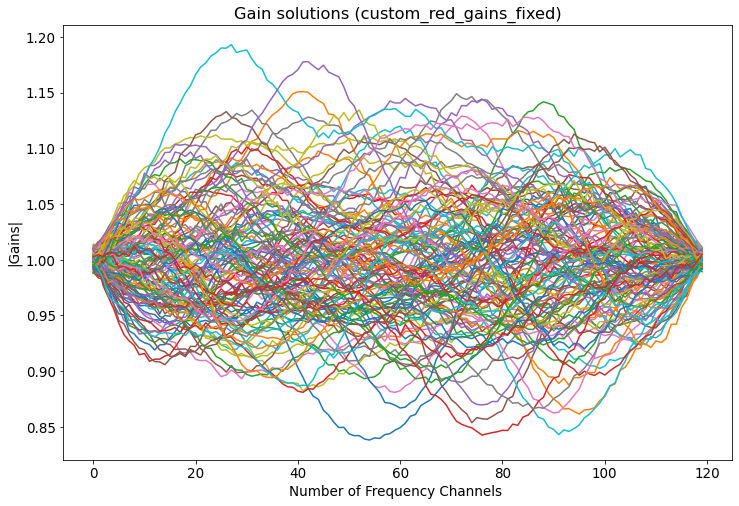

In [294]:
plt.figure(figsize=(12,8))
for i in range(len(cal['g_omnical'])):
    plt.plot(abs(cal['g_omnical'][( int('{}'.format(i)) , 'Jee' )][0] ))
plt.xlabel('Number of Frequency Channels ')
plt.ylabel('|Gains|')
plt.title('Gain solutions (custom_red_gains_fixed)')
#plt.legend()
plt.show()

In [ ]:
def baseline_identifier(group_number):
    ### A function to help us find out the baseline IDs of the number (non-diagonal element)
    ### in the confusion matrix
    list1 = []
    list2 = []

    for i in range(len(n)):
        if true_labels[i]==group_number:
            list1.append(n[i])

    for i in range(len(n)):
        if predicted_labels(pred_labels)[i]==group_number:
            list2.append(n[i])

    set1 = set(list1)
    set2 = set(list2)

    missing = list(sorted(set1 - set2))
    added = list(sorted(set2 - set1))

    print('missing:', missing)  ## baselines that should be classified as being true
    print(' ')
    print('added:', added) ## Baselines that do not belong to the group

baseline_identifier(Number_of_clusters)


In [168]:


redundant_baseline_group = []
for bg in range(len(reds_all)):
    redundant_baselines = []
    for a_num in range(len(reds_all[bg])):
        bID = hd.antnums_to_baseline(reds_all[bg][a_num][0],reds_all[bg][a_num][1])
        redundant_baselines.append(bID)
    redundant_baseline_group.append(redundant_baselines) ## Saving a list of redundant baselines in an array.

aa = []
for i in redundant_baseline_group[1]: ## red_a
    aa.append(i in red_base[0][6])    ## red_base
True in aa

True

 antpos: dictionary of antenna positions in the form {ant_index: np.array([x,y,z])}

In [218]:
def get_baseline_length(index_number):
    baseline_length = []
    for i in range(len(reds_all)):
        k = index_number
        a = reds_all[i][k][0]
        b = reds_all[i][k][1]

        x1 = hd.antpos[a][0]
        y1 = hd.antpos[a][1]

        x2 = hd.antpos[b][0]
        y2 = hd.antpos[b][1]

        r = np.sqrt( np.square(x1-x2)+ np.square(y1-y2) )
        baseline_length.append(r)
    return baseline_length

r2 = red_base[2]
r2.sort()
r2=np.round(r2[1:],7)


# for j in range(len(reds_all)):
#     r1 = get_baseline_length(0)
#     r1 = np.round(r1,7)
#     if r1[j] == r2[j]:
#         print(j,'true')
#     else:
#         print(j,'false')

#get_reds_array = [red groups, baseline lengths]
get_reds_array = [reds_all, r1]

print(get_reds_array[1][0])
print(get_reds_array[0][0])

14.6
[(0, 5, 'nn'), (1, 6, 'nn'), (2, 7, 'nn'), (3, 8, 'nn'), (4, 9, 'nn'), (5, 11, 'nn'), (6, 12, 'nn'), (7, 13, 'nn'), (8, 14, 'nn'), (9, 15, 'nn'), (10, 16, 'nn'), (11, 18, 'nn'), (12, 19, 'nn'), (13, 20, 'nn'), (14, 21, 'nn'), (15, 22, 'nn'), (16, 23, 'nn'), (17, 24, 'nn'), (18, 26, 'nn'), (19, 27, 'nn'), (20, 28, 'nn'), (21, 29, 'nn'), (22, 30, 'nn'), (23, 31, 'nn'), (24, 32, 'nn'), (25, 33, 'nn'), (26, 35, 'nn'), (27, 36, 'nn'), (28, 37, 'nn'), (29, 38, 'nn'), (30, 39, 'nn'), (31, 40, 'nn'), (32, 41, 'nn'), (33, 42, 'nn'), (34, 43, 'nn'), (35, 45, 'nn'), (36, 46, 'nn'), (37, 47, 'nn'), (38, 48, 'nn'), (39, 49, 'nn'), (40, 50, 'nn'), (41, 51, 'nn'), (42, 52, 'nn'), (43, 53, 'nn'), (44, 54, 'nn'), (45, 56, 'nn'), (46, 57, 'nn'), (47, 58, 'nn'), (48, 59, 'nn'), (49, 60, 'nn'), (50, 61, 'nn'), (51, 62, 'nn'), (52, 63, 'nn'), (53, 64, 'nn'), (54, 65, 'nn'), (55, 66, 'nn'), (57, 68, 'nn'), (58, 69, 'nn'), (59, 70, 'nn'), (60, 71, 'nn'), (61, 72, 'nn'), (62, 73, 'nn'), (63, 74, 'nn'), (

In [47]:
for k in range(len(reds_all)):
    print(k,'red_a = ',len(reds_all[k]))
    print(k,'rbase =',len(red_base[0][k]), (red_base[2][k]) )
    print(' ')

0 red_a =  112
0 rbase = 124 0.0
 
1 red_a =  112
1 rbase = 109 14.600000000010287
 
2 red_a =  109
2 rbase = 94 29.200000000016843
 
3 red_a =  101
3 rbase = 79 43.80000000002925
 
4 red_a =  98
4 rbase = 64 58.40000000003031
 
5 red_a =  98
5 rbase = 112 14.599999999992438
 
6 red_a =  94
6 rbase = 112 14.599999999998975
 
7 red_a =  100
7 rbase = 98 25.287941790527576
 
8 red_a =  100
8 rbase = 84 38.62796914157932
 
9 red_a =  84
9 rbase = 70 52.641048621823415
 
10 red_a =  84
10 rbase = 56 66.90560514641133
 
11 red_a =  87
11 rbase = 100 29.19999999999849
 
12 red_a =  87
12 rbase = 101 25.287941790506224
 
13 red_a =  90
13 rbase = 100 29.20000000001934
 
14 red_a =  90
14 rbase = 87 38.62796914158067
 
15 red_a =  88
15 rbase = 74 50.57588358106327
 
16 red_a =  88
16 rbase = 61 63.639924575756545
 
17 red_a =  79
17 rbase = 48 77.25593828316238
 
18 red_a =  74
18 rbase = 88 43.79999999998268
 
19 red_a =  74
19 rbase = 90 38.627969141529995
 
20 red_a =  80
20 rbase = 90 38.